In [1]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def show_confusion_matrix(validations, predictions,title="Confusion Matrix"):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def show_basic_dataframe_info(dataframe,
                              preview_rows=20):

    """
    This function shows basic information for the given dataframe
    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview
    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())


def read_data(file_path):

    """
    This function reads the accelerometer data from a file
    Args:
        file_path: URL pointing to the CSV file
    Returns:
        A pandas dataframe
    """

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels
    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels




In [3]:
import pickle
def read_h5():
    lst = []
    with open("X and Y Dataset/x_train.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/y_train.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/x_test.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/y_test.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    return lst
def read_properties():
    lst = None
    with open('X and Y Dataset/properties.pickle','rb+') as fd:
        lst = pickle.load(fd)
    return lst
x_train,y_train,x_test,y_test = read_h5()
TIME_PERIODS = 80
num_time_periods, num_sensors,num_classes,input_shape = read_properties()
LABELS = ["Downstairs",
          "Jogging",
          "Sitting",
          "Standing",
          "Upstairs",
          "Walking"]


--- Create neural network model ---

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 76, 10)            160       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 10)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 21, 10)            510       
_________________________________________________________________
global_average_pooling1d_1 ( (None, 10)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense) 

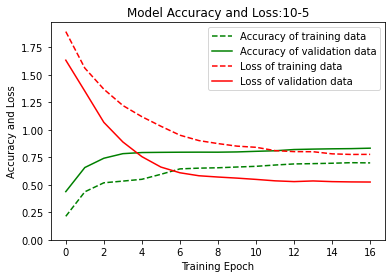


--- Check against test data ---

6584/6584 [==============================] - 0s 28us/step

Accuracy on test data: 0.76

Loss on test data: 0.61

--- Confusion matrix for test data ---



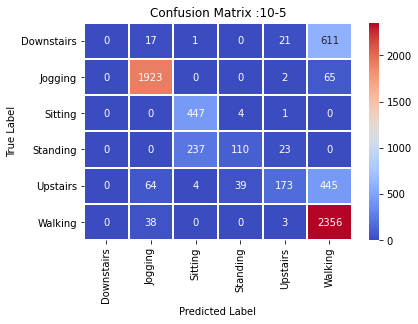


--- Classification report for test data 10:5---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.94      0.97      0.95      1990
           2       0.65      0.99      0.78       452
           3       0.72      0.30      0.42       370
           4       0.78      0.24      0.36       725
           5       0.68      0.98      0.80      2397

    accuracy                           0.76      6584
   macro avg       0.63      0.58      0.55      6584
weighted avg       0.70      0.76      0.70      6584



/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.7607837319374084

In [4]:
print("\n--- Create neural network model ---\n")
def call_model(filters_val=10,kernal_val=5):
    # 1D CNN neural network
    model_m = Sequential()
    model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
    model_m.add(Conv1D(filters_val, kernal_val, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
    model_m.add(MaxPooling1D(3))
    model_m.add(Conv1D(filters_val, kernal_val, activation='relu'))
    if kernal_val >100:
        model_m.add(Dropout(0.5))
    model_m.add(GlobalAveragePooling1D())
    model_m.add(Dropout(0.5))
    model_m.add(Dense(num_classes, activation='softmax'))
    print(model_m.summary())
    # Accuracy on training data: 99%
    # Accuracy on test data: 91%

    print("\n--- Fit the model ---\n")

    # The EarlyStopping callback monitors training accuracy:
    # if it fails to improve for two consecutive epochs,
    # training stops early
    callbacks_list = [
        keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
    ]

    model_m.compile(loss='categorical_crossentropy',
                    optimizer='adam', metrics=['accuracy'])

    BATCH_SIZE = 200
    EPOCHS = 25

    # Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
    history = model_m.fit(x_train,
                          y_train,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          callbacks=callbacks_list,
                          validation_split=0.2,
                          verbose=1)

    print("\n--- Learning curve of model training ---\n")

    # summarize history for accuracy and loss
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
    plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
    plt.plot(history.history['loss'], "r--", label="Loss of training data")
    plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
    plt.title('Model Accuracy and Loss:'+str(filters_val)+"-"+str(kernal_val))
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()
    print("\n--- Check against test data ---\n")

    score = model_m.evaluate(x_test, y_test, verbose=1)

    print("\nAccuracy on test data: %0.2f" % score[1])
    print("\nLoss on test data: %0.2f" % score[0])

    print("\n--- Confusion matrix for test data ---\n")

    y_pred_test = model_m.predict(x_test)
    # Take the class with the highest probability from the test predictions
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(y_test, axis=1)

    show_confusion_matrix(max_y_test, max_y_pred_test,title="Confusion Matrix :"+str(filters_val)+"-"+str(kernal_val))
    print("\n--- Classification report for test data "+str(filters_val)+":"+str(kernal_val)+"---\n")

    print(classification_report(max_y_test, max_y_pred_test))
    return score[1]
call_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 79, 5)             35        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 26, 5)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 25, 5)             55        
_________________________________________________________________
global_average_pooling1d_2 ( (None, 5)                 0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                

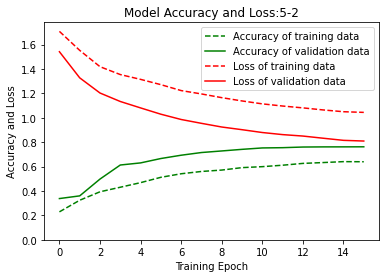


--- Check against test data ---

6584/6584 [==============================] - 0s 33us/step

Accuracy on test data: 0.59

Loss on test data: 0.98

--- Confusion matrix for test data ---



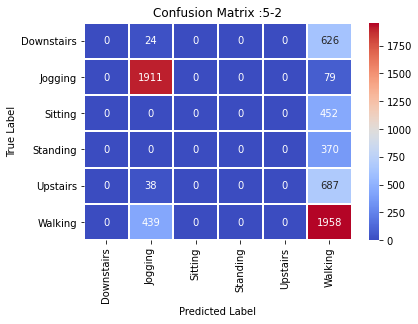


--- Classification report for test data 5:2---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.79      0.96      0.87      1990
           2       0.00      0.00      0.00       452
           3       0.00      0.00      0.00       370
           4       0.00      0.00      0.00       725
           5       0.47      0.82      0.60      2397

    accuracy                           0.59      6584
   macro avg       0.21      0.30      0.24      6584
weighted avg       0.41      0.59      0.48      6584

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 76, 5)             80        
________________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 41us/step - loss: 1.6788 - accuracy: 0.3158 - val_loss: 1.4844 - val_accuracy: 0.5515
Epoch 2/25
16694/16694 [==============================] - 1s 32us/step - loss: 1.4664 - accuracy: 0.4421 - val_loss: 1.2051 - val_accuracy: 0.6782
Epoch 3/25
16694/16694 [==============================] - 0s 29us/step - loss: 1.3202 - accuracy: 0.4711 - val_loss: 1.0514 - val_accuracy: 0.7566
Epoch 4/25
16694/16694 [==============================] - 1s 32us/step - loss: 1.2298 - accuracy: 0.5373 - val_loss: 0.9463 - val_accuracy: 0.7643
Epoch 5/25
16694/16694 [==============================] - 0s 26us/step - loss: 1.1606 - accuracy: 0.5912 - val_loss: 0.8830 - val_accuracy: 0.7650
Epoch 6/25
16694/16694 [==============================] - 1s 36us/step - loss: 1.1284 - accuracy: 0.6302 - val_loss: 0.8511 - val_accuracy: 0.7664
Epoch 7/25
16694/16694 [==============================] - 1s 32us/ste

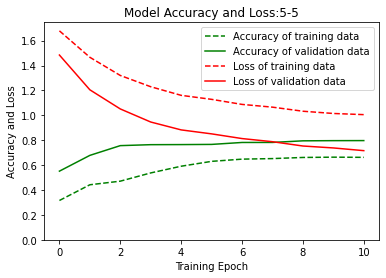


--- Check against test data ---

6584/6584 [==============================] - 0s 35us/step

Accuracy on test data: 0.71

Loss on test data: 0.83

--- Confusion matrix for test data ---



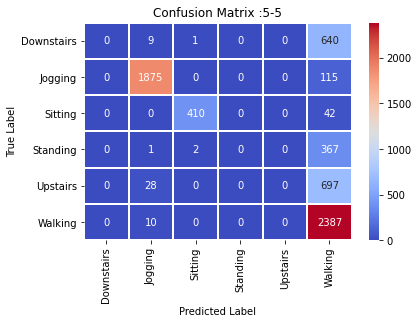


--- Classification report for test data 5:5---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.98      0.94      0.96      1990
           2       0.99      0.91      0.95       452
           3       0.00      0.00      0.00       370
           4       0.00      0.00      0.00       725
           5       0.56      1.00      0.72      2397

    accuracy                           0.71      6584
   macro avg       0.42      0.47      0.44      6584
weighted avg       0.57      0.71      0.62      6584

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 73, 5)             125       
________________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 52us/step - loss: 1.6687 - accuracy: 0.2972 - val_loss: 1.4906 - val_accuracy: 0.3388
Epoch 2/25
16694/16694 [==============================] - 0s 27us/step - loss: 1.4928 - accuracy: 0.3701 - val_loss: 1.2862 - val_accuracy: 0.3661
Epoch 3/25
16694/16694 [==============================] - 0s 27us/step - loss: 1.3525 - accuracy: 0.4342 - val_loss: 1.1546 - val_accuracy: 0.6481
Epoch 4/25
16694/16694 [==============================] - 0s 24us/step - loss: 1.2740 - accuracy: 0.5248 - val_loss: 1.0867 - val_accuracy: 0.7674
Epoch 5/25
16694/16694 [==============================] - 0s 25us/step - loss: 1.2252 - accuracy: 0.5748 - val_loss: 0.9937 - val_accuracy: 0.7688
Epoch 6/25
16694/16694 [==============================] - 0s 28us/step - loss: 1.1683 - accuracy: 0.6168 - val_loss: 0.9334 - val_accuracy: 0.7645
Epoch 7/25
16694/16694 [==============================] - 0s 26us/ste

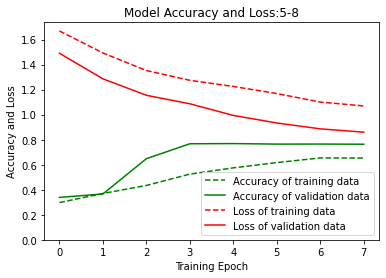


--- Check against test data ---

6584/6584 [==============================] - 0s 24us/step

Accuracy on test data: 0.71

Loss on test data: 0.86

--- Confusion matrix for test data ---



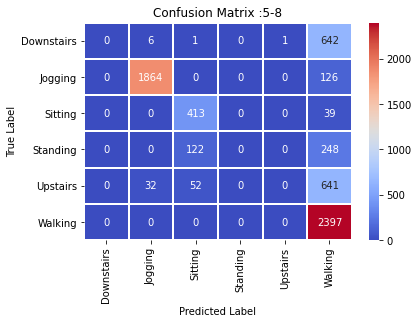


--- Classification report for test data 5:8---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.98      0.94      0.96      1990
           2       0.70      0.91      0.79       452
           3       0.00      0.00      0.00       370
           4       0.00      0.00      0.00       725
           5       0.59      1.00      0.74      2397

    accuracy                           0.71      6584
   macro avg       0.38      0.48      0.42      6584
weighted avg       0.56      0.71      0.61      6584

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 71, 5)             155       
________________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 38us/step - loss: 1.6037 - accuracy: 0.3027 - val_loss: 1.2330 - val_accuracy: 0.7058
Epoch 2/25
16694/16694 [==============================] - 0s 25us/step - loss: 1.3327 - accuracy: 0.4113 - val_loss: 0.9367 - val_accuracy: 0.7504
Epoch 3/25
16694/16694 [==============================] - 1s 31us/step - loss: 1.1821 - accuracy: 0.5080 - val_loss: 0.7579 - val_accuracy: 0.7753
Epoch 4/25
16694/16694 [==============================] - 1s 38us/step - loss: 1.0859 - accuracy: 0.5515 - val_loss: 0.6853 - val_accuracy: 0.7885
Epoch 5/25
16694/16694 [==============================] - 1s 37us/step - loss: 1.0332 - accuracy: 0.5674 - val_loss: 0.6510 - val_accuracy: 0.7887
Epoch 6/25
16694/16694 [==============================] - 1s 36us/step - loss: 1.0020 - accuracy: 0.5746 - val_loss: 0.6339 - val_accuracy: 0.7863
Epoch 7/25
16694/16694 [==============================] - 0s 29us/ste

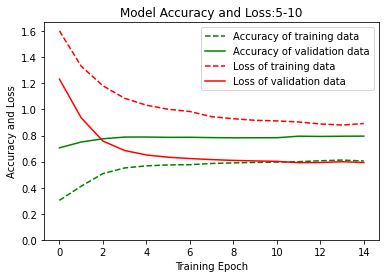


--- Check against test data ---

6584/6584 [==============================] - 0s 29us/step

Accuracy on test data: 0.73

Loss on test data: 0.66

--- Confusion matrix for test data ---



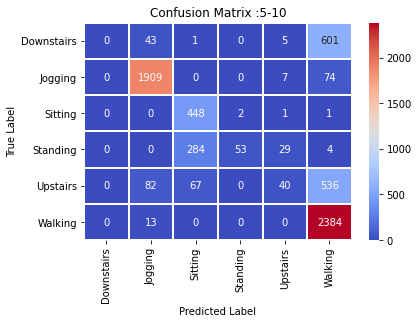


--- Classification report for test data 5:10---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.93      0.96      0.95      1990
           2       0.56      0.99      0.72       452
           3       0.96      0.14      0.25       370
           4       0.49      0.06      0.10       725
           5       0.66      0.99      0.80      2397

    accuracy                           0.73      6584
   macro avg       0.60      0.52      0.47      6584
weighted avg       0.67      0.73      0.65      6584

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 69, 5)             185       
_______________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 54us/step - loss: 1.6965 - accuracy: 0.3148 - val_loss: 1.3624 - val_accuracy: 0.7118
Epoch 2/25
16694/16694 [==============================] - 1s 40us/step - loss: 1.4077 - accuracy: 0.4493 - val_loss: 1.1118 - val_accuracy: 0.7365
Epoch 3/25
16694/16694 [==============================] - 1s 33us/step - loss: 1.2688 - accuracy: 0.5126 - val_loss: 0.9666 - val_accuracy: 0.7422
Epoch 4/25
16694/16694 [==============================] - 1s 30us/step - loss: 1.1764 - accuracy: 0.5779 - val_loss: 0.8905 - val_accuracy: 0.7607
Epoch 5/25
16694/16694 [==============================] - 1s 35us/step - loss: 1.1233 - accuracy: 0.6076 - val_loss: 0.8201 - val_accuracy: 0.7659
Epoch 6/25
16694/16694 [==============================] - 1s 34us/step - loss: 1.0674 - accuracy: 0.6206 - val_loss: 0.7598 - val_accuracy: 0.7638
Epoch 7/25
16694/16694 [==============================] - 1s 35us/ste

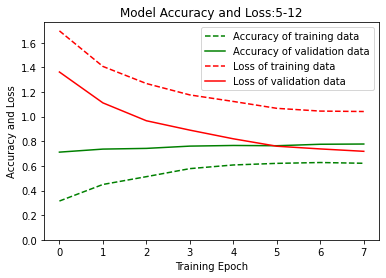


--- Check against test data ---

6584/6584 [==============================] - 0s 22us/step

Accuracy on test data: 0.71

Loss on test data: 0.77

--- Confusion matrix for test data ---



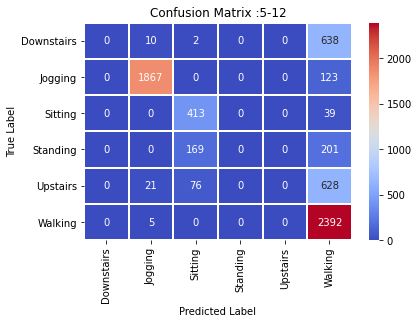


--- Classification report for test data 5:12---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.98      0.94      0.96      1990
           2       0.63      0.91      0.74       452
           3       0.00      0.00      0.00       370
           4       0.00      0.00      0.00       725
           5       0.59      1.00      0.75      2397

    accuracy                           0.71      6584
   macro avg       0.37      0.47      0.41      6584
weighted avg       0.56      0.71      0.61      6584

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 66, 5)             230       
_______________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 39us/step - loss: 1.8017 - accuracy: 0.2675 - val_loss: 1.6121 - val_accuracy: 0.3483
Epoch 2/25
16694/16694 [==============================] - 0s 29us/step - loss: 1.5778 - accuracy: 0.3958 - val_loss: 1.3989 - val_accuracy: 0.5719
Epoch 3/25
16694/16694 [==============================] - 0s 27us/step - loss: 1.4224 - accuracy: 0.5250 - val_loss: 1.0785 - val_accuracy: 0.7511
Epoch 4/25
16694/16694 [==============================] - 0s 27us/step - loss: 1.2252 - accuracy: 0.5504 - val_loss: 0.8250 - val_accuracy: 0.7604
Epoch 5/25
16694/16694 [==============================] - 0s 27us/step - loss: 1.1192 - accuracy: 0.5715 - val_loss: 0.7169 - val_accuracy: 0.7815
Epoch 6/25
16694/16694 [==============================] - 1s 34us/step - loss: 1.0711 - accuracy: 0.6064 - val_loss: 0.7014 - val_accuracy: 0.7803
Epoch 7/25
16694/16694 [==============================] - 1s 32us/ste

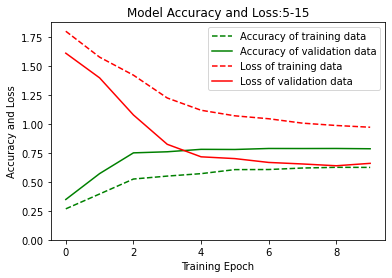


--- Check against test data ---

6584/6584 [==============================] - 0s 23us/step

Accuracy on test data: 0.72

Loss on test data: 0.74

--- Confusion matrix for test data ---



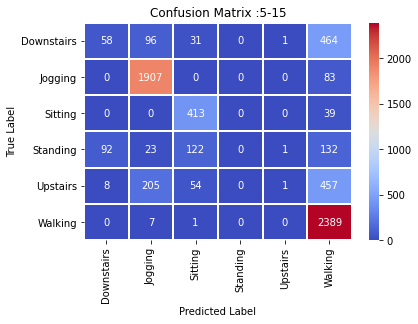


--- Classification report for test data 5:15---

              precision    recall  f1-score   support

           0       0.37      0.09      0.14       650
           1       0.85      0.96      0.90      1990
           2       0.67      0.91      0.77       452
           3       0.00      0.00      0.00       370
           4       0.33      0.00      0.00       725
           5       0.67      1.00      0.80      2397

    accuracy                           0.72      6584
   macro avg       0.48      0.49      0.44      6584
weighted avg       0.62      0.72      0.63      6584

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 63, 5)             275       
_______________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 38us/step - loss: 1.7921 - accuracy: 0.1858 - val_loss: 1.6714 - val_accuracy: 0.1950
Epoch 2/25
16694/16694 [==============================] - 0s 26us/step - loss: 1.5884 - accuracy: 0.2832 - val_loss: 1.3920 - val_accuracy: 0.4964
Epoch 3/25
16694/16694 [==============================] - 0s 26us/step - loss: 1.3516 - accuracy: 0.5247 - val_loss: 1.2133 - val_accuracy: 0.6622
Epoch 4/25
16694/16694 [==============================] - 0s 26us/step - loss: 1.2174 - accuracy: 0.5922 - val_loss: 1.1413 - val_accuracy: 0.7156
Epoch 5/25
16694/16694 [==============================] - 0s 25us/step - loss: 1.1404 - accuracy: 0.6278 - val_loss: 1.0365 - val_accuracy: 0.7547
Epoch 6/25
16694/16694 [==============================] - 0s 26us/step - loss: 1.0674 - accuracy: 0.6542 - val_loss: 0.9308 - val_accuracy: 0.7535
Epoch 7/25
16694/16694 [==============================] - 0s 26us/ste

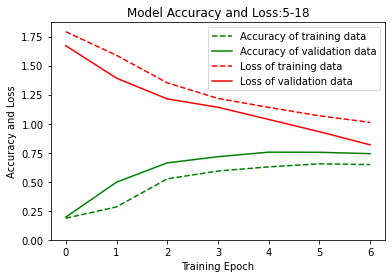


--- Check against test data ---

6584/6584 [==============================] - 0s 23us/step

Accuracy on test data: 0.73

Loss on test data: 0.76

--- Confusion matrix for test data ---



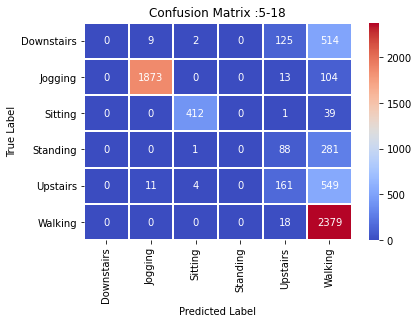


--- Classification report for test data 5:18---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.99      0.94      0.96      1990
           2       0.98      0.91      0.95       452
           3       0.00      0.00      0.00       370
           4       0.40      0.22      0.28       725
           5       0.62      0.99      0.76      2397

    accuracy                           0.73      6584
   macro avg       0.50      0.51      0.49      6584
weighted avg       0.63      0.73      0.66      6584

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 61, 5)             305       
_______________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 39us/step - loss: 1.8043 - accuracy: 0.3142 - val_loss: 1.7251 - val_accuracy: 0.4360
Epoch 2/25
16694/16694 [==============================] - 0s 28us/step - loss: 1.7153 - accuracy: 0.3809 - val_loss: 1.6667 - val_accuracy: 0.4377
Epoch 3/25
16694/16694 [==============================] - 0s 26us/step - loss: 1.6721 - accuracy: 0.3827 - val_loss: 1.6131 - val_accuracy: 0.4427
Epoch 4/25
16694/16694 [==============================] - 0s 26us/step - loss: 1.6295 - accuracy: 0.3791 - val_loss: 1.5622 - val_accuracy: 0.4190

--- Learning curve of model training ---



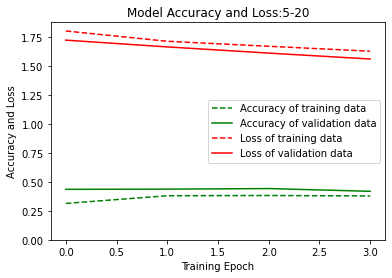


--- Check against test data ---

6584/6584 [==============================] - 0s 22us/step

Accuracy on test data: 0.38

Loss on test data: 1.61

--- Confusion matrix for test data ---



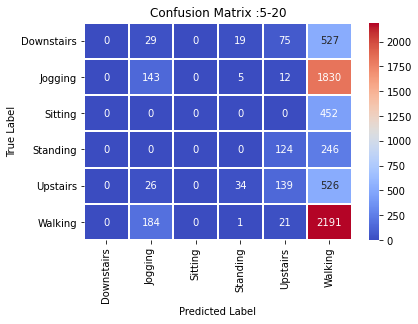


--- Classification report for test data 5:20---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.37      0.07      0.12      1990
           2       0.00      0.00      0.00       452
           3       0.00      0.00      0.00       370
           4       0.37      0.19      0.25       725
           5       0.38      0.91      0.54      2397

    accuracy                           0.38      6584
   macro avg       0.19      0.20      0.15      6584
weighted avg       0.29      0.38      0.26      6584



/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 79, 10)            70        
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 26, 10)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 25, 10)            210       
_________________________________________________________________
global_average_pooling1d_10  (None, 10)                0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)               

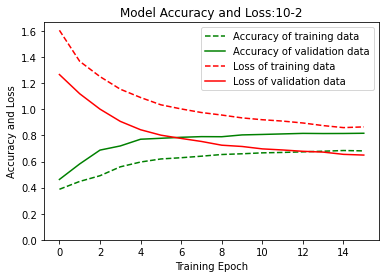


--- Check against test data ---

6584/6584 [==============================] - 0s 27us/step

Accuracy on test data: 0.67

Loss on test data: 0.77

--- Confusion matrix for test data ---



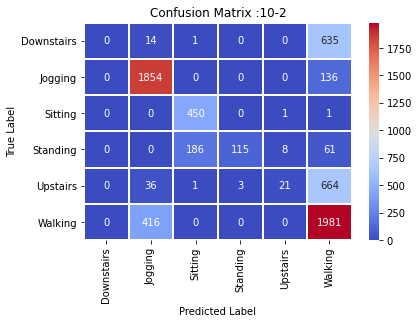


--- Classification report for test data 10:2---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.80      0.93      0.86      1990
           2       0.71      1.00      0.83       452
           3       0.97      0.31      0.47       370
           4       0.70      0.03      0.06       725
           5       0.57      0.83      0.67      2397

    accuracy                           0.67      6584
   macro avg       0.62      0.52      0.48      6584
weighted avg       0.63      0.67      0.59      6584

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_11 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 76, 10)            160       
______________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 48us/step - loss: 1.6897 - accuracy: 0.2894 - val_loss: 1.1797 - val_accuracy: 0.5079
Epoch 2/25
16694/16694 [==============================] - 1s 35us/step - loss: 1.2813 - accuracy: 0.4692 - val_loss: 0.9545 - val_accuracy: 0.7288
Epoch 3/25
16694/16694 [==============================] - 0s 28us/step - loss: 1.1623 - accuracy: 0.5397 - val_loss: 0.8857 - val_accuracy: 0.7659
Epoch 4/25
16694/16694 [==============================] - 0s 29us/step - loss: 1.1017 - accuracy: 0.5987 - val_loss: 0.8187 - val_accuracy: 0.7688
Epoch 5/25
16694/16694 [==============================] - 0s 27us/step - loss: 1.0574 - accuracy: 0.6365 - val_loss: 0.7814 - val_accuracy: 0.7688
Epoch 6/25
16694/16694 [==============================] - 0s 27us/step - loss: 1.0201 - accuracy: 0.6557 - val_loss: 0.7578 - val_accuracy: 0.7813
Epoch 7/25
16694/16694 [==============================] - 0s 28us/ste

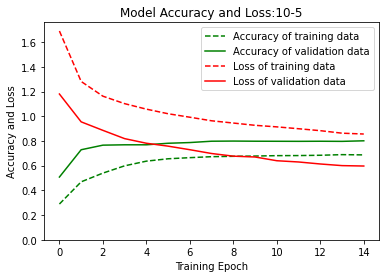


--- Check against test data ---

6584/6584 [==============================] - 0s 25us/step

Accuracy on test data: 0.72

Loss on test data: 0.70

--- Confusion matrix for test data ---



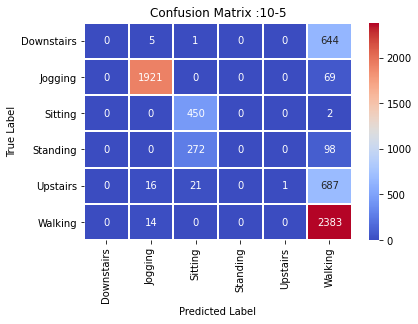


--- Classification report for test data 10:5---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.98      0.97      0.97      1990
           2       0.60      1.00      0.75       452
           3       0.00      0.00      0.00       370
           4       1.00      0.00      0.00       725
           5       0.61      0.99      0.76      2397

    accuracy                           0.72      6584
   macro avg       0.53      0.49      0.41      6584
weighted avg       0.67      0.72      0.62      6584

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 73, 10)            250       
______________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 39us/step - loss: 1.4835 - accuracy: 0.3792 - val_loss: 0.9778 - val_accuracy: 0.7374
Epoch 2/25
16694/16694 [==============================] - 0s 25us/step - loss: 1.0909 - accuracy: 0.5775 - val_loss: 0.7262 - val_accuracy: 0.7635
Epoch 3/25
16694/16694 [==============================] - 0s 25us/step - loss: 0.9492 - accuracy: 0.6253 - val_loss: 0.6479 - val_accuracy: 0.7587
Epoch 4/25
16694/16694 [==============================] - 0s 25us/step - loss: 0.8937 - accuracy: 0.6566 - val_loss: 0.6309 - val_accuracy: 0.7753
Epoch 5/25
16694/16694 [==============================] - 0s 25us/step - loss: 0.8300 - accuracy: 0.6837 - val_loss: 0.6084 - val_accuracy: 0.7853
Epoch 6/25
16694/16694 [==============================] - 0s 25us/step - loss: 0.7869 - accuracy: 0.6961 - val_loss: 0.5981 - val_accuracy: 0.7825
Epoch 7/25
16694/16694 [==============================] - 0s 25us/ste

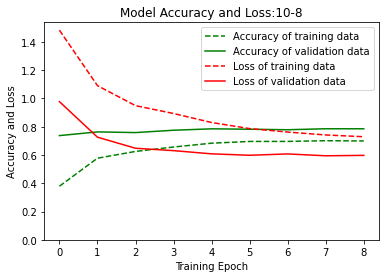


--- Check against test data ---

6584/6584 [==============================] - 0s 22us/step

Accuracy on test data: 0.74

Loss on test data: 0.65

--- Confusion matrix for test data ---



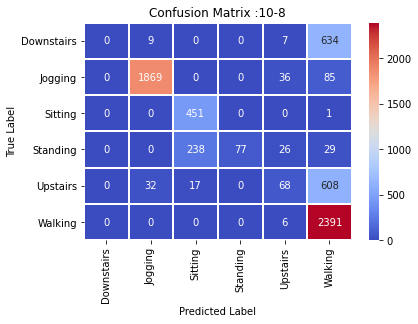


--- Classification report for test data 10:8---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.98      0.94      0.96      1990
           2       0.64      1.00      0.78       452
           3       1.00      0.21      0.34       370
           4       0.48      0.09      0.16       725
           5       0.64      1.00      0.78      2397

    accuracy                           0.74      6584
   macro avg       0.62      0.54      0.50      6584
weighted avg       0.68      0.74      0.66      6584

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_13 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 71, 10)            310       
______________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 42us/step - loss: 1.4665 - accuracy: 0.3598 - val_loss: 1.0725 - val_accuracy: 0.7008
Epoch 2/25
16694/16694 [==============================] - 0s 29us/step - loss: 1.1365 - accuracy: 0.5794 - val_loss: 0.8290 - val_accuracy: 0.7722
Epoch 3/25
16694/16694 [==============================] - 0s 30us/step - loss: 0.9782 - accuracy: 0.6472 - val_loss: 0.6964 - val_accuracy: 0.7734
Epoch 4/25
16694/16694 [==============================] - 0s 29us/step - loss: 0.8924 - accuracy: 0.6890 - val_loss: 0.6314 - val_accuracy: 0.7858
Epoch 5/25
16694/16694 [==============================] - 0s 29us/step - loss: 0.8238 - accuracy: 0.7068 - val_loss: 0.5886 - val_accuracy: 0.7887
Epoch 6/25
16694/16694 [==============================] - 0s 28us/step - loss: 0.7831 - accuracy: 0.7116 - val_loss: 0.5612 - val_accuracy: 0.8064
Epoch 7/25
16694/16694 [==============================] - 0s 30us/ste

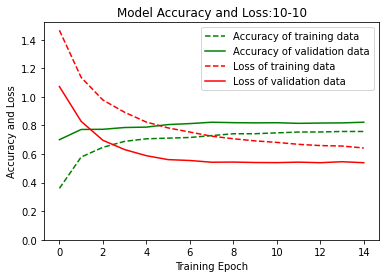


--- Check against test data ---

6584/6584 [==============================] - 0s 26us/step

Accuracy on test data: 0.80

Loss on test data: 0.54

--- Confusion matrix for test data ---



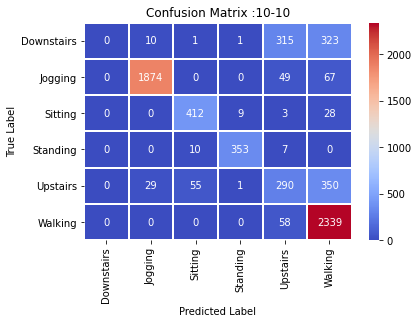


--- Classification report for test data 10:10---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.98      0.94      0.96      1990
           2       0.86      0.91      0.89       452
           3       0.97      0.95      0.96       370
           4       0.40      0.40      0.40       725
           5       0.75      0.98      0.85      2397

    accuracy                           0.80      6584
   macro avg       0.66      0.70      0.68      6584
weighted avg       0.73      0.80      0.76      6584

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_14 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 69, 10)            370       
_____________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 41us/step - loss: 1.4474 - accuracy: 0.4333 - val_loss: 0.9845 - val_accuracy: 0.7441
Epoch 2/25
16694/16694 [==============================] - 0s 27us/step - loss: 1.1219 - accuracy: 0.5872 - val_loss: 0.7559 - val_accuracy: 0.7887
Epoch 3/25
16694/16694 [==============================] - 0s 29us/step - loss: 0.9441 - accuracy: 0.6769 - val_loss: 0.6261 - val_accuracy: 0.7961
Epoch 4/25
16694/16694 [==============================] - 0s 28us/step - loss: 0.8487 - accuracy: 0.6983 - val_loss: 0.5819 - val_accuracy: 0.8021
Epoch 5/25
16694/16694 [==============================] - 1s 30us/step - loss: 0.8093 - accuracy: 0.7057 - val_loss: 0.5732 - val_accuracy: 0.8059
Epoch 6/25
16694/16694 [==============================] - 0s 29us/step - loss: 0.7684 - accuracy: 0.7113 - val_loss: 0.5686 - val_accuracy: 0.8088
Epoch 7/25
16694/16694 [==============================] - 0s 27us/ste

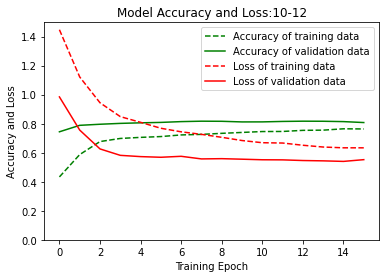


--- Check against test data ---

6584/6584 [==============================] - 0s 25us/step

Accuracy on test data: 0.80

Loss on test data: 0.52

--- Confusion matrix for test data ---



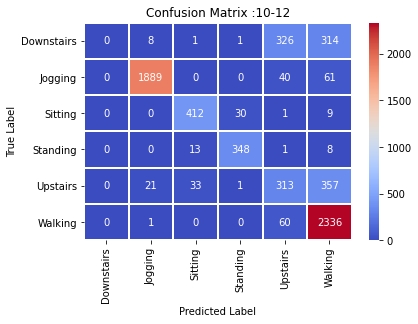


--- Classification report for test data 10:12---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.98      0.95      0.97      1990
           2       0.90      0.91      0.90       452
           3       0.92      0.94      0.93       370
           4       0.42      0.43      0.43       725
           5       0.76      0.97      0.85      2397

    accuracy                           0.80      6584
   macro avg       0.66      0.70      0.68      6584
weighted avg       0.73      0.80      0.76      6584

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_15 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 66, 10)            460       
_____________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 39us/step - loss: 1.5597 - accuracy: 0.3797 - val_loss: 1.0628 - val_accuracy: 0.7329
Epoch 2/25
16694/16694 [==============================] - 0s 27us/step - loss: 1.1313 - accuracy: 0.5981 - val_loss: 0.7421 - val_accuracy: 0.7839
Epoch 3/25
16694/16694 [==============================] - 0s 27us/step - loss: 0.9616 - accuracy: 0.6528 - val_loss: 0.6448 - val_accuracy: 0.7827
Epoch 4/25
16694/16694 [==============================] - 0s 27us/step - loss: 0.8752 - accuracy: 0.6814 - val_loss: 0.6304 - val_accuracy: 0.8028
Epoch 5/25
16694/16694 [==============================] - 0s 27us/step - loss: 0.8186 - accuracy: 0.7131 - val_loss: 0.6043 - val_accuracy: 0.8117
Epoch 6/25
16694/16694 [==============================] - 0s 27us/step - loss: 0.7746 - accuracy: 0.7242 - val_loss: 0.6073 - val_accuracy: 0.8055
Epoch 7/25
16694/16694 [==============================] - 0s 27us/ste

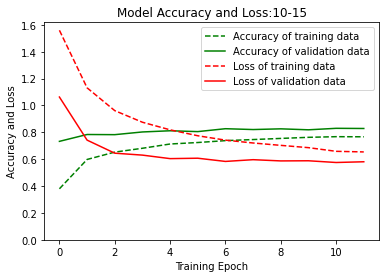


--- Check against test data ---

6584/6584 [==============================] - 0s 24us/step

Accuracy on test data: 0.82

Loss on test data: 0.56

--- Confusion matrix for test data ---



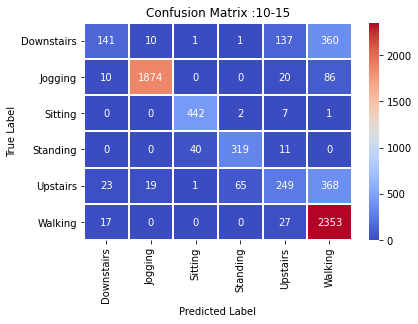


--- Classification report for test data 10:15---

              precision    recall  f1-score   support

           0       0.74      0.22      0.34       650
           1       0.98      0.94      0.96      1990
           2       0.91      0.98      0.94       452
           3       0.82      0.86      0.84       370
           4       0.55      0.34      0.42       725
           5       0.74      0.98      0.85      2397

    accuracy                           0.82      6584
   macro avg       0.79      0.72      0.73      6584
weighted avg       0.81      0.82      0.79      6584

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_16 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 63, 10)            550       
_____________________________________________________

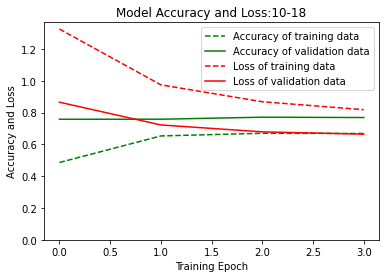


--- Check against test data ---

6584/6584 [==============================] - 0s 23us/step

Accuracy on test data: 0.71

Loss on test data: 0.75

--- Confusion matrix for test data ---



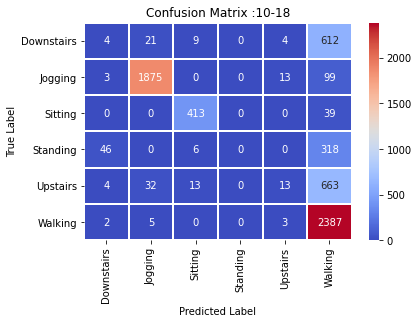


--- Classification report for test data 10:18---

              precision    recall  f1-score   support

           0       0.07      0.01      0.01       650
           1       0.97      0.94      0.96      1990
           2       0.94      0.91      0.92       452
           3       0.00      0.00      0.00       370
           4       0.39      0.02      0.03       725
           5       0.58      1.00      0.73      2397

    accuracy                           0.71      6584
   macro avg       0.49      0.48      0.44      6584
weighted avg       0.62      0.71      0.62      6584



/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_17 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 61, 10)            610       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 1, 10)             2010      
_________________________________________________________________
global_average_pooling1d_17  (None, 10)                0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 6)               

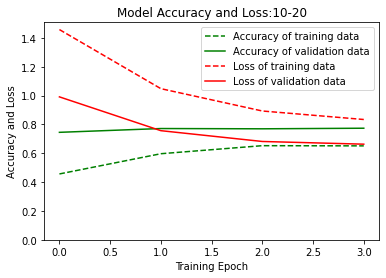


--- Check against test data ---

6584/6584 [==============================] - 0s 22us/step

Accuracy on test data: 0.73

Loss on test data: 0.70

--- Confusion matrix for test data ---



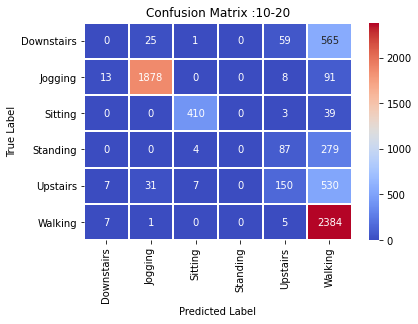


--- Classification report for test data 10:20---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.97      0.94      0.96      1990
           2       0.97      0.91      0.94       452
           3       0.00      0.00      0.00       370
           4       0.48      0.21      0.29       725
           5       0.61      0.99      0.76      2397

    accuracy                           0.73      6584
   macro avg       0.51      0.51      0.49      6584
weighted avg       0.64      0.73      0.66      6584

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_18 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 79, 15)            105       
_____________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 37us/step - loss: 1.6635 - accuracy: 0.2558 - val_loss: 1.2773 - val_accuracy: 0.5331
Epoch 2/25
16694/16694 [==============================] - 0s 26us/step - loss: 1.3630 - accuracy: 0.4491 - val_loss: 1.1312 - val_accuracy: 0.5858
Epoch 3/25
16694/16694 [==============================] - 0s 25us/step - loss: 1.2515 - accuracy: 0.5132 - val_loss: 1.0271 - val_accuracy: 0.6591
Epoch 4/25
16694/16694 [==============================] - 0s 25us/step - loss: 1.1654 - accuracy: 0.5477 - val_loss: 0.9528 - val_accuracy: 0.7180
Epoch 5/25
16694/16694 [==============================] - 0s 25us/step - loss: 1.1079 - accuracy: 0.5716 - val_loss: 0.8910 - val_accuracy: 0.7460
Epoch 6/25
16694/16694 [==============================] - 0s 25us/step - loss: 1.0561 - accuracy: 0.5957 - val_loss: 0.8472 - val_accuracy: 0.7604
Epoch 7/25
16694/16694 [==============================] - 0s 25us/ste

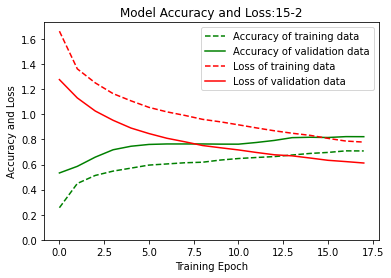


--- Check against test data ---

6584/6584 [==============================] - 0s 27us/step

Accuracy on test data: 0.71

Loss on test data: 0.72

--- Confusion matrix for test data ---



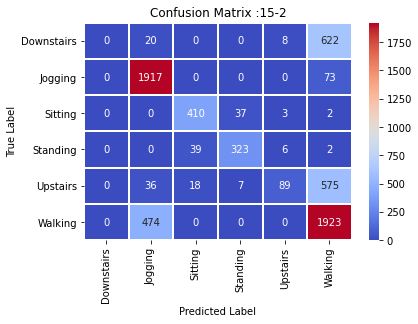


--- Classification report for test data 15:2---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.78      0.96      0.86      1990
           2       0.88      0.91      0.89       452
           3       0.88      0.87      0.88       370
           4       0.84      0.12      0.21       725
           5       0.60      0.80      0.69      2397

    accuracy                           0.71      6584
   macro avg       0.66      0.61      0.59      6584
weighted avg       0.66      0.71      0.65      6584

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_19 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 76, 15)            240       
______________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 39us/step - loss: 1.3352 - accuracy: 0.4431 - val_loss: 0.9862 - val_accuracy: 0.6663
Epoch 2/25
16694/16694 [==============================] - 0s 28us/step - loss: 1.0658 - accuracy: 0.6109 - val_loss: 0.7669 - val_accuracy: 0.7798
Epoch 3/25
16694/16694 [==============================] - 0s 27us/step - loss: 0.9185 - accuracy: 0.6701 - val_loss: 0.6382 - val_accuracy: 0.7976
Epoch 4/25
16694/16694 [==============================] - 0s 27us/step - loss: 0.8343 - accuracy: 0.6923 - val_loss: 0.5939 - val_accuracy: 0.8021
Epoch 5/25
16694/16694 [==============================] - 0s 27us/step - loss: 0.7769 - accuracy: 0.7107 - val_loss: 0.5537 - val_accuracy: 0.8107
Epoch 6/25
16694/16694 [==============================] - 0s 27us/step - loss: 0.7358 - accuracy: 0.7258 - val_loss: 0.5329 - val_accuracy: 0.8220
Epoch 7/25
16694/16694 [==============================] - 0s 27us/ste

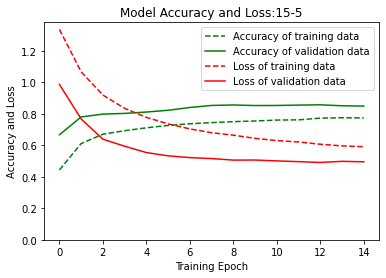


--- Check against test data ---

6584/6584 [==============================] - 0s 26us/step

Accuracy on test data: 0.80

Loss on test data: 0.53

--- Confusion matrix for test data ---



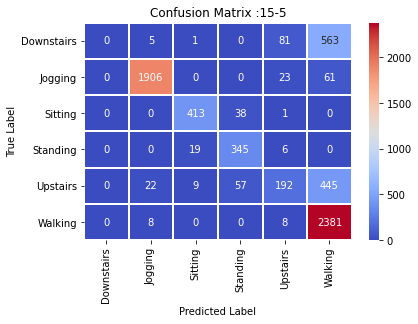


--- Classification report for test data 15:5---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.98      0.96      0.97      1990
           2       0.93      0.91      0.92       452
           3       0.78      0.93      0.85       370
           4       0.62      0.26      0.37       725
           5       0.69      0.99      0.81      2397

    accuracy                           0.80      6584
   macro avg       0.67      0.68      0.66      6584
weighted avg       0.72      0.80      0.74      6584

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_20 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 73, 15)            375       
______________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 41us/step - loss: 1.3091 - accuracy: 0.4906 - val_loss: 0.8500 - val_accuracy: 0.7585
Epoch 2/25
16694/16694 [==============================] - 0s 27us/step - loss: 0.9962 - accuracy: 0.6326 - val_loss: 0.6602 - val_accuracy: 0.7554
Epoch 3/25
16694/16694 [==============================] - 0s 28us/step - loss: 0.8743 - accuracy: 0.6890 - val_loss: 0.5906 - val_accuracy: 0.7928
Epoch 4/25
16694/16694 [==============================] - 0s 27us/step - loss: 0.7959 - accuracy: 0.6909 - val_loss: 0.5649 - val_accuracy: 0.7937
Epoch 5/25
16694/16694 [==============================] - 0s 27us/step - loss: 0.7645 - accuracy: 0.6946 - val_loss: 0.5552 - val_accuracy: 0.8100
Epoch 6/25
16694/16694 [==============================] - 0s 26us/step - loss: 0.7310 - accuracy: 0.7057 - val_loss: 0.5414 - val_accuracy: 0.8184
Epoch 7/25
16694/16694 [==============================] - 0s 27us/ste

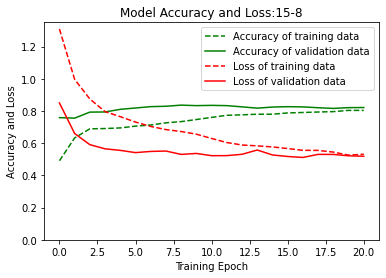


--- Check against test data ---

6584/6584 [==============================] - 0s 24us/step

Accuracy on test data: 0.83

Loss on test data: 0.45

--- Confusion matrix for test data ---



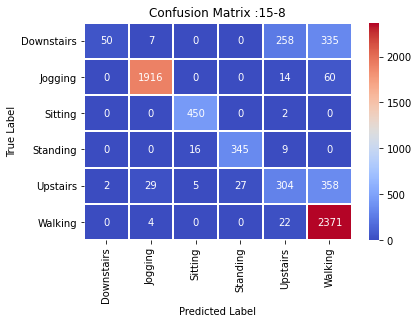


--- Classification report for test data 15:8---

              precision    recall  f1-score   support

           0       0.96      0.08      0.14       650
           1       0.98      0.96      0.97      1990
           2       0.96      1.00      0.98       452
           3       0.93      0.93      0.93       370
           4       0.50      0.42      0.46       725
           5       0.76      0.99      0.86      2397

    accuracy                           0.83      6584
   macro avg       0.85      0.73      0.72      6584
weighted avg       0.84      0.83      0.79      6584

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_21 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 71, 15)            465       
______________________________________________________

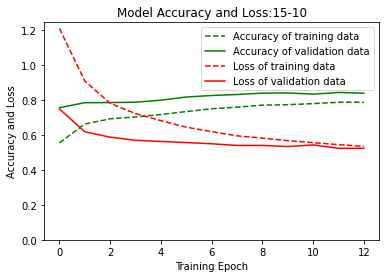


--- Check against test data ---

6584/6584 [==============================] - 0s 26us/step

Accuracy on test data: 0.82

Loss on test data: 0.49

--- Confusion matrix for test data ---



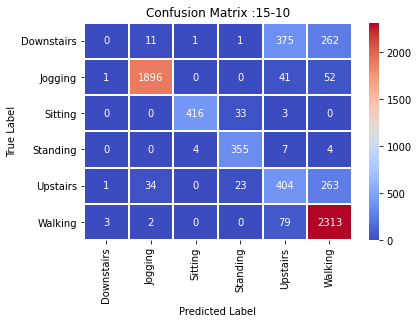


--- Classification report for test data 15:10---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.98      0.95      0.96      1990
           2       0.99      0.92      0.95       452
           3       0.86      0.96      0.91       370
           4       0.44      0.56      0.49       725
           5       0.80      0.96      0.87      2397

    accuracy                           0.82      6584
   macro avg       0.68      0.73      0.70      6584
weighted avg       0.75      0.82      0.78      6584

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_22 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 69, 15)            555       
_____________________________________________________

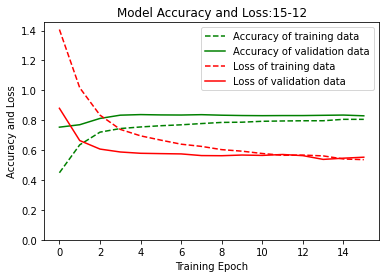


--- Check against test data ---

6584/6584 [==============================] - 0s 25us/step

Accuracy on test data: 0.81

Loss on test data: 0.50

--- Confusion matrix for test data ---



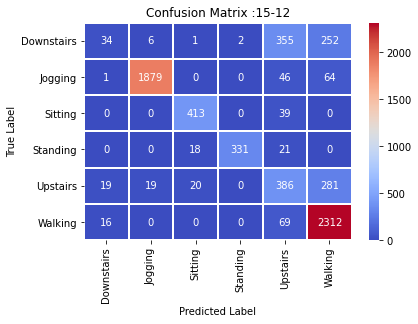


--- Classification report for test data 15:12---

              precision    recall  f1-score   support

           0       0.49      0.05      0.09       650
           1       0.99      0.94      0.97      1990
           2       0.91      0.91      0.91       452
           3       0.99      0.89      0.94       370
           4       0.42      0.53      0.47       725
           5       0.79      0.96      0.87      2397

    accuracy                           0.81      6584
   macro avg       0.77      0.72      0.71      6584
weighted avg       0.80      0.81      0.79      6584

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_23 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 66, 15)            690       
_____________________________________________________

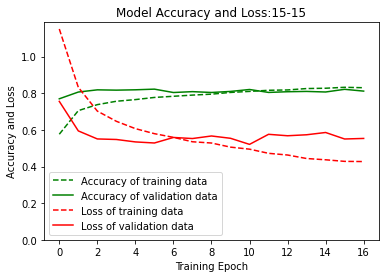


--- Check against test data ---

6584/6584 [==============================] - 0s 25us/step

Accuracy on test data: 0.84

Loss on test data: 0.49

--- Confusion matrix for test data ---



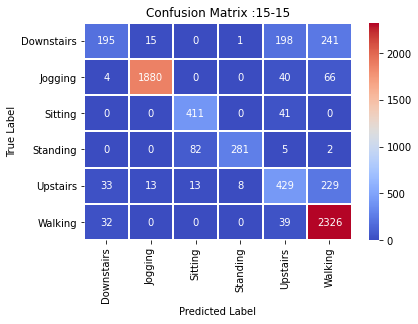


--- Classification report for test data 15:15---

              precision    recall  f1-score   support

           0       0.74      0.30      0.43       650
           1       0.99      0.94      0.96      1990
           2       0.81      0.91      0.86       452
           3       0.97      0.76      0.85       370
           4       0.57      0.59      0.58       725
           5       0.81      0.97      0.88      2397

    accuracy                           0.84      6584
   macro avg       0.81      0.75      0.76      6584
weighted avg       0.84      0.84      0.83      6584

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_24 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 63, 15)            825       
_____________________________________________________

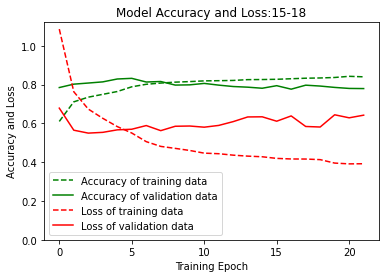


--- Check against test data ---

6584/6584 [==============================] - 0s 25us/step

Accuracy on test data: 0.83

Loss on test data: 0.47

--- Confusion matrix for test data ---



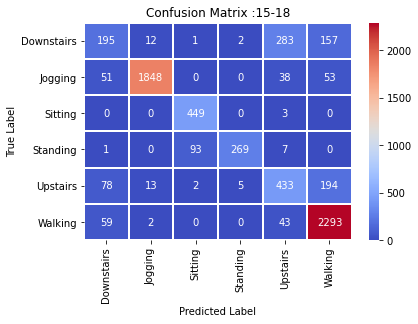


--- Classification report for test data 15:18---

              precision    recall  f1-score   support

           0       0.51      0.30      0.38       650
           1       0.99      0.93      0.96      1990
           2       0.82      0.99      0.90       452
           3       0.97      0.73      0.83       370
           4       0.54      0.60      0.57       725
           5       0.85      0.96      0.90      2397

    accuracy                           0.83      6584
   macro avg       0.78      0.75      0.76      6584
weighted avg       0.83      0.83      0.82      6584

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_25 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 61, 15)            915       
_____________________________________________________

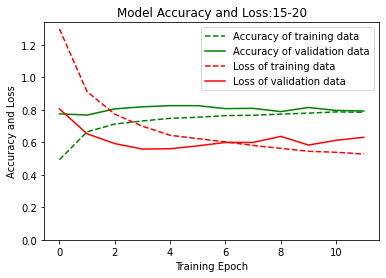


--- Check against test data ---

6584/6584 [==============================] - 0s 22us/step

Accuracy on test data: 0.83

Loss on test data: 0.51

--- Confusion matrix for test data ---



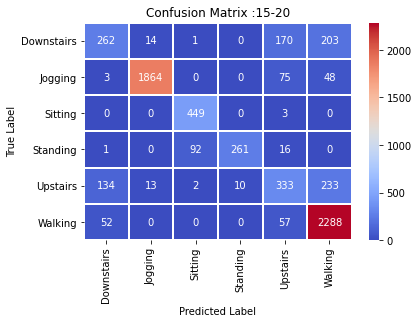


--- Classification report for test data 15:20---

              precision    recall  f1-score   support

           0       0.58      0.40      0.48       650
           1       0.99      0.94      0.96      1990
           2       0.83      0.99      0.90       452
           3       0.96      0.71      0.81       370
           4       0.51      0.46      0.48       725
           5       0.83      0.95      0.89      2397

    accuracy                           0.83      6584
   macro avg       0.78      0.74      0.75      6584
weighted avg       0.82      0.83      0.82      6584

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_26 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 79, 20)            140       
_____________________________________________________

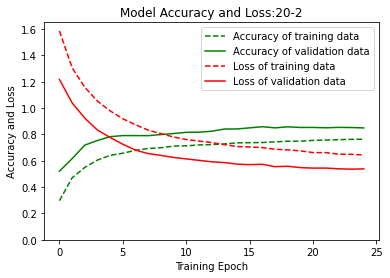


--- Check against test data ---

6584/6584 [==============================] - 0s 27us/step

Accuracy on test data: 0.76

Loss on test data: 0.62

--- Confusion matrix for test data ---



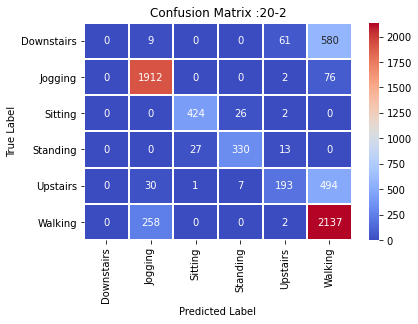


--- Classification report for test data 20:2---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.87      0.96      0.91      1990
           2       0.94      0.94      0.94       452
           3       0.91      0.89      0.90       370
           4       0.71      0.27      0.39       725
           5       0.65      0.89      0.75      2397

    accuracy                           0.76      6584
   macro avg       0.68      0.66      0.65      6584
weighted avg       0.69      0.76      0.71      6584

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_27 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 76, 20)            320       
______________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 42us/step - loss: 1.3795 - accuracy: 0.4357 - val_loss: 1.0257 - val_accuracy: 0.6239
Epoch 2/25
16694/16694 [==============================] - 1s 30us/step - loss: 1.0836 - accuracy: 0.5997 - val_loss: 0.8073 - val_accuracy: 0.7432
Epoch 3/25
16694/16694 [==============================] - 1s 34us/step - loss: 0.9400 - accuracy: 0.6656 - val_loss: 0.6947 - val_accuracy: 0.7944
Epoch 4/25
16694/16694 [==============================] - 1s 31us/step - loss: 0.8541 - accuracy: 0.6913 - val_loss: 0.6363 - val_accuracy: 0.7971
Epoch 5/25
16694/16694 [==============================] - 1s 30us/step - loss: 0.7790 - accuracy: 0.7102 - val_loss: 0.5995 - val_accuracy: 0.8009
Epoch 6/25
16694/16694 [==============================] - 1s 32us/step - loss: 0.7399 - accuracy: 0.7278 - val_loss: 0.5667 - val_accuracy: 0.8093
Epoch 7/25
16694/16694 [==============================] - 1s 31us/ste

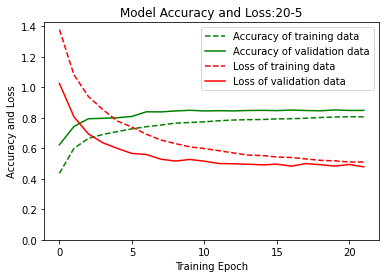


--- Check against test data ---

6584/6584 [==============================] - 0s 29us/step

Accuracy on test data: 0.81

Loss on test data: 0.49

--- Confusion matrix for test data ---



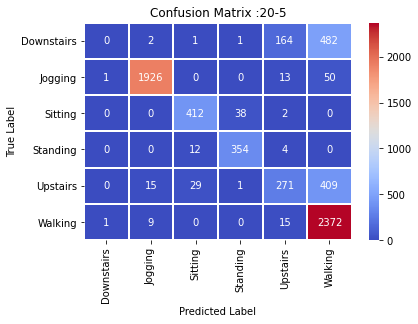


--- Classification report for test data 20:5---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.99      0.97      0.98      1990
           2       0.91      0.91      0.91       452
           3       0.90      0.96      0.93       370
           4       0.58      0.37      0.45       725
           5       0.72      0.99      0.83      2397

    accuracy                           0.81      6584
   macro avg       0.68      0.70      0.68      6584
weighted avg       0.74      0.81      0.76      6584

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_28 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 73, 20)            500       
______________________________________________________

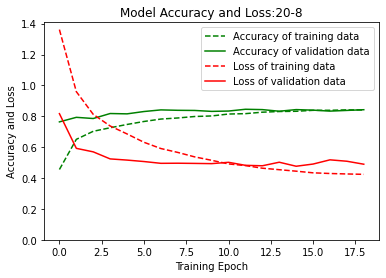


--- Check against test data ---

6584/6584 [==============================] - 0s 27us/step

Accuracy on test data: 0.87

Loss on test data: 0.41

--- Confusion matrix for test data ---



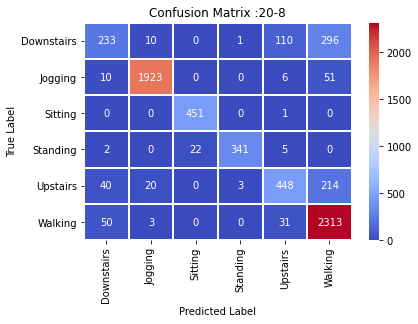


--- Classification report for test data 20:8---

              precision    recall  f1-score   support

           0       0.70      0.36      0.47       650
           1       0.98      0.97      0.97      1990
           2       0.95      1.00      0.98       452
           3       0.99      0.92      0.95       370
           4       0.75      0.62      0.68       725
           5       0.80      0.96      0.88      2397

    accuracy                           0.87      6584
   macro avg       0.86      0.80      0.82      6584
weighted avg       0.86      0.87      0.86      6584

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_29 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 71, 20)            620       
______________________________________________________

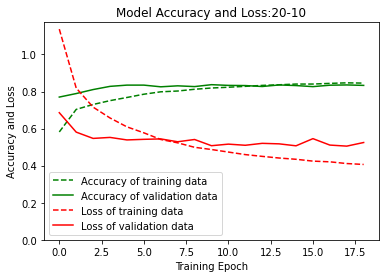


--- Check against test data ---

6584/6584 [==============================] - 0s 29us/step

Accuracy on test data: 0.85

Loss on test data: 0.43

--- Confusion matrix for test data ---



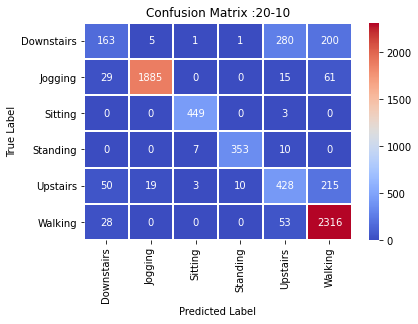


--- Classification report for test data 20:10---

              precision    recall  f1-score   support

           0       0.60      0.25      0.35       650
           1       0.99      0.95      0.97      1990
           2       0.98      0.99      0.98       452
           3       0.97      0.95      0.96       370
           4       0.54      0.59      0.57       725
           5       0.83      0.97      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.78      0.79      6584
weighted avg       0.84      0.85      0.84      6584

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_30 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 69, 20)            740       
_____________________________________________________

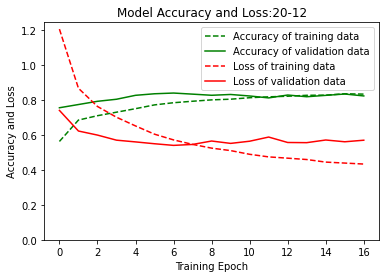


--- Check against test data ---

6584/6584 [==============================] - 0s 28us/step

Accuracy on test data: 0.85

Loss on test data: 0.45

--- Confusion matrix for test data ---



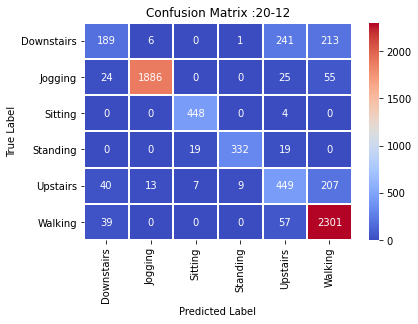


--- Classification report for test data 20:12---

              precision    recall  f1-score   support

           0       0.65      0.29      0.40       650
           1       0.99      0.95      0.97      1990
           2       0.95      0.99      0.97       452
           3       0.97      0.90      0.93       370
           4       0.56      0.62      0.59       725
           5       0.83      0.96      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.78      0.79      6584
weighted avg       0.85      0.85      0.84      6584

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_31 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 66, 20)            920       
_____________________________________________________

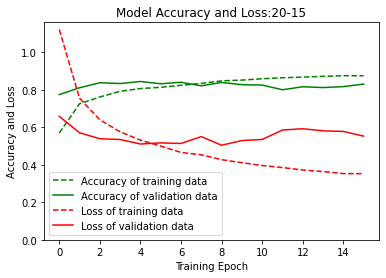


--- Check against test data ---

6584/6584 [==============================] - 0s 28us/step

Accuracy on test data: 0.87

Loss on test data: 0.45

--- Confusion matrix for test data ---



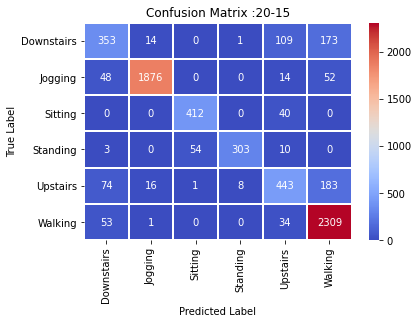


--- Classification report for test data 20:15---

              precision    recall  f1-score   support

           0       0.66      0.54      0.60       650
           1       0.98      0.94      0.96      1990
           2       0.88      0.91      0.90       452
           3       0.97      0.82      0.89       370
           4       0.68      0.61      0.64       725
           5       0.85      0.96      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.80      0.82      6584
weighted avg       0.86      0.87      0.86      6584

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_32 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 63, 20)            1100      
_____________________________________________________

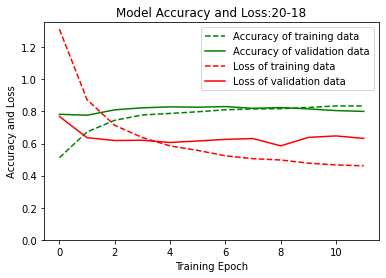


--- Check against test data ---

6584/6584 [==============================] - 0s 27us/step

Accuracy on test data: 0.83

Loss on test data: 0.55

--- Confusion matrix for test data ---



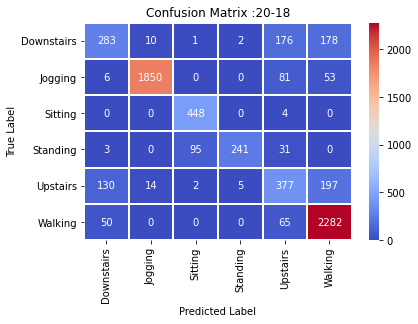


--- Classification report for test data 20:18---

              precision    recall  f1-score   support

           0       0.60      0.44      0.50       650
           1       0.99      0.93      0.96      1990
           2       0.82      0.99      0.90       452
           3       0.97      0.65      0.78       370
           4       0.51      0.52      0.52       725
           5       0.84      0.95      0.89      2397

    accuracy                           0.83      6584
   macro avg       0.79      0.75      0.76      6584
weighted avg       0.83      0.83      0.83      6584

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_33 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 61, 20)            1220      
_____________________________________________________

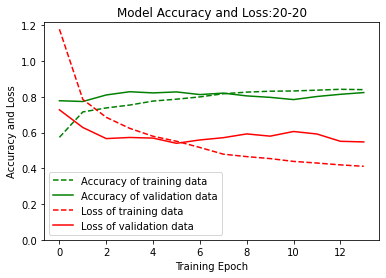


--- Check against test data ---

6584/6584 [==============================] - 0s 25us/step

Accuracy on test data: 0.82

Loss on test data: 0.53

--- Confusion matrix for test data ---



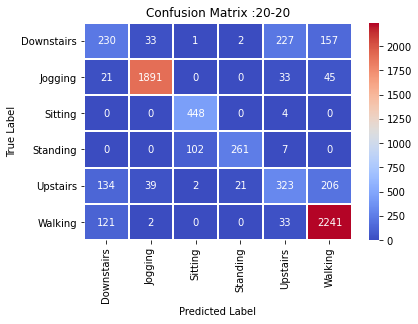


--- Classification report for test data 20:20---

              precision    recall  f1-score   support

           0       0.45      0.35      0.40       650
           1       0.96      0.95      0.96      1990
           2       0.81      0.99      0.89       452
           3       0.92      0.71      0.80       370
           4       0.52      0.45      0.48       725
           5       0.85      0.93      0.89      2397

    accuracy                           0.82      6584
   macro avg       0.75      0.73      0.73      6584
weighted avg       0.81      0.82      0.81      6584

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_34 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 79, 25)            175       
_____________________________________________________

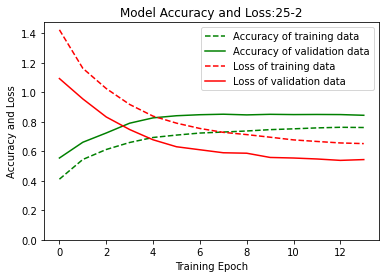


--- Check against test data ---

6584/6584 [==============================] - 0s 30us/step

Accuracy on test data: 0.77

Loss on test data: 0.61

--- Confusion matrix for test data ---



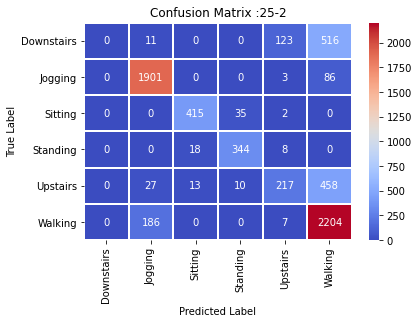


--- Classification report for test data 25:2---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.89      0.96      0.92      1990
           2       0.93      0.92      0.92       452
           3       0.88      0.93      0.91       370
           4       0.60      0.30      0.40       725
           5       0.68      0.92      0.78      2397

    accuracy                           0.77      6584
   macro avg       0.66      0.67      0.66      6584
weighted avg       0.70      0.77      0.72      6584

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_35 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 76, 25)            400       
______________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 45us/step - loss: 1.2868 - accuracy: 0.4962 - val_loss: 0.8674 - val_accuracy: 0.7357
Epoch 2/25
16694/16694 [==============================] - 1s 34us/step - loss: 0.9366 - accuracy: 0.6756 - val_loss: 0.6725 - val_accuracy: 0.7973
Epoch 3/25
16694/16694 [==============================] - 1s 32us/step - loss: 0.7903 - accuracy: 0.7172 - val_loss: 0.5809 - val_accuracy: 0.7978
Epoch 4/25
16694/16694 [==============================] - 1s 33us/step - loss: 0.7168 - accuracy: 0.7309 - val_loss: 0.5321 - val_accuracy: 0.8136
Epoch 5/25
16694/16694 [==============================] - 1s 33us/step - loss: 0.6631 - accuracy: 0.7467 - val_loss: 0.4987 - val_accuracy: 0.8366
Epoch 6/25
16694/16694 [==============================] - 1s 33us/step - loss: 0.6214 - accuracy: 0.7657 - val_loss: 0.4815 - val_accuracy: 0.8464
Epoch 7/25
16694/16694 [==============================] - 1s 33us/ste

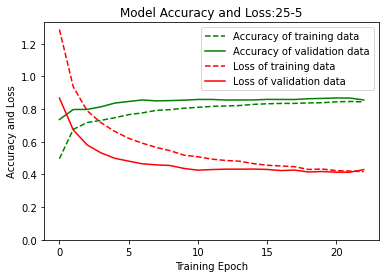


--- Check against test data ---

6584/6584 [==============================] - 0s 29us/step

Accuracy on test data: 0.84

Loss on test data: 0.44

--- Confusion matrix for test data ---



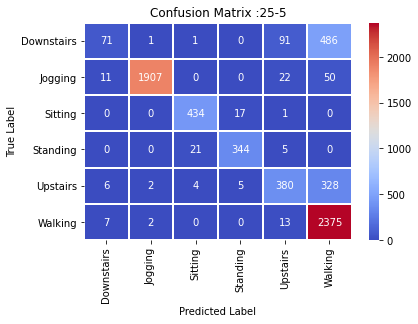


--- Classification report for test data 25:5---

              precision    recall  f1-score   support

           0       0.75      0.11      0.19       650
           1       1.00      0.96      0.98      1990
           2       0.94      0.96      0.95       452
           3       0.94      0.93      0.93       370
           4       0.74      0.52      0.61       725
           5       0.73      0.99      0.84      2397

    accuracy                           0.84      6584
   macro avg       0.85      0.75      0.75      6584
weighted avg       0.84      0.84      0.81      6584

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_36 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 73, 25)            625       
______________________________________________________

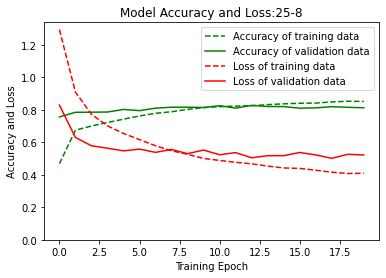


--- Check against test data ---

6584/6584 [==============================] - 0s 29us/step

Accuracy on test data: 0.85

Loss on test data: 0.42

--- Confusion matrix for test data ---



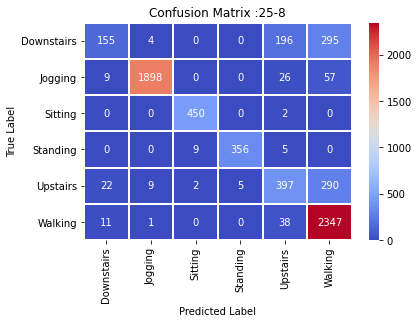


--- Classification report for test data 25:8---

              precision    recall  f1-score   support

           0       0.79      0.24      0.37       650
           1       0.99      0.95      0.97      1990
           2       0.98      1.00      0.99       452
           3       0.99      0.96      0.97       370
           4       0.60      0.55      0.57       725
           5       0.79      0.98      0.87      2397

    accuracy                           0.85      6584
   macro avg       0.85      0.78      0.79      6584
weighted avg       0.85      0.85      0.83      6584

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_37 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 71, 25)            775       
______________________________________________________

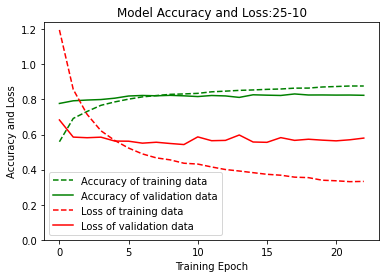


--- Check against test data ---

6584/6584 [==============================] - 0s 30us/step

Accuracy on test data: 0.88

Loss on test data: 0.39

--- Confusion matrix for test data ---



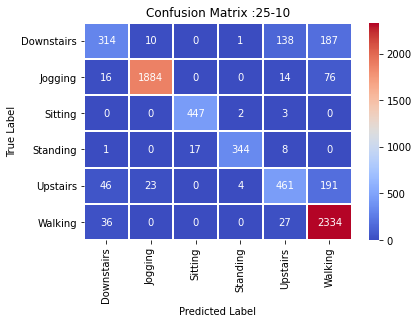


--- Classification report for test data 25:10---

              precision    recall  f1-score   support

           0       0.76      0.48      0.59       650
           1       0.98      0.95      0.96      1990
           2       0.96      0.99      0.98       452
           3       0.98      0.93      0.95       370
           4       0.71      0.64      0.67       725
           5       0.84      0.97      0.90      2397

    accuracy                           0.88      6584
   macro avg       0.87      0.83      0.84      6584
weighted avg       0.88      0.88      0.87      6584

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_38 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 69, 25)            925       
_____________________________________________________

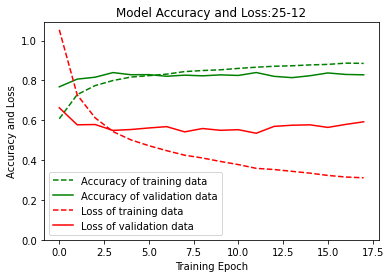


--- Check against test data ---

6584/6584 [==============================] - 0s 31us/step

Accuracy on test data: 0.89

Loss on test data: 0.39

--- Confusion matrix for test data ---



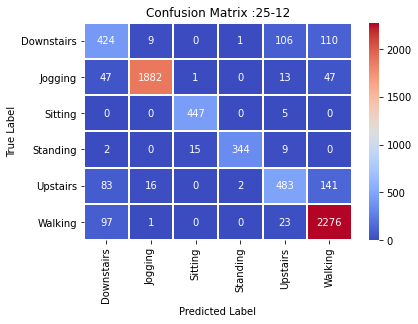


--- Classification report for test data 25:12---

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       650
           1       0.99      0.95      0.97      1990
           2       0.97      0.99      0.98       452
           3       0.99      0.93      0.96       370
           4       0.76      0.67      0.71       725
           5       0.88      0.95      0.92      2397

    accuracy                           0.89      6584
   macro avg       0.87      0.86      0.86      6584
weighted avg       0.89      0.89      0.89      6584

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_39 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 66, 25)            1150      
_____________________________________________________

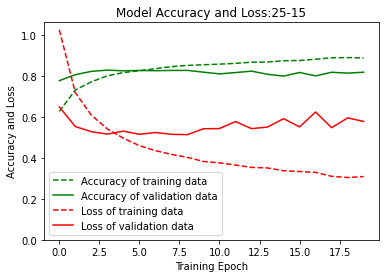


--- Check against test data ---

6584/6584 [==============================] - 0s 31us/step

Accuracy on test data: 0.86

Loss on test data: 0.44

--- Confusion matrix for test data ---



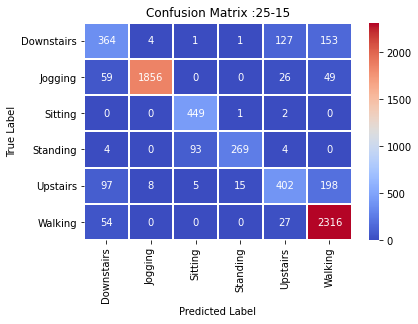


--- Classification report for test data 25:15---

              precision    recall  f1-score   support

           0       0.63      0.56      0.59       650
           1       0.99      0.93      0.96      1990
           2       0.82      0.99      0.90       452
           3       0.94      0.73      0.82       370
           4       0.68      0.55      0.61       725
           5       0.85      0.97      0.91      2397

    accuracy                           0.86      6584
   macro avg       0.82      0.79      0.80      6584
weighted avg       0.86      0.86      0.85      6584

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_40 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_79 (Conv1D)           (None, 63, 25)            1375      
_____________________________________________________

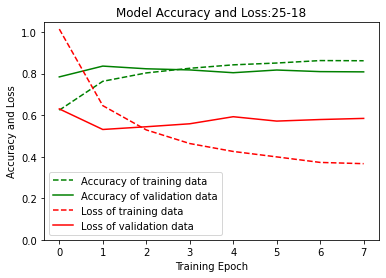


--- Check against test data ---

6584/6584 [==============================] - 0s 30us/step

Accuracy on test data: 0.86

Loss on test data: 0.48

--- Confusion matrix for test data ---



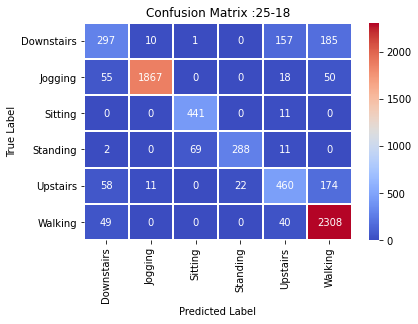


--- Classification report for test data 25:18---

              precision    recall  f1-score   support

           0       0.64      0.46      0.53       650
           1       0.99      0.94      0.96      1990
           2       0.86      0.98      0.92       452
           3       0.93      0.78      0.85       370
           4       0.66      0.63      0.65       725
           5       0.85      0.96      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.82      0.79      0.80      6584
weighted avg       0.86      0.86      0.85      6584

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_41 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 61, 25)            1525      
_____________________________________________________

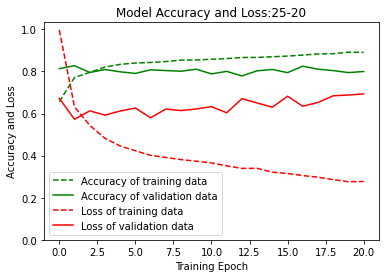


--- Check against test data ---

6584/6584 [==============================] - 0s 26us/step

Accuracy on test data: 0.85

Loss on test data: 0.55

--- Confusion matrix for test data ---



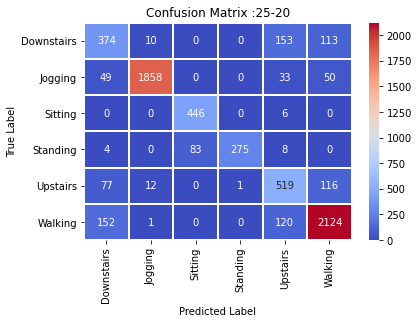


--- Classification report for test data 25:20---

              precision    recall  f1-score   support

           0       0.57      0.58      0.57       650
           1       0.99      0.93      0.96      1990
           2       0.84      0.99      0.91       452
           3       1.00      0.74      0.85       370
           4       0.62      0.72      0.66       725
           5       0.88      0.89      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.81      0.81      6584
weighted avg       0.86      0.85      0.85      6584

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_42 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 79, 35)            245       
_____________________________________________________

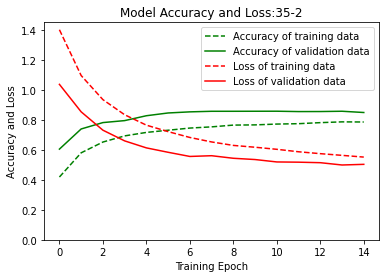


--- Check against test data ---

6584/6584 [==============================] - 0s 31us/step

Accuracy on test data: 0.77

Loss on test data: 0.56

--- Confusion matrix for test data ---



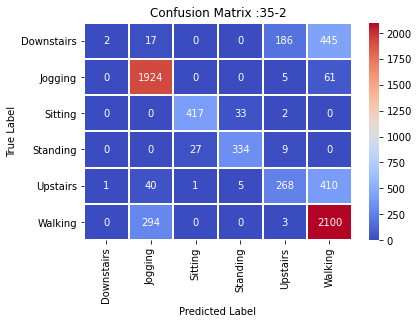


--- Classification report for test data 35:2---

              precision    recall  f1-score   support

           0       0.67      0.00      0.01       650
           1       0.85      0.97      0.90      1990
           2       0.94      0.92      0.93       452
           3       0.90      0.90      0.90       370
           4       0.57      0.37      0.45       725
           5       0.70      0.88      0.78      2397

    accuracy                           0.77      6584
   macro avg       0.77      0.67      0.66      6584
weighted avg       0.75      0.77      0.72      6584

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_43 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_85 (Conv1D)           (None, 76, 35)            560       
______________________________________________________

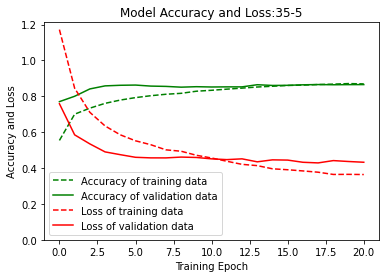


--- Check against test data ---

6584/6584 [==============================] - 0s 34us/step

Accuracy on test data: 0.87

Loss on test data: 0.39

--- Confusion matrix for test data ---



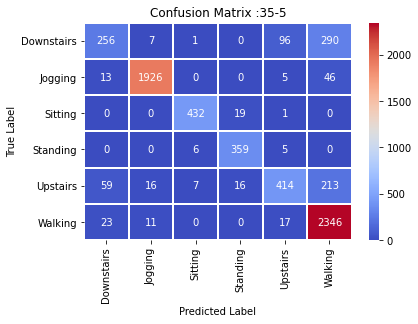


--- Classification report for test data 35:5---

              precision    recall  f1-score   support

           0       0.73      0.39      0.51       650
           1       0.98      0.97      0.98      1990
           2       0.97      0.96      0.96       452
           3       0.91      0.97      0.94       370
           4       0.77      0.57      0.66       725
           5       0.81      0.98      0.89      2397

    accuracy                           0.87      6584
   macro avg       0.86      0.81      0.82      6584
weighted avg       0.87      0.87      0.86      6584

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_44 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_87 (Conv1D)           (None, 73, 35)            875       
______________________________________________________

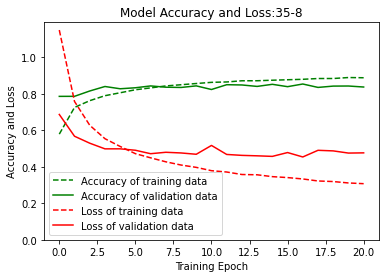


--- Check against test data ---

6584/6584 [==============================] - 0s 33us/step

Accuracy on test data: 0.88

Loss on test data: 0.39

--- Confusion matrix for test data ---



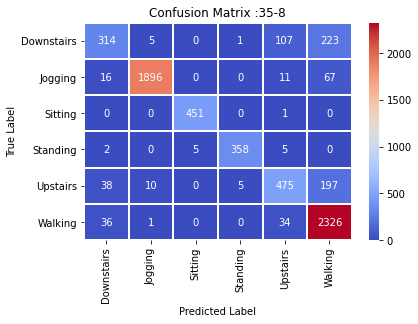


--- Classification report for test data 35:8---

              precision    recall  f1-score   support

           0       0.77      0.48      0.59       650
           1       0.99      0.95      0.97      1990
           2       0.99      1.00      0.99       452
           3       0.98      0.97      0.98       370
           4       0.75      0.66      0.70       725
           5       0.83      0.97      0.89      2397

    accuracy                           0.88      6584
   macro avg       0.89      0.84      0.85      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_45 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 71, 35)            1085      
______________________________________________________

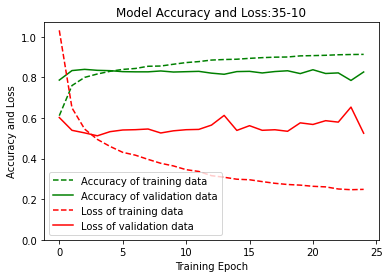


--- Check against test data ---

6584/6584 [==============================] - 0s 36us/step

Accuracy on test data: 0.90

Loss on test data: 0.33

--- Confusion matrix for test data ---



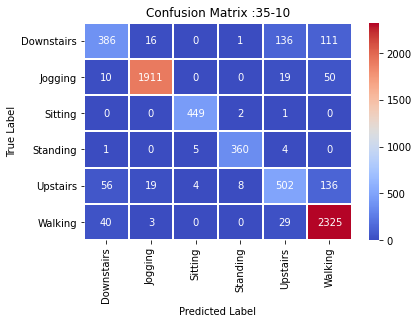


--- Classification report for test data 35:10---

              precision    recall  f1-score   support

           0       0.78      0.59      0.68       650
           1       0.98      0.96      0.97      1990
           2       0.98      0.99      0.99       452
           3       0.97      0.97      0.97       370
           4       0.73      0.69      0.71       725
           5       0.89      0.97      0.93      2397

    accuracy                           0.90      6584
   macro avg       0.89      0.86      0.87      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_46 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 69, 35)            1295      
_____________________________________________________

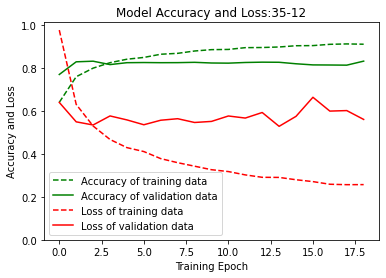


--- Check against test data ---

6584/6584 [==============================] - 0s 35us/step

Accuracy on test data: 0.89

Loss on test data: 0.35

--- Confusion matrix for test data ---



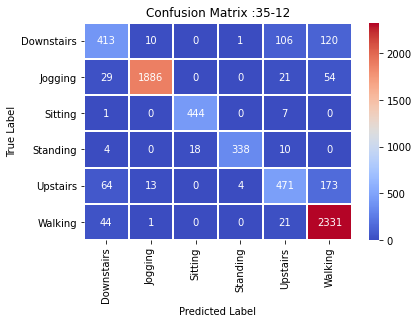


--- Classification report for test data 35:12---

              precision    recall  f1-score   support

           0       0.74      0.64      0.69       650
           1       0.99      0.95      0.97      1990
           2       0.96      0.98      0.97       452
           3       0.99      0.91      0.95       370
           4       0.74      0.65      0.69       725
           5       0.87      0.97      0.92      2397

    accuracy                           0.89      6584
   macro avg       0.88      0.85      0.86      6584
weighted avg       0.89      0.89      0.89      6584

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_47 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 66, 35)            1610      
_____________________________________________________

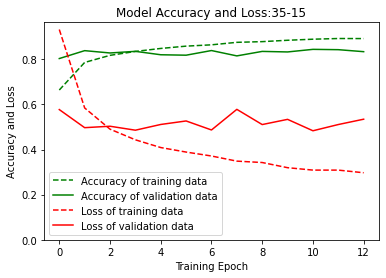


--- Check against test data ---

6584/6584 [==============================] - 0s 34us/step

Accuracy on test data: 0.88

Loss on test data: 0.42

--- Confusion matrix for test data ---



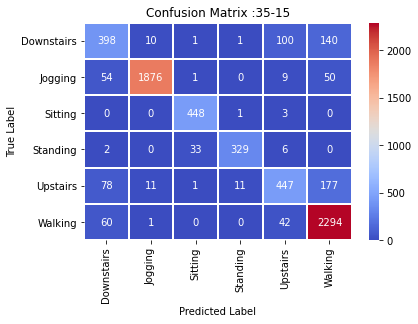


--- Classification report for test data 35:15---

              precision    recall  f1-score   support

           0       0.67      0.61      0.64       650
           1       0.99      0.94      0.97      1990
           2       0.93      0.99      0.96       452
           3       0.96      0.89      0.92       370
           4       0.74      0.62      0.67       725
           5       0.86      0.96      0.91      2397

    accuracy                           0.88      6584
   macro avg       0.86      0.83      0.84      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_48 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_95 (Conv1D)           (None, 63, 35)            1925      
_____________________________________________________

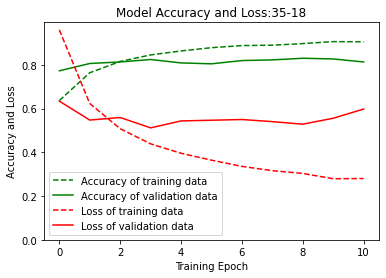


--- Check against test data ---

6584/6584 [==============================] - 0s 39us/step

Accuracy on test data: 0.87

Loss on test data: 0.45

--- Confusion matrix for test data ---



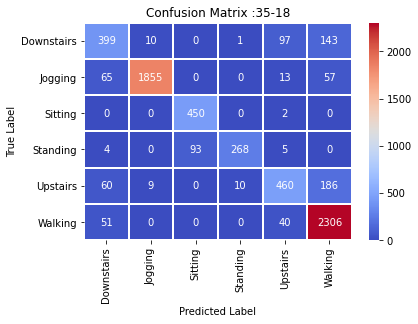


--- Classification report for test data 35:18---

              precision    recall  f1-score   support

           0       0.69      0.61      0.65       650
           1       0.99      0.93      0.96      1990
           2       0.83      1.00      0.90       452
           3       0.96      0.72      0.83       370
           4       0.75      0.63      0.69       725
           5       0.86      0.96      0.91      2397

    accuracy                           0.87      6584
   macro avg       0.85      0.81      0.82      6584
weighted avg       0.87      0.87      0.87      6584

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_49 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_97 (Conv1D)           (None, 61, 35)            2135      
_____________________________________________________

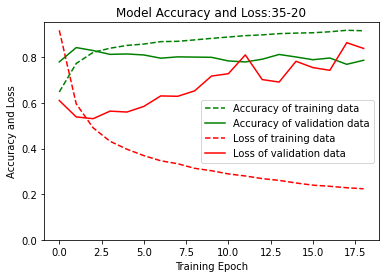


--- Check against test data ---

6584/6584 [==============================] - 0s 27us/step

Accuracy on test data: 0.87

Loss on test data: 0.53

--- Confusion matrix for test data ---



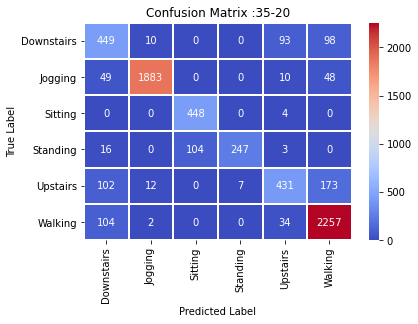


--- Classification report for test data 35:20---

              precision    recall  f1-score   support

           0       0.62      0.69      0.66       650
           1       0.99      0.95      0.97      1990
           2       0.81      0.99      0.89       452
           3       0.97      0.67      0.79       370
           4       0.75      0.59      0.66       725
           5       0.88      0.94      0.91      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.81      0.81      6584
weighted avg       0.87      0.87      0.87      6584

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_50 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 79, 50)            350       
_____________________________________________________

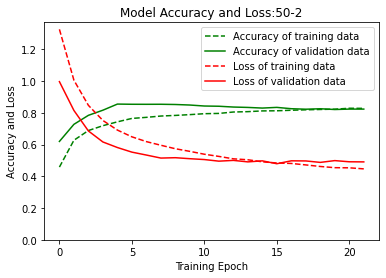


--- Check against test data ---

6584/6584 [==============================] - 0s 36us/step

Accuracy on test data: 0.79

Loss on test data: 0.50

--- Confusion matrix for test data ---



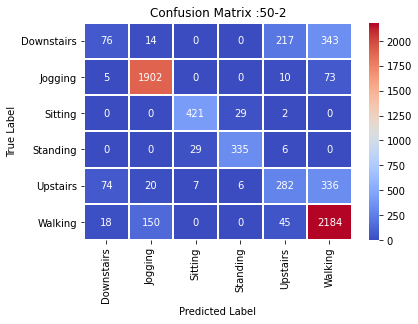


--- Classification report for test data 50:2---

              precision    recall  f1-score   support

           0       0.44      0.12      0.18       650
           1       0.91      0.96      0.93      1990
           2       0.92      0.93      0.93       452
           3       0.91      0.91      0.91       370
           4       0.50      0.39      0.44       725
           5       0.74      0.91      0.82      2397

    accuracy                           0.79      6584
   macro avg       0.74      0.70      0.70      6584
weighted avg       0.76      0.79      0.76      6584

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_51 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 76, 50)            800       
______________________________________________________

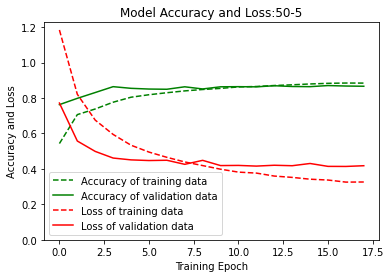


--- Check against test data ---

6584/6584 [==============================] - 0s 38us/step

Accuracy on test data: 0.88

Loss on test data: 0.40

--- Confusion matrix for test data ---



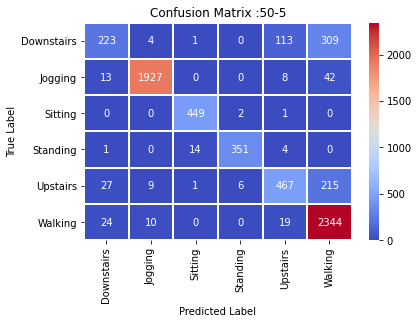


--- Classification report for test data 50:5---

              precision    recall  f1-score   support

           0       0.77      0.34      0.48       650
           1       0.99      0.97      0.98      1990
           2       0.97      0.99      0.98       452
           3       0.98      0.95      0.96       370
           4       0.76      0.64      0.70       725
           5       0.81      0.98      0.88      2397

    accuracy                           0.88      6584
   macro avg       0.88      0.81      0.83      6584
weighted avg       0.87      0.88      0.86      6584

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_52 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 73, 50)            1250      
______________________________________________________

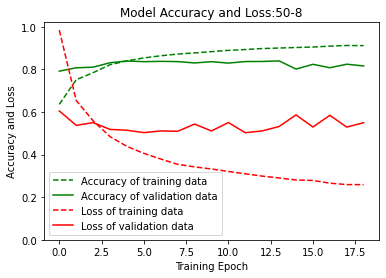


--- Check against test data ---

6584/6584 [==============================] - 0s 37us/step

Accuracy on test data: 0.90

Loss on test data: 0.35

--- Confusion matrix for test data ---



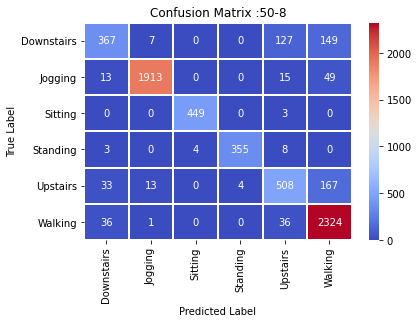


--- Classification report for test data 50:8---

              precision    recall  f1-score   support

           0       0.81      0.56      0.67       650
           1       0.99      0.96      0.98      1990
           2       0.99      0.99      0.99       452
           3       0.99      0.96      0.97       370
           4       0.73      0.70      0.71       725
           5       0.86      0.97      0.91      2397

    accuracy                           0.90      6584
   macro avg       0.90      0.86      0.87      6584
weighted avg       0.90      0.90      0.89      6584

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_53 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_105 (Conv1D)          (None, 71, 50)            1550      
______________________________________________________

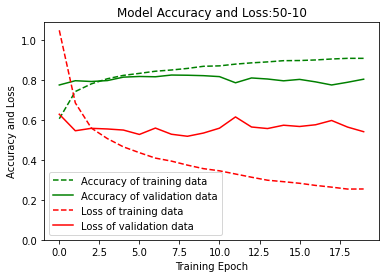


--- Check against test data ---

6584/6584 [==============================] - 0s 38us/step

Accuracy on test data: 0.89

Loss on test data: 0.37

--- Confusion matrix for test data ---



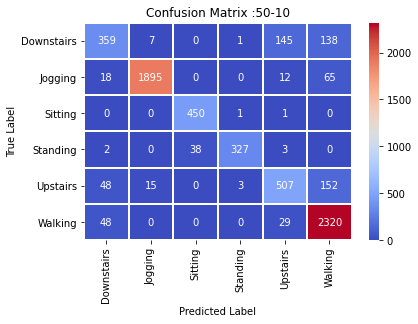


--- Classification report for test data 50:10---

              precision    recall  f1-score   support

           0       0.76      0.55      0.64       650
           1       0.99      0.95      0.97      1990
           2       0.92      1.00      0.96       452
           3       0.98      0.88      0.93       370
           4       0.73      0.70      0.71       725
           5       0.87      0.97      0.91      2397

    accuracy                           0.89      6584
   macro avg       0.87      0.84      0.85      6584
weighted avg       0.89      0.89      0.89      6584

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_54 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_107 (Conv1D)          (None, 69, 50)            1850      
_____________________________________________________

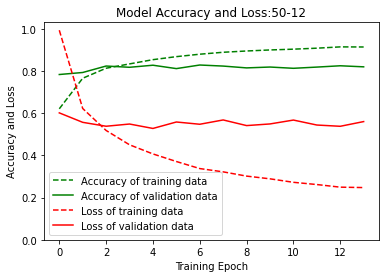


--- Check against test data ---

6584/6584 [==============================] - 0s 38us/step

Accuracy on test data: 0.90

Loss on test data: 0.37

--- Confusion matrix for test data ---



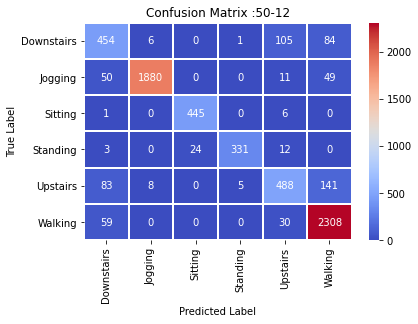


--- Classification report for test data 50:12---

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       650
           1       0.99      0.94      0.97      1990
           2       0.95      0.98      0.97       452
           3       0.98      0.89      0.94       370
           4       0.75      0.67      0.71       725
           5       0.89      0.96      0.93      2397

    accuracy                           0.90      6584
   macro avg       0.88      0.86      0.87      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_55 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_109 (Conv1D)          (None, 66, 50)            2300      
_____________________________________________________

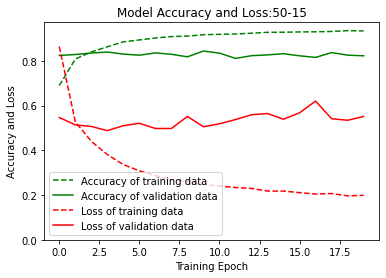


--- Check against test data ---

6584/6584 [==============================] - 0s 37us/step

Accuracy on test data: 0.89

Loss on test data: 0.44

--- Confusion matrix for test data ---



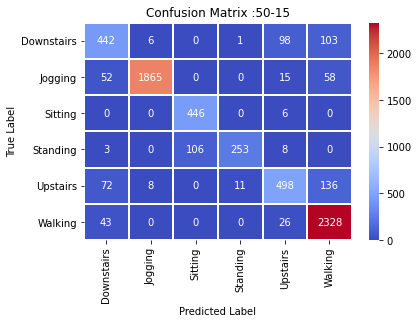


--- Classification report for test data 50:15---

              precision    recall  f1-score   support

           0       0.72      0.68      0.70       650
           1       0.99      0.94      0.96      1990
           2       0.81      0.99      0.89       452
           3       0.95      0.68      0.80       370
           4       0.76      0.69      0.72       725
           5       0.89      0.97      0.93      2397

    accuracy                           0.89      6584
   macro avg       0.85      0.82      0.83      6584
weighted avg       0.89      0.89      0.88      6584

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_56 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 63, 50)            2750      
_____________________________________________________

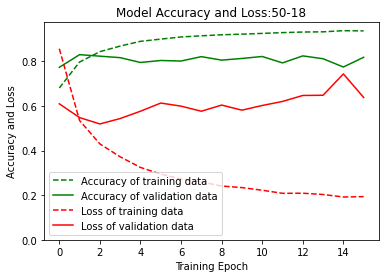


--- Check against test data ---

6584/6584 [==============================] - 0s 37us/step

Accuracy on test data: 0.87

Loss on test data: 0.46

--- Confusion matrix for test data ---



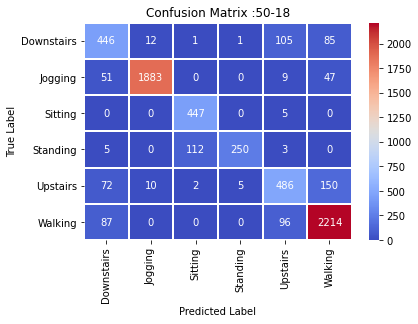


--- Classification report for test data 50:18---

              precision    recall  f1-score   support

           0       0.67      0.69      0.68       650
           1       0.99      0.95      0.97      1990
           2       0.80      0.99      0.88       452
           3       0.98      0.68      0.80       370
           4       0.69      0.67      0.68       725
           5       0.89      0.92      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.82      0.82      6584
weighted avg       0.87      0.87      0.87      6584

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_57 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_113 (Conv1D)          (None, 61, 50)            3050      
_____________________________________________________

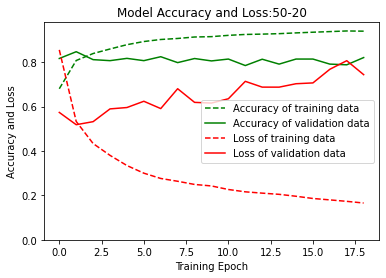


--- Check against test data ---

6584/6584 [==============================] - 0s 31us/step

Accuracy on test data: 0.88

Loss on test data: 0.60

--- Confusion matrix for test data ---



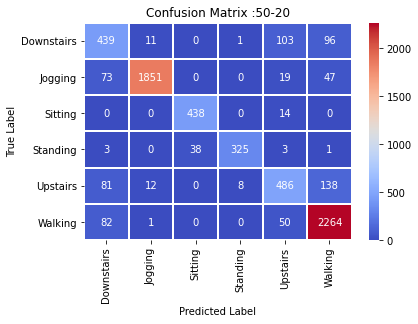


--- Classification report for test data 50:20---

              precision    recall  f1-score   support

           0       0.65      0.68      0.66       650
           1       0.99      0.93      0.96      1990
           2       0.92      0.97      0.94       452
           3       0.97      0.88      0.92       370
           4       0.72      0.67      0.69       725
           5       0.89      0.94      0.92      2397

    accuracy                           0.88      6584
   macro avg       0.86      0.84      0.85      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_58 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_115 (Conv1D)          (None, 79, 65)            455       
_____________________________________________________

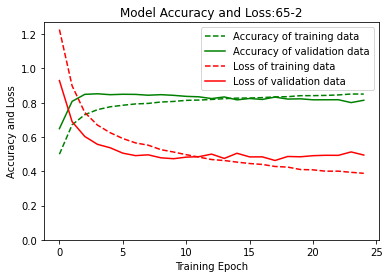


--- Check against test data ---

6584/6584 [==============================] - 0s 37us/step

Accuracy on test data: 0.78

Loss on test data: 0.60

--- Confusion matrix for test data ---



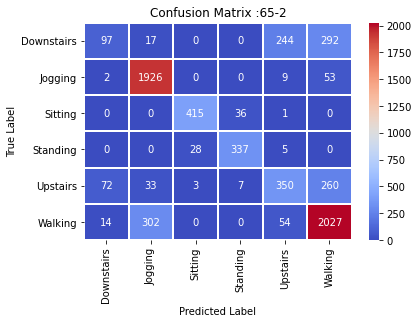


--- Classification report for test data 65:2---

              precision    recall  f1-score   support

           0       0.52      0.15      0.23       650
           1       0.85      0.97      0.90      1990
           2       0.93      0.92      0.92       452
           3       0.89      0.91      0.90       370
           4       0.53      0.48      0.50       725
           5       0.77      0.85      0.81      2397

    accuracy                           0.78      6584
   macro avg       0.75      0.71      0.71      6584
weighted avg       0.76      0.78      0.76      6584

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_59 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_117 (Conv1D)          (None, 76, 65)            1040      
______________________________________________________

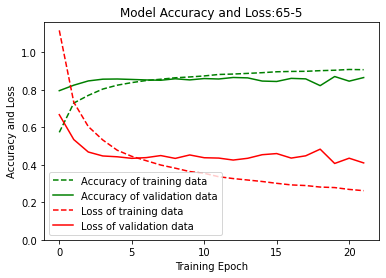


--- Check against test data ---

6584/6584 [==============================] - 0s 41us/step

Accuracy on test data: 0.89

Loss on test data: 0.34

--- Confusion matrix for test data ---



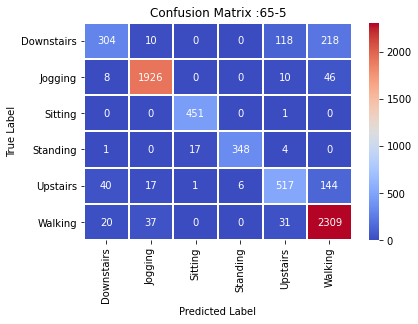


--- Classification report for test data 65:5---

              precision    recall  f1-score   support

           0       0.82      0.47      0.59       650
           1       0.97      0.97      0.97      1990
           2       0.96      1.00      0.98       452
           3       0.98      0.94      0.96       370
           4       0.76      0.71      0.74       725
           5       0.85      0.96      0.90      2397

    accuracy                           0.89      6584
   macro avg       0.89      0.84      0.86      6584
weighted avg       0.89      0.89      0.88      6584

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_60 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_119 (Conv1D)          (None, 73, 65)            1625      
______________________________________________________

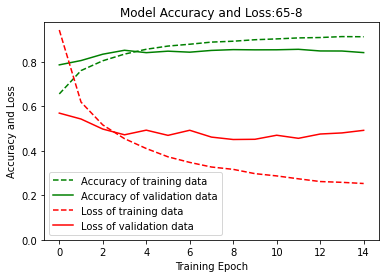


--- Check against test data ---

6584/6584 [==============================] - 0s 41us/step

Accuracy on test data: 0.90

Loss on test data: 0.36

--- Confusion matrix for test data ---



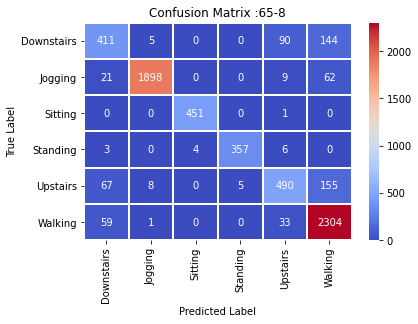


--- Classification report for test data 65:8---

              precision    recall  f1-score   support

           0       0.73      0.63      0.68       650
           1       0.99      0.95      0.97      1990
           2       0.99      1.00      0.99       452
           3       0.99      0.96      0.98       370
           4       0.78      0.68      0.72       725
           5       0.86      0.96      0.91      2397

    accuracy                           0.90      6584
   macro avg       0.89      0.86      0.88      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_61 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 71, 65)            2015      
______________________________________________________

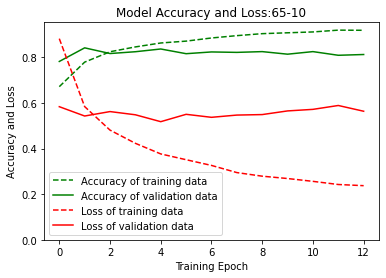


--- Check against test data ---

6584/6584 [==============================] - 0s 44us/step

Accuracy on test data: 0.90

Loss on test data: 0.33

--- Confusion matrix for test data ---



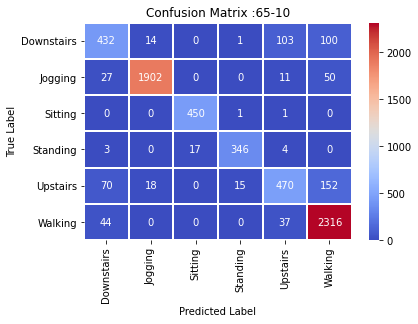


--- Classification report for test data 65:10---

              precision    recall  f1-score   support

           0       0.75      0.66      0.70       650
           1       0.98      0.96      0.97      1990
           2       0.96      1.00      0.98       452
           3       0.95      0.94      0.94       370
           4       0.75      0.65      0.70       725
           5       0.88      0.97      0.92      2397

    accuracy                           0.90      6584
   macro avg       0.88      0.86      0.87      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_62 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 69, 65)            2405      
_____________________________________________________

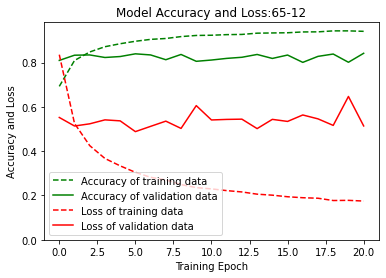


--- Check against test data ---

6584/6584 [==============================] - 0s 44us/step

Accuracy on test data: 0.90

Loss on test data: 0.37

--- Confusion matrix for test data ---



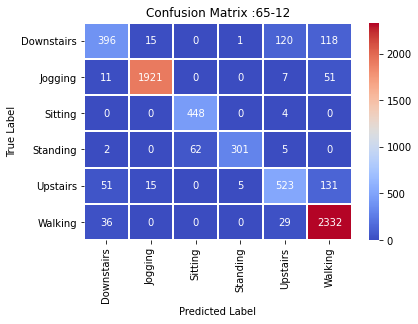


--- Classification report for test data 65:12---

              precision    recall  f1-score   support

           0       0.80      0.61      0.69       650
           1       0.98      0.97      0.97      1990
           2       0.88      0.99      0.93       452
           3       0.98      0.81      0.89       370
           4       0.76      0.72      0.74       725
           5       0.89      0.97      0.93      2397

    accuracy                           0.90      6584
   macro avg       0.88      0.85      0.86      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_63 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_125 (Conv1D)          (None, 66, 65)            2990      
_____________________________________________________

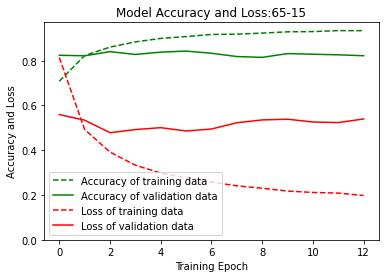


--- Check against test data ---

6584/6584 [==============================] - 0s 44us/step

Accuracy on test data: 0.88

Loss on test data: 0.44

--- Confusion matrix for test data ---



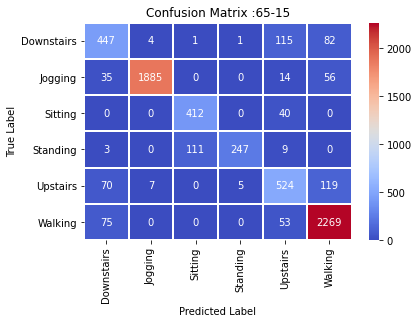


--- Classification report for test data 65:15---

              precision    recall  f1-score   support

           0       0.71      0.69      0.70       650
           1       0.99      0.95      0.97      1990
           2       0.79      0.91      0.84       452
           3       0.98      0.67      0.79       370
           4       0.69      0.72      0.71       725
           5       0.90      0.95      0.92      2397

    accuracy                           0.88      6584
   macro avg       0.84      0.81      0.82      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_64 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 63, 65)            3575      
_____________________________________________________

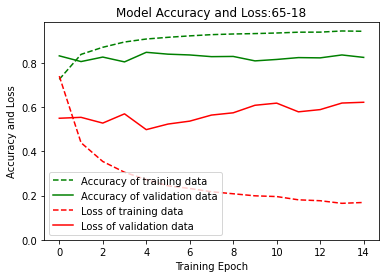


--- Check against test data ---

6584/6584 [==============================] - 0s 42us/step

Accuracy on test data: 0.87

Loss on test data: 0.53

--- Confusion matrix for test data ---



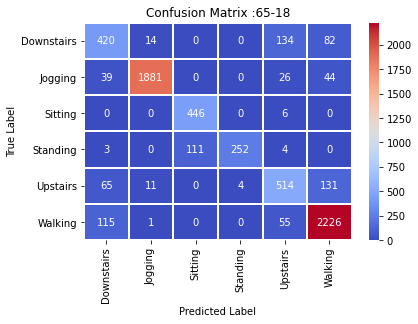


--- Classification report for test data 65:18---

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       650
           1       0.99      0.95      0.97      1990
           2       0.80      0.99      0.88       452
           3       0.98      0.68      0.81       370
           4       0.70      0.71      0.70       725
           5       0.90      0.93      0.91      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.82      0.82      6584
weighted avg       0.88      0.87      0.87      6584

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_65 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 61, 65)            3965      
_____________________________________________________

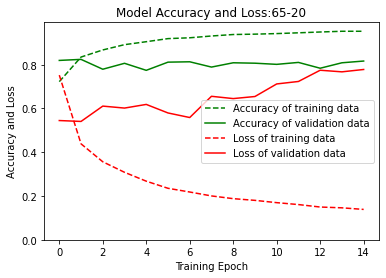


--- Check against test data ---

6584/6584 [==============================] - 0s 34us/step

Accuracy on test data: 0.87

Loss on test data: 0.56

--- Confusion matrix for test data ---



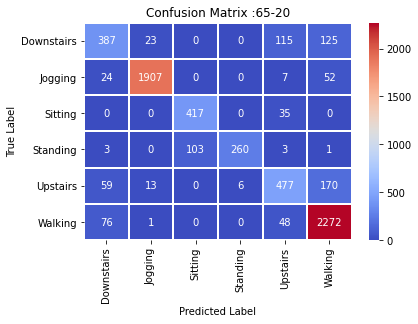


--- Classification report for test data 65:20---

              precision    recall  f1-score   support

           0       0.70      0.60      0.65       650
           1       0.98      0.96      0.97      1990
           2       0.80      0.92      0.86       452
           3       0.98      0.70      0.82       370
           4       0.70      0.66      0.68       725
           5       0.87      0.95      0.91      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.80      0.81      6584
weighted avg       0.87      0.87      0.87      6584

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_66 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_131 (Conv1D)          (None, 79, 75)            525       
_____________________________________________________

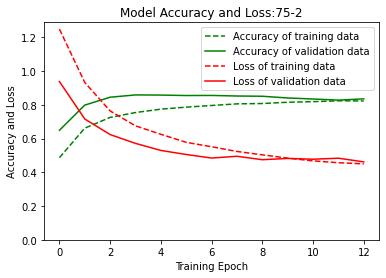


--- Check against test data ---

6584/6584 [==============================] - 0s 39us/step

Accuracy on test data: 0.78

Loss on test data: 0.56

--- Confusion matrix for test data ---



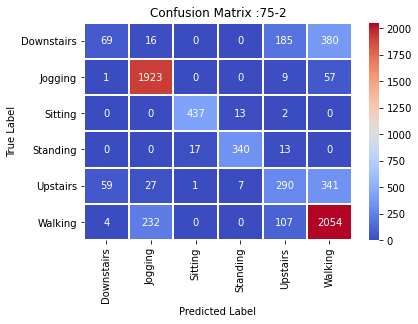


--- Classification report for test data 75:2---

              precision    recall  f1-score   support

           0       0.52      0.11      0.18       650
           1       0.87      0.97      0.92      1990
           2       0.96      0.97      0.96       452
           3       0.94      0.92      0.93       370
           4       0.48      0.40      0.44       725
           5       0.73      0.86      0.79      2397

    accuracy                           0.78      6584
   macro avg       0.75      0.70      0.70      6584
weighted avg       0.75      0.78      0.75      6584

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_67 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 76, 75)            1200      
______________________________________________________

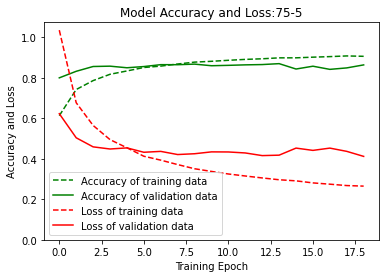


--- Check against test data ---

6584/6584 [==============================] - 0s 44us/step

Accuracy on test data: 0.89

Loss on test data: 0.35

--- Confusion matrix for test data ---



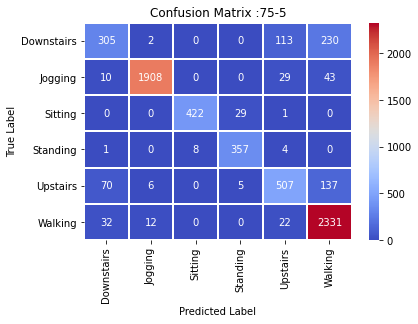


--- Classification report for test data 75:5---

              precision    recall  f1-score   support

           0       0.73      0.47      0.57       650
           1       0.99      0.96      0.97      1990
           2       0.98      0.93      0.96       452
           3       0.91      0.96      0.94       370
           4       0.75      0.70      0.72       725
           5       0.85      0.97      0.91      2397

    accuracy                           0.89      6584
   macro avg       0.87      0.83      0.85      6584
weighted avg       0.88      0.89      0.88      6584

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_68 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 73, 75)            1875      
______________________________________________________

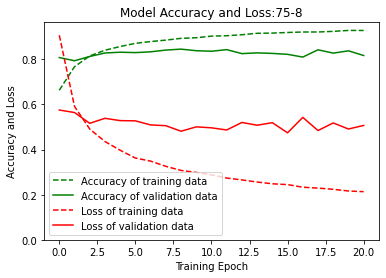


--- Check against test data ---

6584/6584 [==============================] - 0s 49us/step

Accuracy on test data: 0.90

Loss on test data: 0.33

--- Confusion matrix for test data ---



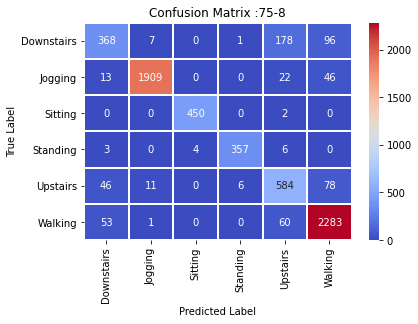


--- Classification report for test data 75:8---

              precision    recall  f1-score   support

           0       0.76      0.57      0.65       650
           1       0.99      0.96      0.97      1990
           2       0.99      1.00      0.99       452
           3       0.98      0.96      0.97       370
           4       0.69      0.81      0.74       725
           5       0.91      0.95      0.93      2397

    accuracy                           0.90      6584
   macro avg       0.89      0.87      0.88      6584
weighted avg       0.91      0.90      0.90      6584

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_69 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_137 (Conv1D)          (None, 71, 75)            2325      
______________________________________________________

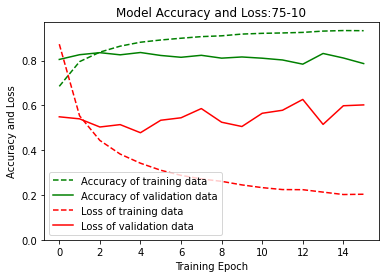


--- Check against test data ---

6584/6584 [==============================] - 0s 47us/step

Accuracy on test data: 0.91

Loss on test data: 0.31

--- Confusion matrix for test data ---



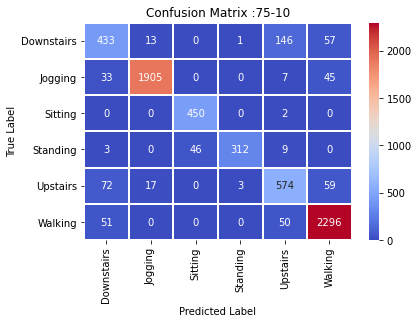


--- Classification report for test data 75:10---

              precision    recall  f1-score   support

           0       0.73      0.67      0.70       650
           1       0.98      0.96      0.97      1990
           2       0.91      1.00      0.95       452
           3       0.99      0.84      0.91       370
           4       0.73      0.79      0.76       725
           5       0.93      0.96      0.95      2397

    accuracy                           0.91      6584
   macro avg       0.88      0.87      0.87      6584
weighted avg       0.91      0.91      0.91      6584

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_70 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_139 (Conv1D)          (None, 69, 75)            2775      
_____________________________________________________

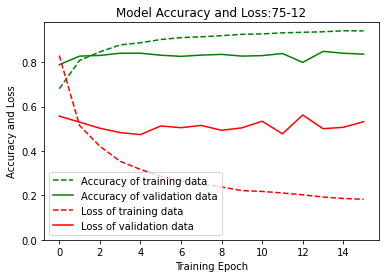


--- Check against test data ---

6584/6584 [==============================] - 0s 47us/step

Accuracy on test data: 0.90

Loss on test data: 0.35

--- Confusion matrix for test data ---



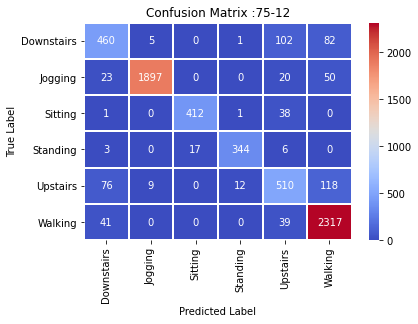


--- Classification report for test data 75:12---

              precision    recall  f1-score   support

           0       0.76      0.71      0.73       650
           1       0.99      0.95      0.97      1990
           2       0.96      0.91      0.94       452
           3       0.96      0.93      0.95       370
           4       0.71      0.70      0.71       725
           5       0.90      0.97      0.93      2397

    accuracy                           0.90      6584
   macro avg       0.88      0.86      0.87      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_71 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 66, 75)            3450      
_____________________________________________________

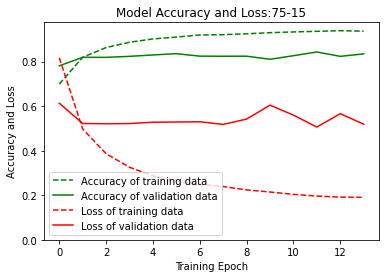


--- Check against test data ---

6584/6584 [==============================] - 0s 46us/step

Accuracy on test data: 0.88

Loss on test data: 0.40

--- Confusion matrix for test data ---



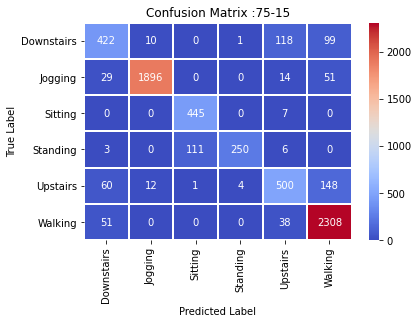


--- Classification report for test data 75:15---

              precision    recall  f1-score   support

           0       0.75      0.65      0.69       650
           1       0.99      0.95      0.97      1990
           2       0.80      0.98      0.88       452
           3       0.98      0.68      0.80       370
           4       0.73      0.69      0.71       725
           5       0.89      0.96      0.92      2397

    accuracy                           0.88      6584
   macro avg       0.86      0.82      0.83      6584
weighted avg       0.89      0.88      0.88      6584

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_72 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_143 (Conv1D)          (None, 63, 75)            4125      
_____________________________________________________

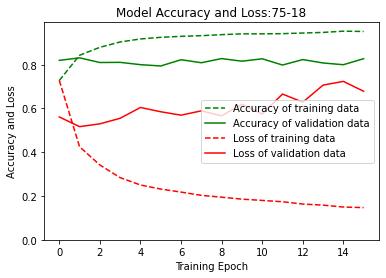


--- Check against test data ---

6584/6584 [==============================] - 0s 41us/step

Accuracy on test data: 0.88

Loss on test data: 0.56

--- Confusion matrix for test data ---



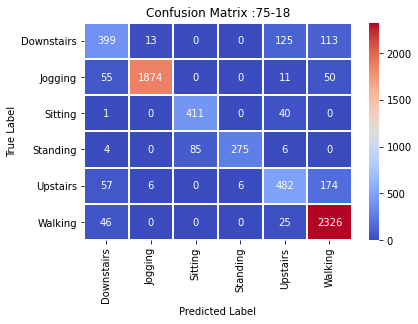


--- Classification report for test data 75:18---

              precision    recall  f1-score   support

           0       0.71      0.61      0.66       650
           1       0.99      0.94      0.97      1990
           2       0.83      0.91      0.87       452
           3       0.98      0.74      0.84       370
           4       0.70      0.66      0.68       725
           5       0.87      0.97      0.92      2397

    accuracy                           0.88      6584
   macro avg       0.85      0.81      0.82      6584
weighted avg       0.88      0.88      0.87      6584

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_73 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_145 (Conv1D)          (None, 61, 75)            4575      
_____________________________________________________

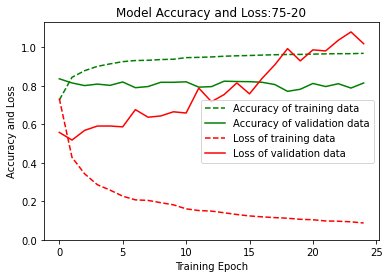


--- Check against test data ---

6584/6584 [==============================] - 0s 34us/step

Accuracy on test data: 0.88

Loss on test data: 0.74

--- Confusion matrix for test data ---



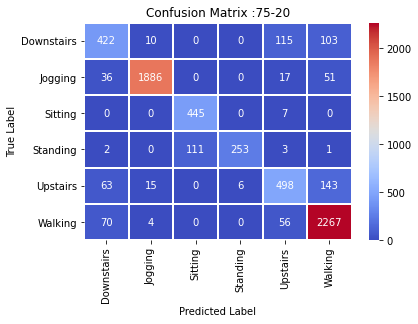


--- Classification report for test data 75:20---

              precision    recall  f1-score   support

           0       0.71      0.65      0.68       650
           1       0.98      0.95      0.97      1990
           2       0.80      0.98      0.88       452
           3       0.98      0.68      0.80       370
           4       0.72      0.69      0.70       725
           5       0.88      0.95      0.91      2397

    accuracy                           0.88      6584
   macro avg       0.85      0.82      0.82      6584
weighted avg       0.88      0.88      0.87      6584

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_74 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_147 (Conv1D)          (None, 79, 85)            595       
_____________________________________________________

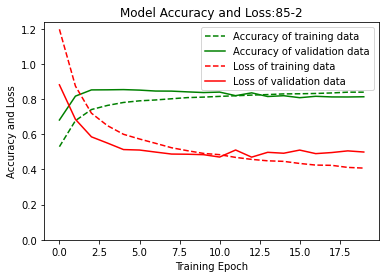


--- Check against test data ---

6584/6584 [==============================] - 0s 37us/step

Accuracy on test data: 0.77

Loss on test data: 0.62

--- Confusion matrix for test data ---



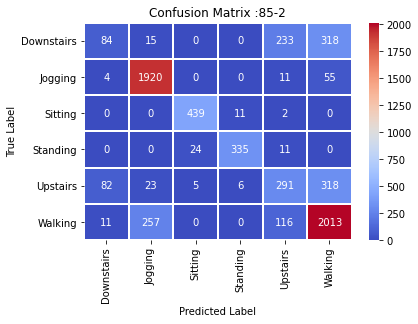


--- Classification report for test data 85:2---

              precision    recall  f1-score   support

           0       0.46      0.13      0.20       650
           1       0.87      0.96      0.91      1990
           2       0.94      0.97      0.95       452
           3       0.95      0.91      0.93       370
           4       0.44      0.40      0.42       725
           5       0.74      0.84      0.79      2397

    accuracy                           0.77      6584
   macro avg       0.73      0.70      0.70      6584
weighted avg       0.74      0.77      0.75      6584

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_75 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_149 (Conv1D)          (None, 76, 85)            1360      
______________________________________________________

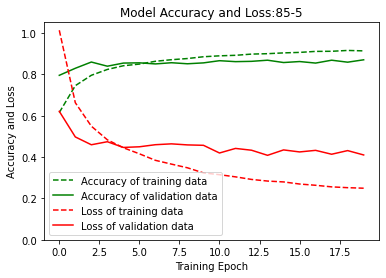


--- Check against test data ---

6584/6584 [==============================] - 0s 48us/step

Accuracy on test data: 0.89

Loss on test data: 0.37

--- Confusion matrix for test data ---



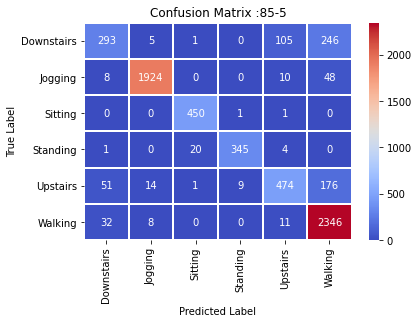


--- Classification report for test data 85:5---

              precision    recall  f1-score   support

           0       0.76      0.45      0.57       650
           1       0.99      0.97      0.98      1990
           2       0.95      1.00      0.97       452
           3       0.97      0.93      0.95       370
           4       0.78      0.65      0.71       725
           5       0.83      0.98      0.90      2397

    accuracy                           0.89      6584
   macro avg       0.88      0.83      0.85      6584
weighted avg       0.88      0.89      0.88      6584

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_76 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 73, 85)            2125      
______________________________________________________

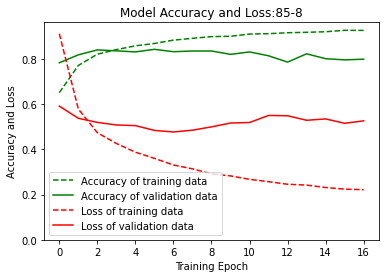


--- Check against test data ---

6584/6584 [==============================] - 0s 53us/step

Accuracy on test data: 0.90

Loss on test data: 0.32

--- Confusion matrix for test data ---



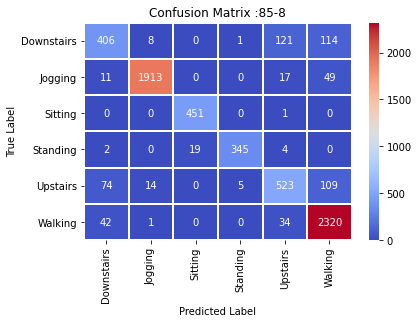


--- Classification report for test data 85:8---

              precision    recall  f1-score   support

           0       0.76      0.62      0.69       650
           1       0.99      0.96      0.97      1990
           2       0.96      1.00      0.98       452
           3       0.98      0.93      0.96       370
           4       0.75      0.72      0.73       725
           5       0.90      0.97      0.93      2397

    accuracy                           0.90      6584
   macro avg       0.89      0.87      0.88      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_77 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_153 (Conv1D)          (None, 71, 85)            2635      
______________________________________________________

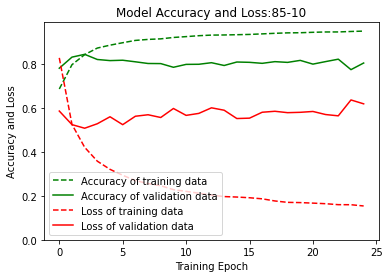


--- Check against test data ---

6584/6584 [==============================] - 0s 53us/step

Accuracy on test data: 0.91

Loss on test data: 0.34

--- Confusion matrix for test data ---



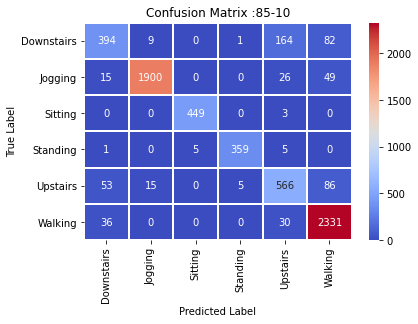


--- Classification report for test data 85:10---

              precision    recall  f1-score   support

           0       0.79      0.61      0.69       650
           1       0.99      0.95      0.97      1990
           2       0.99      0.99      0.99       452
           3       0.98      0.97      0.98       370
           4       0.71      0.78      0.75       725
           5       0.91      0.97      0.94      2397

    accuracy                           0.91      6584
   macro avg       0.90      0.88      0.89      6584
weighted avg       0.91      0.91      0.91      6584

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_78 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_155 (Conv1D)          (None, 69, 85)            3145      
_____________________________________________________

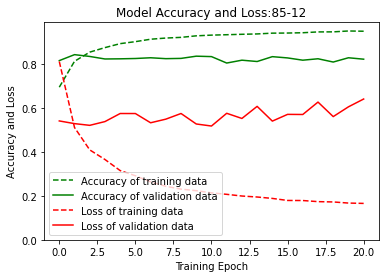


--- Check against test data ---

6584/6584 [==============================] - 0s 52us/step

Accuracy on test data: 0.90

Loss on test data: 0.36

--- Confusion matrix for test data ---



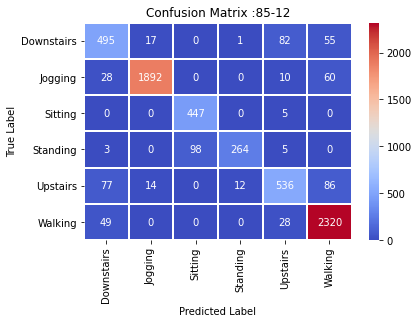


--- Classification report for test data 85:12---

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       650
           1       0.98      0.95      0.97      1990
           2       0.82      0.99      0.90       452
           3       0.95      0.71      0.82       370
           4       0.80      0.74      0.77       725
           5       0.92      0.97      0.94      2397

    accuracy                           0.90      6584
   macro avg       0.87      0.85      0.86      6584
weighted avg       0.91      0.90      0.90      6584

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_79 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_157 (Conv1D)          (None, 66, 85)            3910      
_____________________________________________________

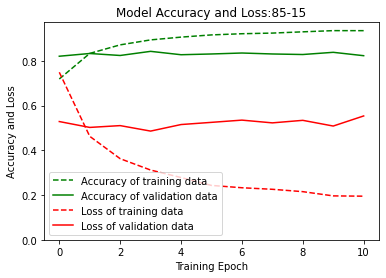


--- Check against test data ---

6584/6584 [==============================] - 0s 49us/step

Accuracy on test data: 0.88

Loss on test data: 0.41

--- Confusion matrix for test data ---



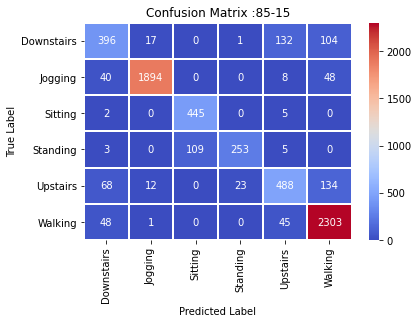


--- Classification report for test data 85:15---

              precision    recall  f1-score   support

           0       0.71      0.61      0.66       650
           1       0.98      0.95      0.97      1990
           2       0.80      0.98      0.88       452
           3       0.91      0.68      0.78       370
           4       0.71      0.67      0.69       725
           5       0.89      0.96      0.92      2397

    accuracy                           0.88      6584
   macro avg       0.84      0.81      0.82      6584
weighted avg       0.88      0.88      0.87      6584

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_80 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_159 (Conv1D)          (None, 63, 85)            4675      
_____________________________________________________

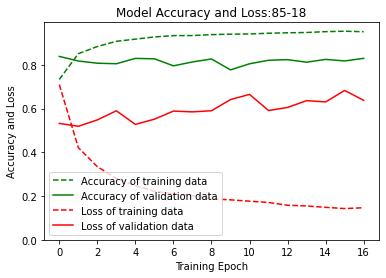


--- Check against test data ---

6584/6584 [==============================] - 0s 44us/step

Accuracy on test data: 0.87

Loss on test data: 0.49

--- Confusion matrix for test data ---



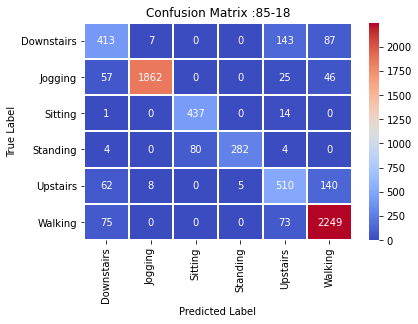


--- Classification report for test data 85:18---

              precision    recall  f1-score   support

           0       0.67      0.64      0.65       650
           1       0.99      0.94      0.96      1990
           2       0.85      0.97      0.90       452
           3       0.98      0.76      0.86       370
           4       0.66      0.70      0.68       725
           5       0.89      0.94      0.91      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.82      0.83      6584
weighted avg       0.88      0.87      0.87      6584

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_81 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_161 (Conv1D)          (None, 61, 85)            5185      
_____________________________________________________

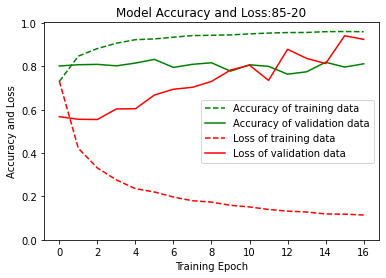


--- Check against test data ---

6584/6584 [==============================] - 0s 36us/step

Accuracy on test data: 0.86

Loss on test data: 0.76

--- Confusion matrix for test data ---



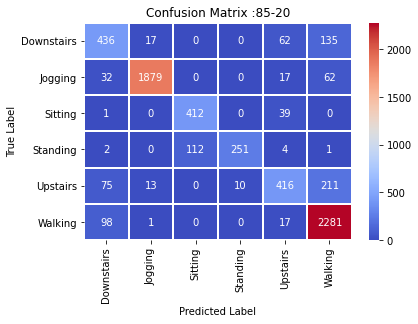


--- Classification report for test data 85:20---

              precision    recall  f1-score   support

           0       0.68      0.67      0.67       650
           1       0.98      0.94      0.96      1990
           2       0.79      0.91      0.84       452
           3       0.96      0.68      0.80       370
           4       0.75      0.57      0.65       725
           5       0.85      0.95      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.79      0.80      6584
weighted avg       0.86      0.86      0.86      6584

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_82 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 79, 95)            665       
_____________________________________________________

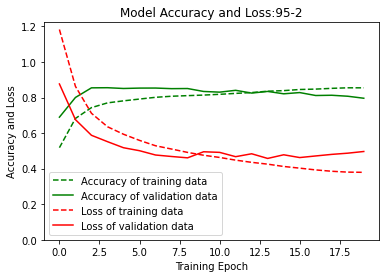


--- Check against test data ---

6584/6584 [==============================] - 0s 39us/step

Accuracy on test data: 0.79

Loss on test data: 0.54

--- Confusion matrix for test data ---



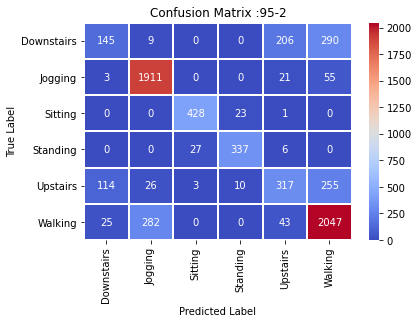


--- Classification report for test data 95:2---

              precision    recall  f1-score   support

           0       0.51      0.22      0.31       650
           1       0.86      0.96      0.91      1990
           2       0.93      0.95      0.94       452
           3       0.91      0.91      0.91       370
           4       0.53      0.44      0.48       725
           5       0.77      0.85      0.81      2397

    accuracy                           0.79      6584
   macro avg       0.75      0.72      0.73      6584
weighted avg       0.76      0.79      0.77      6584

Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_83 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_165 (Conv1D)          (None, 76, 95)            1520      
______________________________________________________

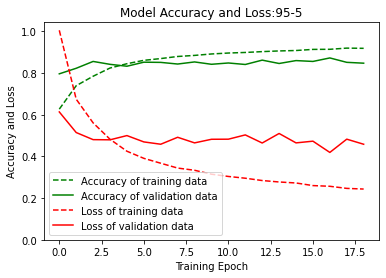


--- Check against test data ---

6584/6584 [==============================] - 0s 48us/step

Accuracy on test data: 0.90

Loss on test data: 0.33

--- Confusion matrix for test data ---



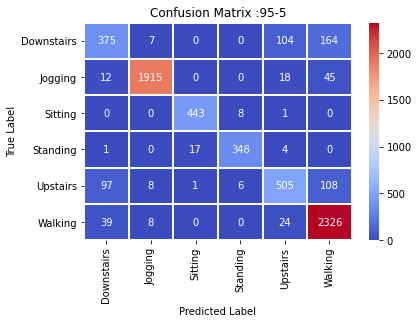


--- Classification report for test data 95:5---

              precision    recall  f1-score   support

           0       0.72      0.58      0.64       650
           1       0.99      0.96      0.98      1990
           2       0.96      0.98      0.97       452
           3       0.96      0.94      0.95       370
           4       0.77      0.70      0.73       725
           5       0.88      0.97      0.92      2397

    accuracy                           0.90      6584
   macro avg       0.88      0.85      0.86      6584
weighted avg       0.89      0.90      0.89      6584

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_84 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_167 (Conv1D)          (None, 73, 95)            2375      
______________________________________________________

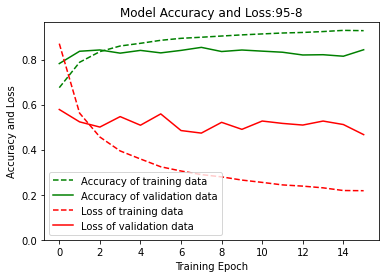


--- Check against test data ---

6584/6584 [==============================] - 0s 51us/step

Accuracy on test data: 0.91

Loss on test data: 0.33

--- Confusion matrix for test data ---



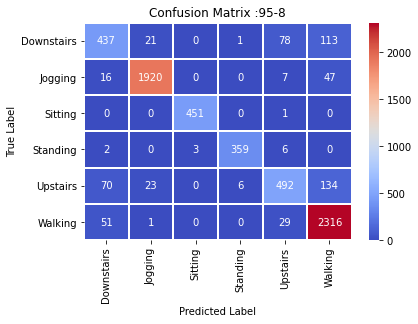


--- Classification report for test data 95:8---

              precision    recall  f1-score   support

           0       0.76      0.67      0.71       650
           1       0.98      0.96      0.97      1990
           2       0.99      1.00      1.00       452
           3       0.98      0.97      0.98       370
           4       0.80      0.68      0.74       725
           5       0.89      0.97      0.93      2397

    accuracy                           0.91      6584
   macro avg       0.90      0.88      0.89      6584
weighted avg       0.90      0.91      0.90      6584

Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_85 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_169 (Conv1D)          (None, 71, 95)            2945      
______________________________________________________

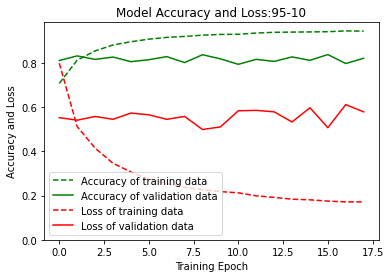


--- Check against test data ---

6584/6584 [==============================] - 0s 53us/step

Accuracy on test data: 0.91

Loss on test data: 0.39

--- Confusion matrix for test data ---



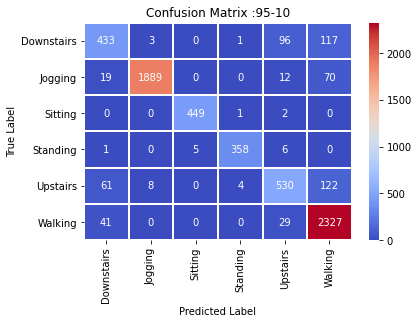


--- Classification report for test data 95:10---

              precision    recall  f1-score   support

           0       0.78      0.67      0.72       650
           1       0.99      0.95      0.97      1990
           2       0.99      0.99      0.99       452
           3       0.98      0.97      0.98       370
           4       0.79      0.73      0.76       725
           5       0.88      0.97      0.92      2397

    accuracy                           0.91      6584
   macro avg       0.90      0.88      0.89      6584
weighted avg       0.91      0.91      0.91      6584

Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_86 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_171 (Conv1D)          (None, 69, 95)            3515      
_____________________________________________________

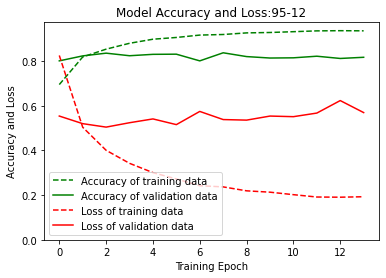


--- Check against test data ---

6584/6584 [==============================] - 0s 55us/step

Accuracy on test data: 0.91

Loss on test data: 0.38

--- Confusion matrix for test data ---



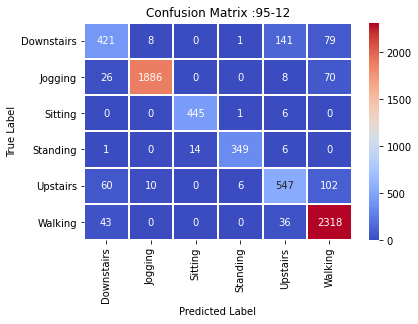


--- Classification report for test data 95:12---

              precision    recall  f1-score   support

           0       0.76      0.65      0.70       650
           1       0.99      0.95      0.97      1990
           2       0.97      0.98      0.98       452
           3       0.98      0.94      0.96       370
           4       0.74      0.75      0.74       725
           5       0.90      0.97      0.93      2397

    accuracy                           0.91      6584
   macro avg       0.89      0.87      0.88      6584
weighted avg       0.91      0.91      0.90      6584

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_87 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_173 (Conv1D)          (None, 66, 95)            4370      
_____________________________________________________

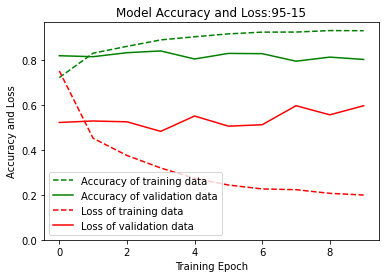


--- Check against test data ---

6584/6584 [==============================] - 0s 53us/step

Accuracy on test data: 0.87

Loss on test data: 0.47

--- Confusion matrix for test data ---



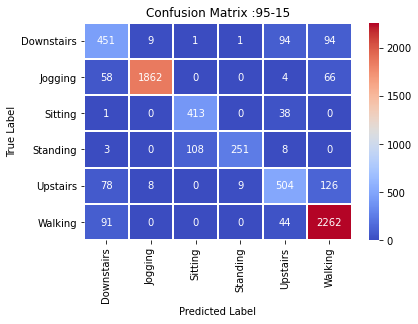


--- Classification report for test data 95:15---

              precision    recall  f1-score   support

           0       0.66      0.69      0.68       650
           1       0.99      0.94      0.96      1990
           2       0.79      0.91      0.85       452
           3       0.96      0.68      0.80       370
           4       0.73      0.70      0.71       725
           5       0.89      0.94      0.91      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.81      0.82      6584
weighted avg       0.88      0.87      0.87      6584

Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_88 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_175 (Conv1D)          (None, 63, 95)            5225      
_____________________________________________________

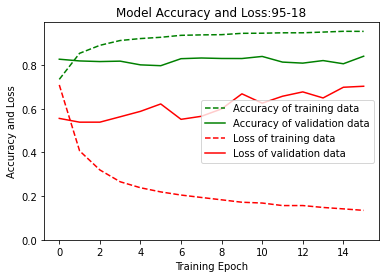


--- Check against test data ---

6584/6584 [==============================] - 0s 47us/step

Accuracy on test data: 0.88

Loss on test data: 0.51

--- Confusion matrix for test data ---



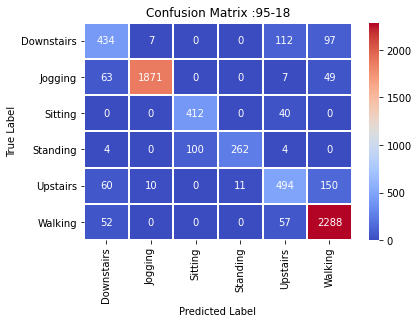


--- Classification report for test data 95:18---

              precision    recall  f1-score   support

           0       0.71      0.67      0.69       650
           1       0.99      0.94      0.96      1990
           2       0.80      0.91      0.85       452
           3       0.96      0.71      0.81       370
           4       0.69      0.68      0.69       725
           5       0.89      0.95      0.92      2397

    accuracy                           0.88      6584
   macro avg       0.84      0.81      0.82      6584
weighted avg       0.88      0.88      0.87      6584

Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_89 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_177 (Conv1D)          (None, 61, 95)            5795      
_____________________________________________________

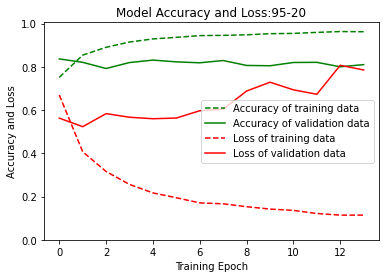


--- Check against test data ---

6584/6584 [==============================] - 0s 38us/step

Accuracy on test data: 0.87

Loss on test data: 0.55

--- Confusion matrix for test data ---



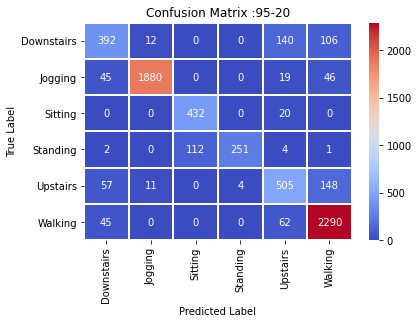


--- Classification report for test data 95:20---

              precision    recall  f1-score   support

           0       0.72      0.60      0.66       650
           1       0.99      0.94      0.97      1990
           2       0.79      0.96      0.87       452
           3       0.98      0.68      0.80       370
           4       0.67      0.70      0.68       725
           5       0.88      0.96      0.92      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.81      0.82      6584
weighted avg       0.88      0.87      0.87      6584

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_90 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_179 (Conv1D)          (None, 79, 110)           770       
_____________________________________________________

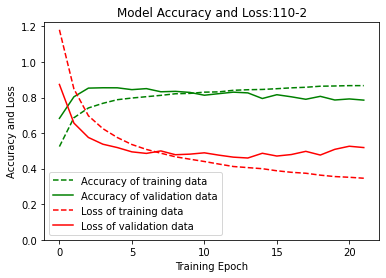


--- Check against test data ---

6584/6584 [==============================] - 0s 43us/step

Accuracy on test data: 0.80

Loss on test data: 0.64

--- Confusion matrix for test data ---



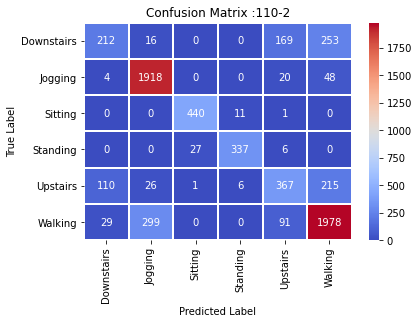


--- Classification report for test data 110:2---

              precision    recall  f1-score   support

           0       0.60      0.33      0.42       650
           1       0.85      0.96      0.90      1990
           2       0.94      0.97      0.96       452
           3       0.95      0.91      0.93       370
           4       0.56      0.51      0.53       725
           5       0.79      0.83      0.81      2397

    accuracy                           0.80      6584
   macro avg       0.78      0.75      0.76      6584
weighted avg       0.78      0.80      0.79      6584

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_91 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_181 (Conv1D)          (None, 76, 110)           1760      
_____________________________________________________

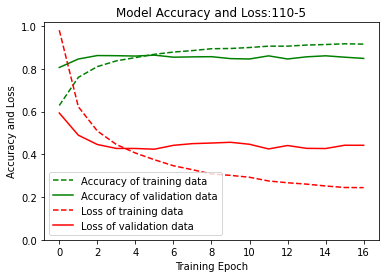


--- Check against test data ---

6584/6584 [==============================] - 0s 53us/step

Accuracy on test data: 0.89

Loss on test data: 0.36

--- Confusion matrix for test data ---



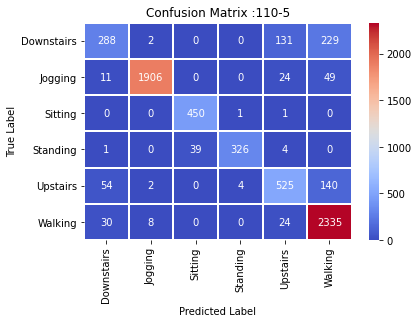


--- Classification report for test data 110:5---

              precision    recall  f1-score   support

           0       0.75      0.44      0.56       650
           1       0.99      0.96      0.98      1990
           2       0.92      1.00      0.96       452
           3       0.98      0.88      0.93       370
           4       0.74      0.72      0.73       725
           5       0.85      0.97      0.91      2397

    accuracy                           0.89      6584
   macro avg       0.87      0.83      0.84      6584
weighted avg       0.88      0.89      0.88      6584

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_92 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_183 (Conv1D)          (None, 73, 110)           2750      
_____________________________________________________

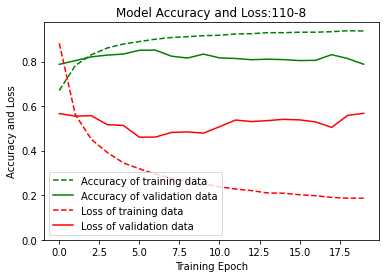


--- Check against test data ---

6584/6584 [==============================] - 0s 58us/step

Accuracy on test data: 0.92

Loss on test data: 0.31

--- Confusion matrix for test data ---



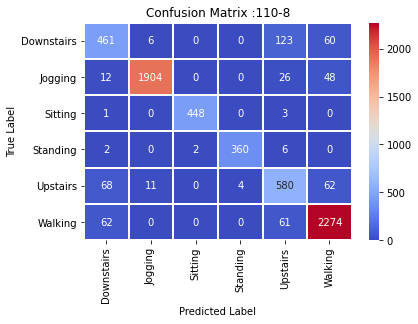


--- Classification report for test data 110:8---

              precision    recall  f1-score   support

           0       0.76      0.71      0.73       650
           1       0.99      0.96      0.97      1990
           2       1.00      0.99      0.99       452
           3       0.99      0.97      0.98       370
           4       0.73      0.80      0.76       725
           5       0.93      0.95      0.94      2397

    accuracy                           0.92      6584
   macro avg       0.90      0.90      0.90      6584
weighted avg       0.92      0.92      0.92      6584

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_93 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_185 (Conv1D)          (None, 71, 110)           3410      
_____________________________________________________

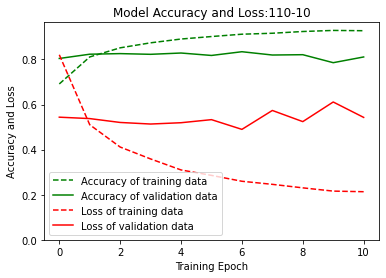


--- Check against test data ---

6584/6584 [==============================] - 0s 69us/step

Accuracy on test data: 0.91

Loss on test data: 0.34

--- Confusion matrix for test data ---



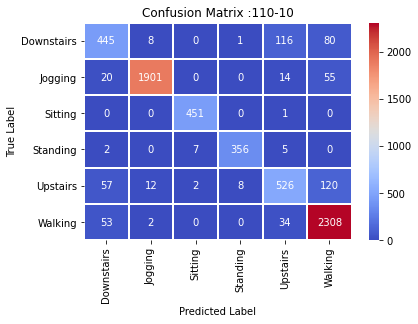


--- Classification report for test data 110:10---

              precision    recall  f1-score   support

           0       0.77      0.68      0.73       650
           1       0.99      0.96      0.97      1990
           2       0.98      1.00      0.99       452
           3       0.98      0.96      0.97       370
           4       0.76      0.73      0.74       725
           5       0.90      0.96      0.93      2397

    accuracy                           0.91      6584
   macro avg       0.90      0.88      0.89      6584
weighted avg       0.91      0.91      0.91      6584

Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_94 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_187 (Conv1D)          (None, 69, 110)           4070      
____________________________________________________

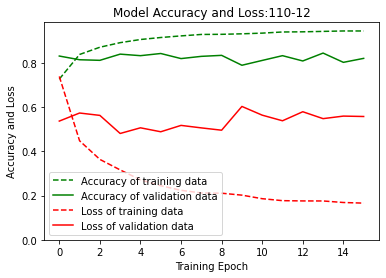


--- Check against test data ---

6584/6584 [==============================] - 0s 61us/step

Accuracy on test data: 0.91

Loss on test data: 0.39

--- Confusion matrix for test data ---



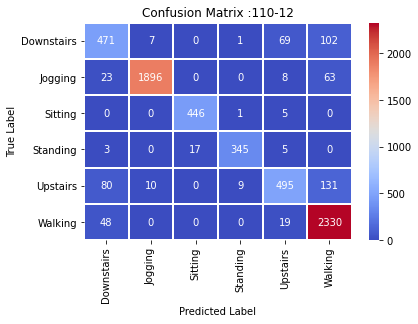


--- Classification report for test data 110:12---

              precision    recall  f1-score   support

           0       0.75      0.72      0.74       650
           1       0.99      0.95      0.97      1990
           2       0.96      0.99      0.97       452
           3       0.97      0.93      0.95       370
           4       0.82      0.68      0.75       725
           5       0.89      0.97      0.93      2397

    accuracy                           0.91      6584
   macro avg       0.90      0.88      0.88      6584
weighted avg       0.91      0.91      0.91      6584

Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_95 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_189 (Conv1D)          (None, 66, 110)           5060      
____________________________________________________

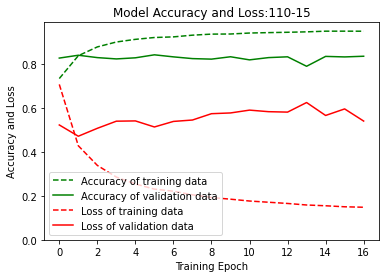


--- Check against test data ---

6584/6584 [==============================] - 0s 55us/step

Accuracy on test data: 0.88

Loss on test data: 0.43

--- Confusion matrix for test data ---



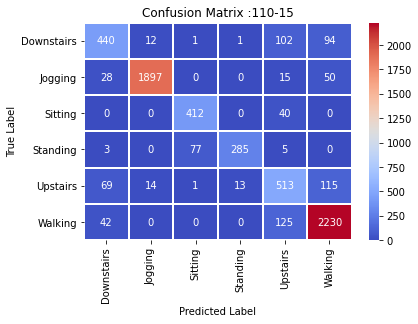


--- Classification report for test data 110:15---

              precision    recall  f1-score   support

           0       0.76      0.68      0.71       650
           1       0.99      0.95      0.97      1990
           2       0.84      0.91      0.87       452
           3       0.95      0.77      0.85       370
           4       0.64      0.71      0.67       725
           5       0.90      0.93      0.91      2397

    accuracy                           0.88      6584
   macro avg       0.85      0.82      0.83      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_96 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_191 (Conv1D)          (None, 63, 110)           6050      
____________________________________________________

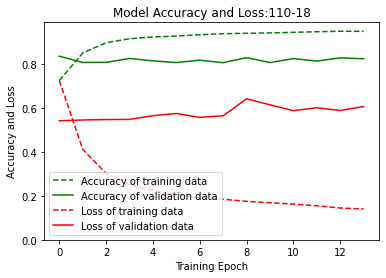


--- Check against test data ---

6584/6584 [==============================] - 0s 49us/step

Accuracy on test data: 0.88

Loss on test data: 0.49

--- Confusion matrix for test data ---



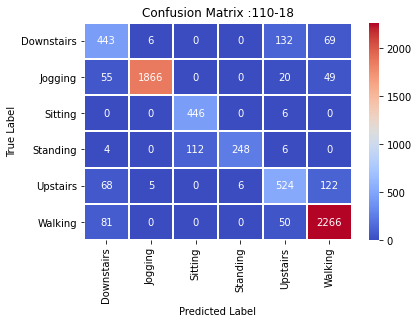


--- Classification report for test data 110:18---

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       650
           1       0.99      0.94      0.97      1990
           2       0.80      0.99      0.88       452
           3       0.98      0.67      0.79       370
           4       0.71      0.72      0.72       725
           5       0.90      0.95      0.92      2397

    accuracy                           0.88      6584
   macro avg       0.84      0.82      0.83      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_97 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_193 (Conv1D)          (None, 61, 110)           6710      
____________________________________________________

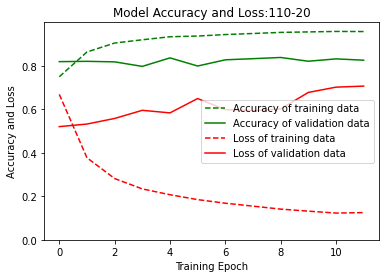


--- Check against test data ---

6584/6584 [==============================] - 0s 38us/step

Accuracy on test data: 0.87

Loss on test data: 0.61

--- Confusion matrix for test data ---



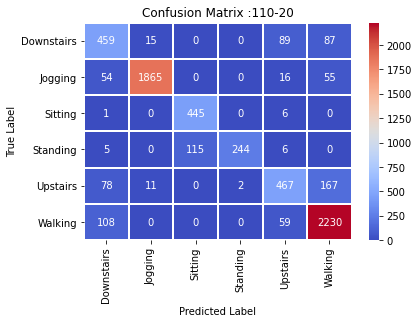


--- Classification report for test data 110:20---

              precision    recall  f1-score   support

           0       0.65      0.71      0.68       650
           1       0.99      0.94      0.96      1990
           2       0.79      0.98      0.88       452
           3       0.99      0.66      0.79       370
           4       0.73      0.64      0.68       725
           5       0.88      0.93      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.81      0.82      6584
weighted avg       0.87      0.87      0.87      6584

Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_98 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_195 (Conv1D)          (None, 79, 130)           910       
____________________________________________________

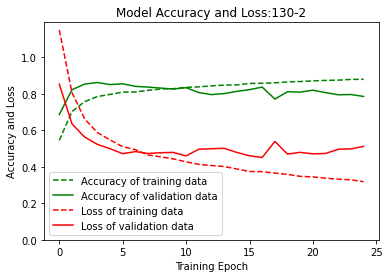


--- Check against test data ---

6584/6584 [==============================] - 0s 47us/step

Accuracy on test data: 0.81

Loss on test data: 0.55

--- Confusion matrix for test data ---



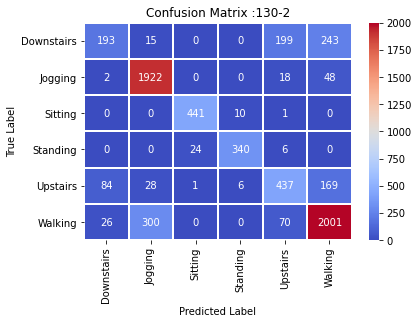


--- Classification report for test data 130:2---

              precision    recall  f1-score   support

           0       0.63      0.30      0.40       650
           1       0.85      0.97      0.90      1990
           2       0.95      0.98      0.96       452
           3       0.96      0.92      0.94       370
           4       0.60      0.60      0.60       725
           5       0.81      0.83      0.82      2397

    accuracy                           0.81      6584
   macro avg       0.80      0.77      0.77      6584
weighted avg       0.80      0.81      0.80      6584

Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_99 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_197 (Conv1D)          (None, 76, 130)           2080      
_____________________________________________________

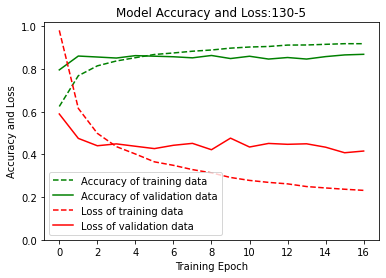


--- Check against test data ---

6584/6584 [==============================] - 0s 64us/step

Accuracy on test data: 0.89

Loss on test data: 0.35

--- Confusion matrix for test data ---



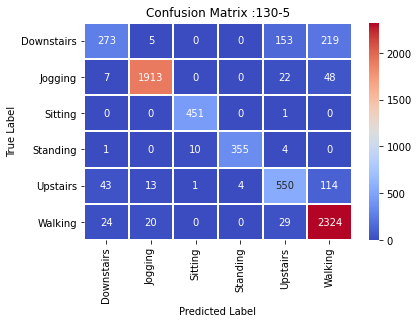


--- Classification report for test data 130:5---

              precision    recall  f1-score   support

           0       0.78      0.42      0.55       650
           1       0.98      0.96      0.97      1990
           2       0.98      1.00      0.99       452
           3       0.99      0.96      0.97       370
           4       0.72      0.76      0.74       725
           5       0.86      0.97      0.91      2397

    accuracy                           0.89      6584
   macro avg       0.89      0.84      0.86      6584
weighted avg       0.89      0.89      0.88      6584

Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_100 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_199 (Conv1D)          (None, 73, 130)           3250      
____________________________________________________

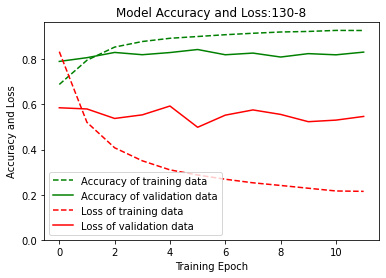


--- Check against test data ---

6584/6584 [==============================] - 0s 73us/step

Accuracy on test data: 0.89

Loss on test data: 0.37

--- Confusion matrix for test data ---



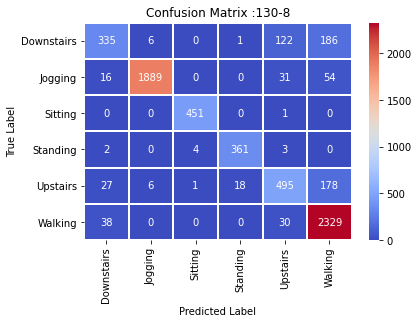


--- Classification report for test data 130:8---

              precision    recall  f1-score   support

           0       0.80      0.52      0.63       650
           1       0.99      0.95      0.97      1990
           2       0.99      1.00      0.99       452
           3       0.95      0.98      0.96       370
           4       0.73      0.68      0.70       725
           5       0.85      0.97      0.91      2397

    accuracy                           0.89      6584
   macro avg       0.88      0.85      0.86      6584
weighted avg       0.89      0.89      0.88      6584

Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_101 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_201 (Conv1D)          (None, 71, 130)           4030      
____________________________________________________

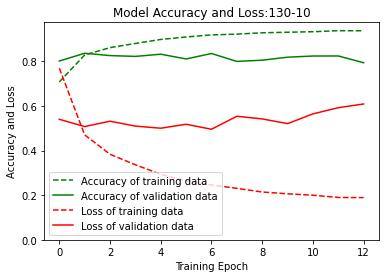


--- Check against test data ---

6584/6584 [==============================] - 1s 84us/step

Accuracy on test data: 0.90

Loss on test data: 0.37

--- Confusion matrix for test data ---



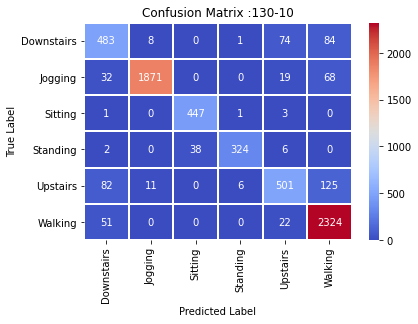


--- Classification report for test data 130:10---

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       650
           1       0.99      0.94      0.96      1990
           2       0.92      0.99      0.95       452
           3       0.98      0.88      0.92       370
           4       0.80      0.69      0.74       725
           5       0.89      0.97      0.93      2397

    accuracy                           0.90      6584
   macro avg       0.89      0.87      0.88      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_102 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_203 (Conv1D)          (None, 69, 130)           4810      
___________________________________________________

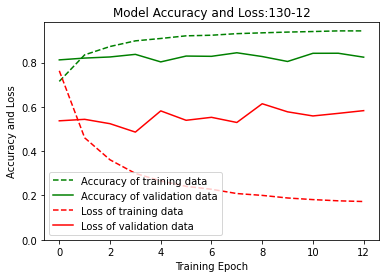


--- Check against test data ---

6584/6584 [==============================] - 0s 75us/step

Accuracy on test data: 0.90

Loss on test data: 0.41

--- Confusion matrix for test data ---



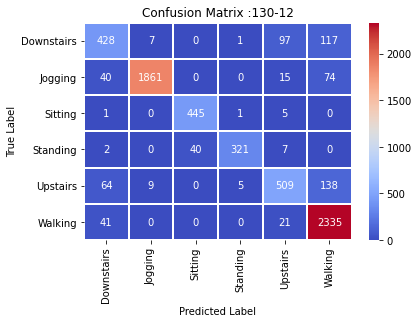


--- Classification report for test data 130:12---

              precision    recall  f1-score   support

           0       0.74      0.66      0.70       650
           1       0.99      0.94      0.96      1990
           2       0.92      0.98      0.95       452
           3       0.98      0.87      0.92       370
           4       0.78      0.70      0.74       725
           5       0.88      0.97      0.92      2397

    accuracy                           0.90      6584
   macro avg       0.88      0.85      0.87      6584
weighted avg       0.90      0.90      0.89      6584

Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_103 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_205 (Conv1D)          (None, 66, 130)           5980      
___________________________________________________

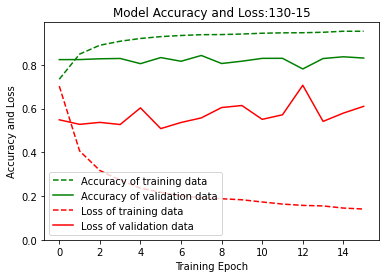


--- Check against test data ---

6584/6584 [==============================] - 0s 66us/step

Accuracy on test data: 0.88

Loss on test data: 0.44

--- Confusion matrix for test data ---



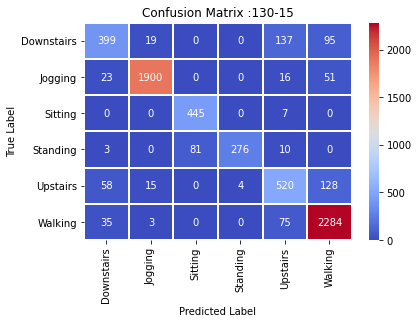


--- Classification report for test data 130:15---

              precision    recall  f1-score   support

           0       0.77      0.61      0.68       650
           1       0.98      0.95      0.97      1990
           2       0.85      0.98      0.91       452
           3       0.99      0.75      0.85       370
           4       0.68      0.72      0.70       725
           5       0.89      0.95      0.92      2397

    accuracy                           0.88      6584
   macro avg       0.86      0.83      0.84      6584
weighted avg       0.89      0.88      0.88      6584

Model: "sequential_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_104 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_207 (Conv1D)          (None, 63, 130)           7150      
___________________________________________________

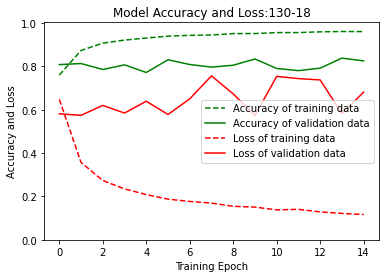


--- Check against test data ---

6584/6584 [==============================] - 0s 57us/step

Accuracy on test data: 0.86

Loss on test data: 0.50

--- Confusion matrix for test data ---



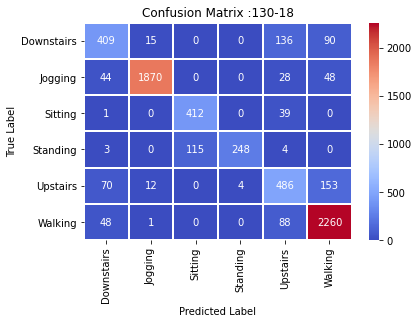


--- Classification report for test data 130:18---

              precision    recall  f1-score   support

           0       0.71      0.63      0.67       650
           1       0.99      0.94      0.96      1990
           2       0.78      0.91      0.84       452
           3       0.98      0.67      0.80       370
           4       0.62      0.67      0.65       725
           5       0.89      0.94      0.91      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.79      0.80      6584
weighted avg       0.87      0.86      0.86      6584

Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_105 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_209 (Conv1D)          (None, 61, 130)           7930      
___________________________________________________

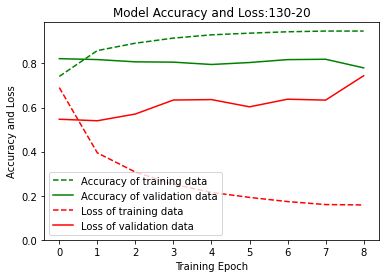


--- Check against test data ---

6584/6584 [==============================] - 0s 42us/step

Accuracy on test data: 0.87

Loss on test data: 0.52

--- Confusion matrix for test data ---



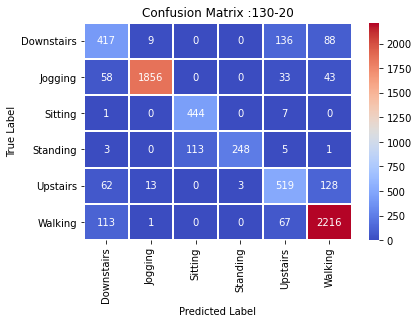


--- Classification report for test data 130:20---

              precision    recall  f1-score   support

           0       0.64      0.64      0.64       650
           1       0.99      0.93      0.96      1990
           2       0.80      0.98      0.88       452
           3       0.99      0.67      0.80       370
           4       0.68      0.72      0.70       725
           5       0.89      0.92      0.91      2397

    accuracy                           0.87      6584
   macro avg       0.83      0.81      0.81      6584
weighted avg       0.87      0.87      0.87      6584

Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_106 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_211 (Conv1D)          (None, 79, 150)           1050      
___________________________________________________

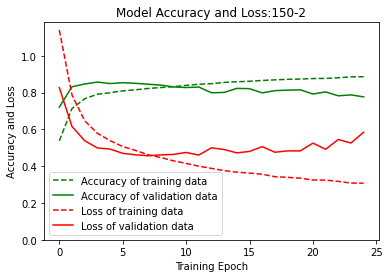


--- Check against test data ---

6584/6584 [==============================] - 0s 54us/step

Accuracy on test data: 0.81

Loss on test data: 0.69

--- Confusion matrix for test data ---



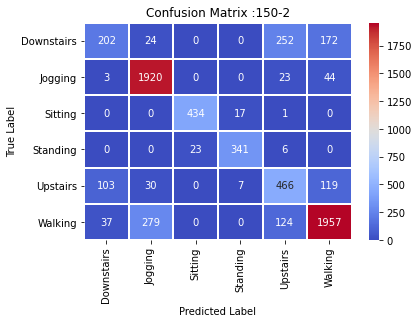


--- Classification report for test data 150:2---

              precision    recall  f1-score   support

           0       0.59      0.31      0.41       650
           1       0.85      0.96      0.91      1990
           2       0.95      0.96      0.95       452
           3       0.93      0.92      0.93       370
           4       0.53      0.64      0.58       725
           5       0.85      0.82      0.83      2397

    accuracy                           0.81      6584
   macro avg       0.78      0.77      0.77      6584
weighted avg       0.80      0.81      0.80      6584

Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_107 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_213 (Conv1D)          (None, 76, 150)           2400      
____________________________________________________

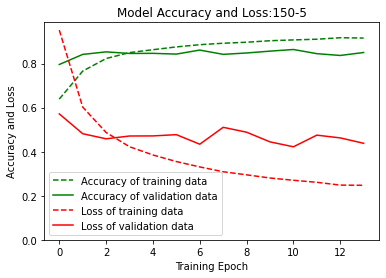


--- Check against test data ---

6584/6584 [==============================] - 0s 74us/step

Accuracy on test data: 0.89

Loss on test data: 0.34

--- Confusion matrix for test data ---



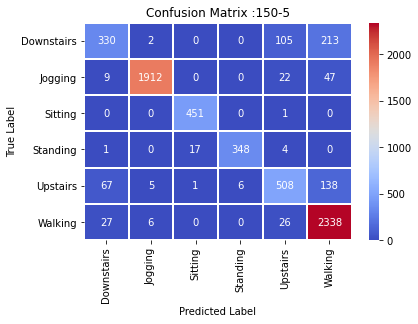


--- Classification report for test data 150:5---

              precision    recall  f1-score   support

           0       0.76      0.51      0.61       650
           1       0.99      0.96      0.98      1990
           2       0.96      1.00      0.98       452
           3       0.98      0.94      0.96       370
           4       0.76      0.70      0.73       725
           5       0.85      0.98      0.91      2397

    accuracy                           0.89      6584
   macro avg       0.89      0.85      0.86      6584
weighted avg       0.89      0.89      0.89      6584

Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_108 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_215 (Conv1D)          (None, 73, 150)           3750      
____________________________________________________

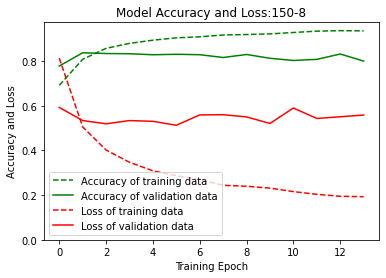


--- Check against test data ---

6584/6584 [==============================] - 1s 83us/step

Accuracy on test data: 0.91

Loss on test data: 0.33

--- Confusion matrix for test data ---



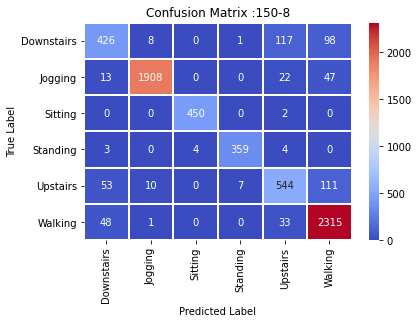


--- Classification report for test data 150:8---

              precision    recall  f1-score   support

           0       0.78      0.66      0.71       650
           1       0.99      0.96      0.97      1990
           2       0.99      1.00      0.99       452
           3       0.98      0.97      0.97       370
           4       0.75      0.75      0.75       725
           5       0.90      0.97      0.93      2397

    accuracy                           0.91      6584
   macro avg       0.90      0.88      0.89      6584
weighted avg       0.91      0.91      0.91      6584

Model: "sequential_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_109 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_217 (Conv1D)          (None, 71, 150)           4650      
____________________________________________________

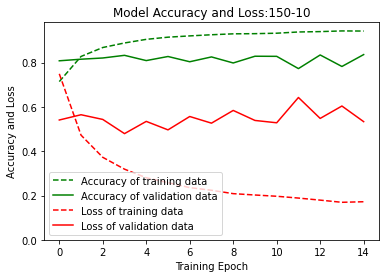


--- Check against test data ---

6584/6584 [==============================] - 1s 85us/step

Accuracy on test data: 0.90

Loss on test data: 0.41

--- Confusion matrix for test data ---



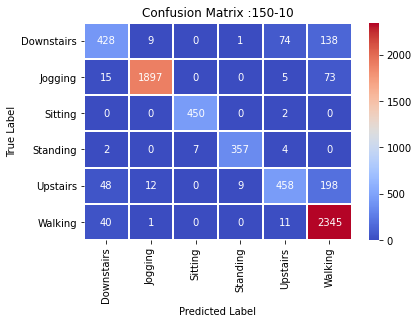


--- Classification report for test data 150:10---

              precision    recall  f1-score   support

           0       0.80      0.66      0.72       650
           1       0.99      0.95      0.97      1990
           2       0.98      1.00      0.99       452
           3       0.97      0.96      0.97       370
           4       0.83      0.63      0.72       725
           5       0.85      0.98      0.91      2397

    accuracy                           0.90      6584
   macro avg       0.90      0.86      0.88      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_110 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_219 (Conv1D)          (None, 69, 150)           5550      
___________________________________________________

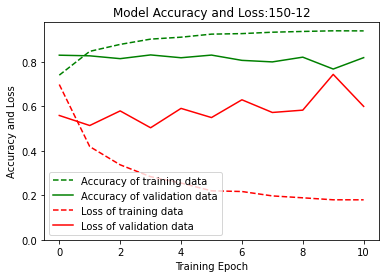


--- Check against test data ---

6584/6584 [==============================] - 1s 83us/step

Accuracy on test data: 0.89

Loss on test data: 0.39

--- Confusion matrix for test data ---



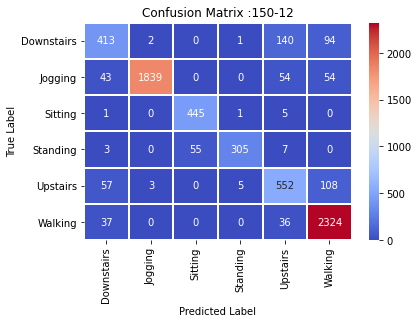


--- Classification report for test data 150:12---

              precision    recall  f1-score   support

           0       0.75      0.64      0.69       650
           1       1.00      0.92      0.96      1990
           2       0.89      0.98      0.93       452
           3       0.98      0.82      0.89       370
           4       0.70      0.76      0.73       725
           5       0.90      0.97      0.93      2397

    accuracy                           0.89      6584
   macro avg       0.87      0.85      0.86      6584
weighted avg       0.90      0.89      0.89      6584

Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_111 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_221 (Conv1D)          (None, 66, 150)           6900      
___________________________________________________

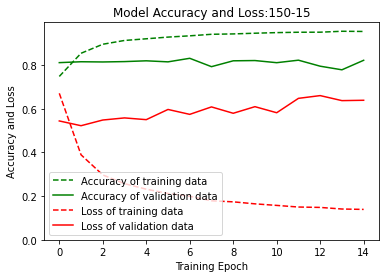


--- Check against test data ---

6584/6584 [==============================] - 1s 77us/step

Accuracy on test data: 0.88

Loss on test data: 0.50

--- Confusion matrix for test data ---



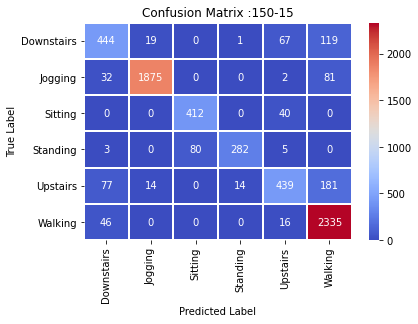


--- Classification report for test data 150:15---

              precision    recall  f1-score   support

           0       0.74      0.68      0.71       650
           1       0.98      0.94      0.96      1990
           2       0.84      0.91      0.87       452
           3       0.95      0.76      0.85       370
           4       0.77      0.61      0.68       725
           5       0.86      0.97      0.91      2397

    accuracy                           0.88      6584
   macro avg       0.86      0.81      0.83      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_112 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_223 (Conv1D)          (None, 63, 150)           8250      
___________________________________________________

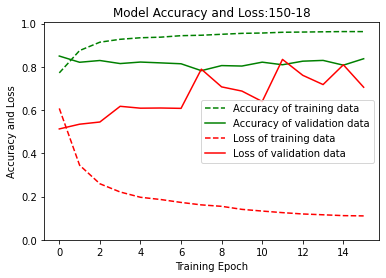


--- Check against test data ---

6584/6584 [==============================] - 0s 65us/step

Accuracy on test data: 0.88

Loss on test data: 0.47

--- Confusion matrix for test data ---



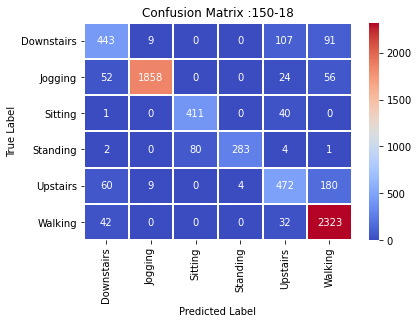


--- Classification report for test data 150:18---

              precision    recall  f1-score   support

           0       0.74      0.68      0.71       650
           1       0.99      0.93      0.96      1990
           2       0.84      0.91      0.87       452
           3       0.99      0.76      0.86       370
           4       0.70      0.65      0.67       725
           5       0.88      0.97      0.92      2397

    accuracy                           0.88      6584
   macro avg       0.85      0.82      0.83      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_113 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_225 (Conv1D)          (None, 61, 150)           9150      
___________________________________________________

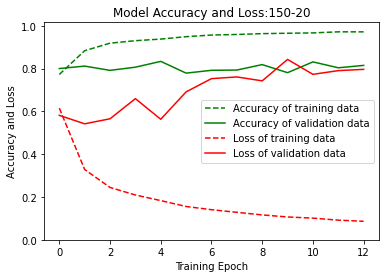


--- Check against test data ---

6584/6584 [==============================] - 0s 45us/step

Accuracy on test data: 0.87

Loss on test data: 0.62

--- Confusion matrix for test data ---



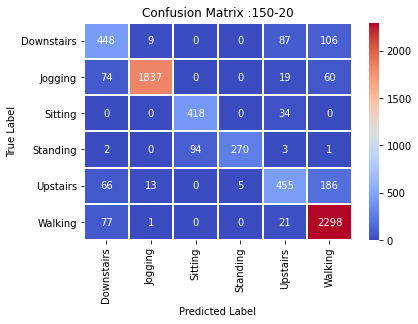


--- Classification report for test data 150:20---

              precision    recall  f1-score   support

           0       0.67      0.69      0.68       650
           1       0.99      0.92      0.95      1990
           2       0.82      0.92      0.87       452
           3       0.98      0.73      0.84       370
           4       0.74      0.63      0.68       725
           5       0.87      0.96      0.91      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.81      0.82      6584
weighted avg       0.87      0.87      0.87      6584

Model: "sequential_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_114 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_227 (Conv1D)          (None, 79, 160)           1120      
___________________________________________________

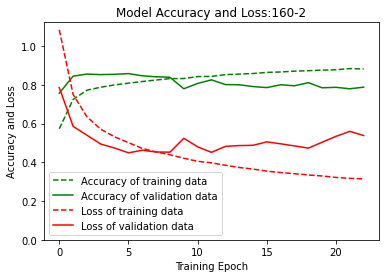


--- Check against test data ---

6584/6584 [==============================] - 0s 56us/step

Accuracy on test data: 0.80

Loss on test data: 0.63

--- Confusion matrix for test data ---



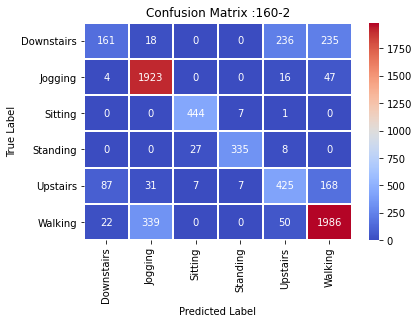


--- Classification report for test data 160:2---

              precision    recall  f1-score   support

           0       0.59      0.25      0.35       650
           1       0.83      0.97      0.89      1990
           2       0.93      0.98      0.95       452
           3       0.96      0.91      0.93       370
           4       0.58      0.59      0.58       725
           5       0.82      0.83      0.82      2397

    accuracy                           0.80      6584
   macro avg       0.78      0.75      0.76      6584
weighted avg       0.79      0.80      0.79      6584

Model: "sequential_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_115 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_229 (Conv1D)          (None, 76, 160)           2560      
____________________________________________________

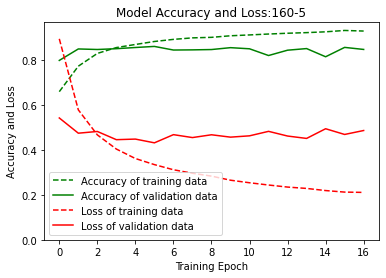


--- Check against test data ---

6584/6584 [==============================] - 1s 79us/step

Accuracy on test data: 0.88

Loss on test data: 0.42

--- Confusion matrix for test data ---



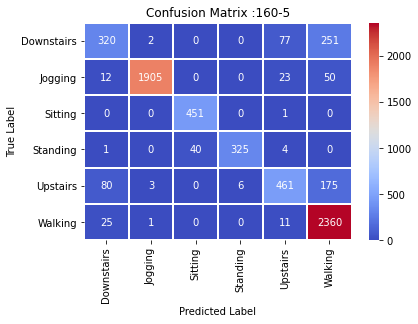


--- Classification report for test data 160:5---

              precision    recall  f1-score   support

           0       0.73      0.49      0.59       650
           1       1.00      0.96      0.98      1990
           2       0.92      1.00      0.96       452
           3       0.98      0.88      0.93       370
           4       0.80      0.64      0.71       725
           5       0.83      0.98      0.90      2397

    accuracy                           0.88      6584
   macro avg       0.88      0.82      0.84      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_116 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_231 (Conv1D)          (None, 73, 160)           4000      
____________________________________________________

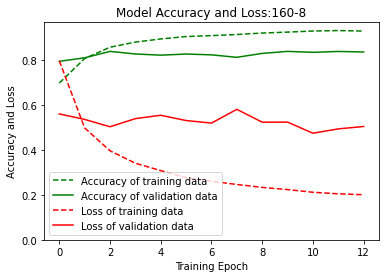


--- Check against test data ---

6584/6584 [==============================] - 1s 88us/step

Accuracy on test data: 0.89

Loss on test data: 0.38

--- Confusion matrix for test data ---



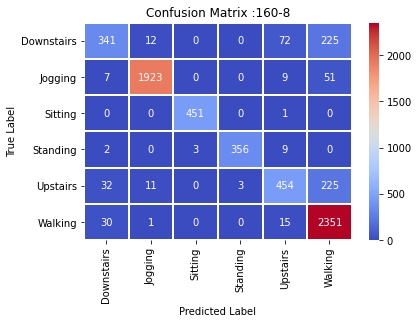


--- Classification report for test data 160:8---

              precision    recall  f1-score   support

           0       0.83      0.52      0.64       650
           1       0.99      0.97      0.98      1990
           2       0.99      1.00      1.00       452
           3       0.99      0.96      0.98       370
           4       0.81      0.63      0.71       725
           5       0.82      0.98      0.90      2397

    accuracy                           0.89      6584
   macro avg       0.91      0.84      0.87      6584
weighted avg       0.89      0.89      0.89      6584

Model: "sequential_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_117 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_233 (Conv1D)          (None, 71, 160)           4960      
____________________________________________________

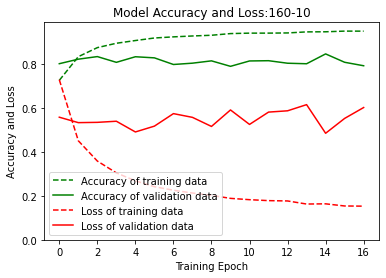


--- Check against test data ---

6584/6584 [==============================] - 1s 89us/step

Accuracy on test data: 0.91

Loss on test data: 0.33

--- Confusion matrix for test data ---



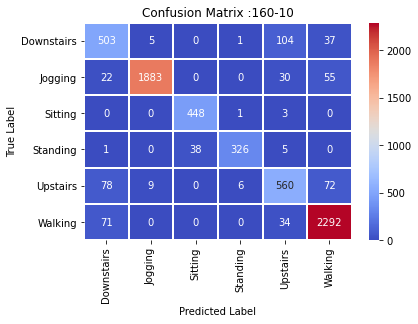


--- Classification report for test data 160:10---

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       650
           1       0.99      0.95      0.97      1990
           2       0.92      0.99      0.96       452
           3       0.98      0.88      0.93       370
           4       0.76      0.77      0.77       725
           5       0.93      0.96      0.94      2397

    accuracy                           0.91      6584
   macro avg       0.89      0.89      0.89      6584
weighted avg       0.92      0.91      0.91      6584

Model: "sequential_118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_118 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_235 (Conv1D)          (None, 69, 160)           5920      
___________________________________________________

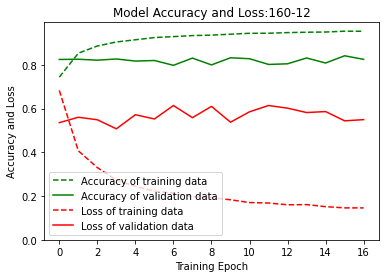


--- Check against test data ---

6584/6584 [==============================] - 1s 90us/step

Accuracy on test data: 0.90

Loss on test data: 0.33

--- Confusion matrix for test data ---



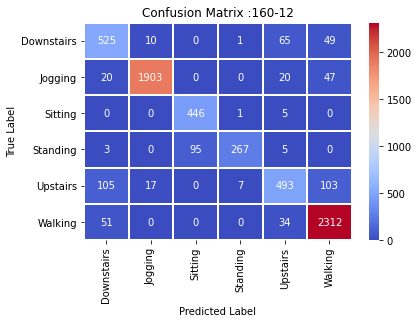


--- Classification report for test data 160:12---

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       650
           1       0.99      0.96      0.97      1990
           2       0.82      0.99      0.90       452
           3       0.97      0.72      0.83       370
           4       0.79      0.68      0.73       725
           5       0.92      0.96      0.94      2397

    accuracy                           0.90      6584
   macro avg       0.87      0.85      0.86      6584
weighted avg       0.91      0.90      0.90      6584

Model: "sequential_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_119 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_237 (Conv1D)          (None, 66, 160)           7360      
___________________________________________________

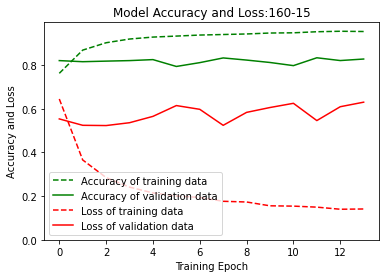


--- Check against test data ---

6584/6584 [==============================] - 1s 82us/step

Accuracy on test data: 0.88

Loss on test data: 0.42

--- Confusion matrix for test data ---



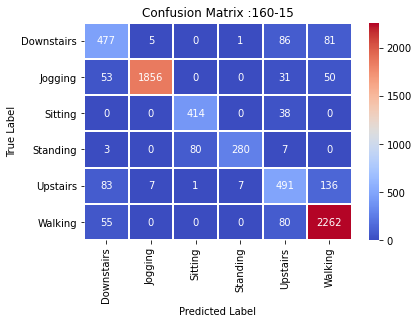


--- Classification report for test data 160:15---

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       650
           1       0.99      0.93      0.96      1990
           2       0.84      0.92      0.87       452
           3       0.97      0.76      0.85       370
           4       0.67      0.68      0.67       725
           5       0.89      0.94      0.92      2397

    accuracy                           0.88      6584
   macro avg       0.85      0.83      0.83      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_120 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_239 (Conv1D)          (None, 63, 160)           8800      
___________________________________________________

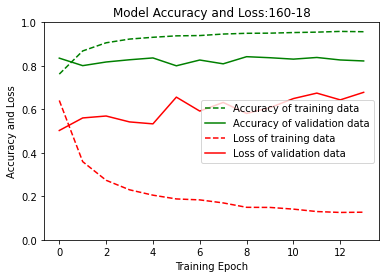


--- Check against test data ---

6584/6584 [==============================] - 0s 71us/step

Accuracy on test data: 0.88

Loss on test data: 0.56

--- Confusion matrix for test data ---



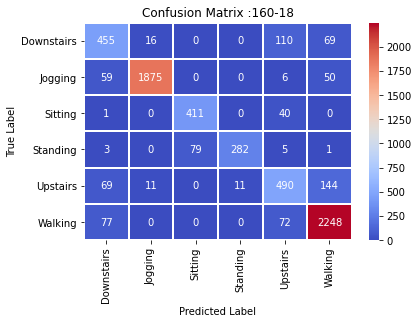


--- Classification report for test data 160:18---

              precision    recall  f1-score   support

           0       0.69      0.70      0.69       650
           1       0.99      0.94      0.96      1990
           2       0.84      0.91      0.87       452
           3       0.96      0.76      0.85       370
           4       0.68      0.68      0.68       725
           5       0.89      0.94      0.92      2397

    accuracy                           0.88      6584
   macro avg       0.84      0.82      0.83      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_121 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_241 (Conv1D)          (None, 61, 160)           9760      
___________________________________________________

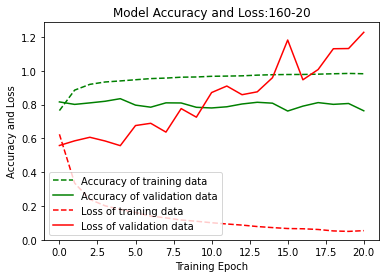


--- Check against test data ---

6584/6584 [==============================] - 0s 44us/step

Accuracy on test data: 0.87

Loss on test data: 0.80

--- Confusion matrix for test data ---



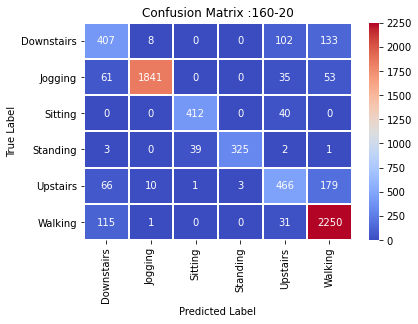


--- Classification report for test data 160:20---

              precision    recall  f1-score   support

           0       0.62      0.63      0.63       650
           1       0.99      0.93      0.96      1990
           2       0.91      0.91      0.91       452
           3       0.99      0.88      0.93       370
           4       0.69      0.64      0.67       725
           5       0.86      0.94      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.82      0.83      6584
weighted avg       0.87      0.87      0.87      6584

Model: "sequential_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_122 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_243 (Conv1D)          (None, 79, 170)           1190      
___________________________________________________

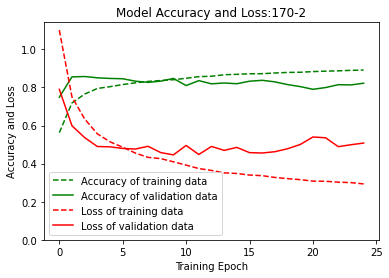


--- Check against test data ---

6584/6584 [==============================] - 0s 67us/step

Accuracy on test data: 0.80

Loss on test data: 0.63

--- Confusion matrix for test data ---



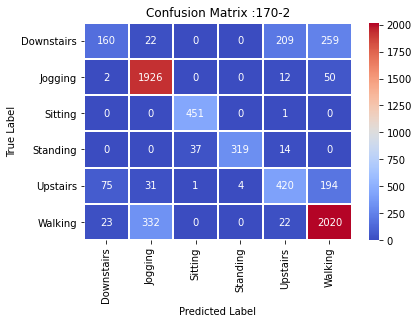


--- Classification report for test data 170:2---

              precision    recall  f1-score   support

           0       0.62      0.25      0.35       650
           1       0.83      0.97      0.90      1990
           2       0.92      1.00      0.96       452
           3       0.99      0.86      0.92       370
           4       0.62      0.58      0.60       725
           5       0.80      0.84      0.82      2397

    accuracy                           0.80      6584
   macro avg       0.80      0.75      0.76      6584
weighted avg       0.79      0.80      0.79      6584

Model: "sequential_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_123 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_245 (Conv1D)          (None, 76, 170)           2720      
____________________________________________________

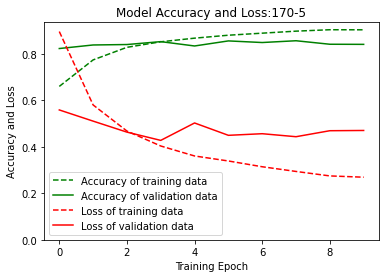


--- Check against test data ---

6584/6584 [==============================] - 1s 92us/step

Accuracy on test data: 0.88

Loss on test data: 0.39

--- Confusion matrix for test data ---



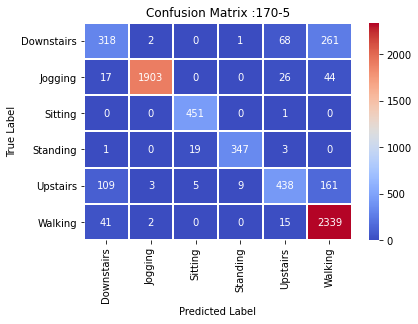


--- Classification report for test data 170:5---

              precision    recall  f1-score   support

           0       0.65      0.49      0.56       650
           1       1.00      0.96      0.98      1990
           2       0.95      1.00      0.97       452
           3       0.97      0.94      0.95       370
           4       0.79      0.60      0.69       725
           5       0.83      0.98      0.90      2397

    accuracy                           0.88      6584
   macro avg       0.87      0.83      0.84      6584
weighted avg       0.88      0.88      0.87      6584

Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_124 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_247 (Conv1D)          (None, 73, 170)           4250      
____________________________________________________

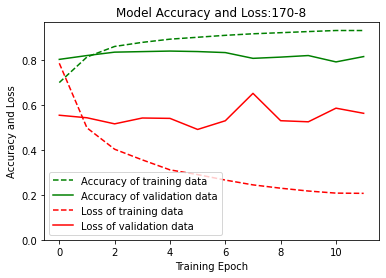


--- Check against test data ---

6584/6584 [==============================] - 1s 103us/step

Accuracy on test data: 0.90

Loss on test data: 0.37

--- Confusion matrix for test data ---



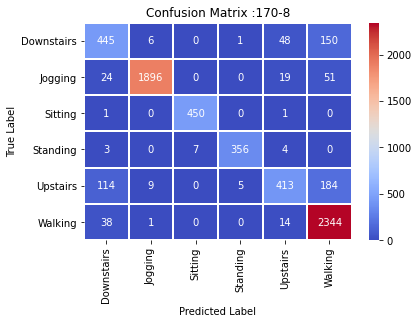


--- Classification report for test data 170:8---

              precision    recall  f1-score   support

           0       0.71      0.68      0.70       650
           1       0.99      0.95      0.97      1990
           2       0.98      1.00      0.99       452
           3       0.98      0.96      0.97       370
           4       0.83      0.57      0.67       725
           5       0.86      0.98      0.91      2397

    accuracy                           0.90      6584
   macro avg       0.89      0.86      0.87      6584
weighted avg       0.90      0.90      0.89      6584

Model: "sequential_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_125 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_249 (Conv1D)          (None, 71, 170)           5270      
____________________________________________________

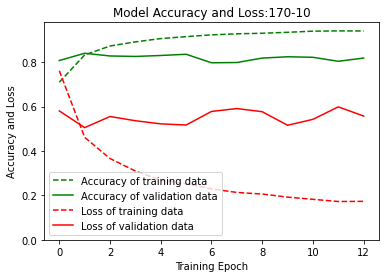


--- Check against test data ---

6584/6584 [==============================] - 1s 104us/step

Accuracy on test data: 0.92

Loss on test data: 0.32

--- Confusion matrix for test data ---



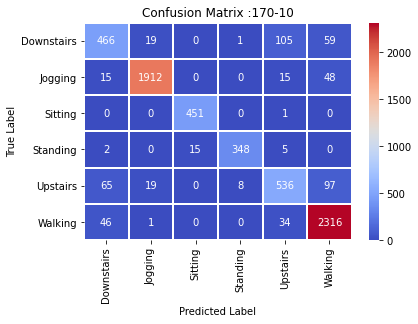


--- Classification report for test data 170:10---

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       650
           1       0.98      0.96      0.97      1990
           2       0.97      1.00      0.98       452
           3       0.97      0.94      0.96       370
           4       0.77      0.74      0.75       725
           5       0.92      0.97      0.94      2397

    accuracy                           0.92      6584
   macro avg       0.90      0.89      0.89      6584
weighted avg       0.91      0.92      0.91      6584

Model: "sequential_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_126 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_251 (Conv1D)          (None, 69, 170)           6290      
___________________________________________________

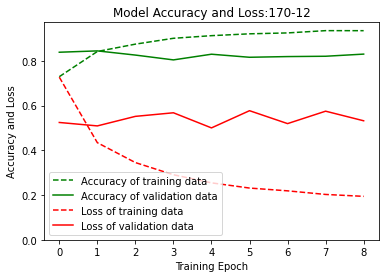


--- Check against test data ---

6584/6584 [==============================] - 1s 112us/step

Accuracy on test data: 0.90

Loss on test data: 0.38

--- Confusion matrix for test data ---



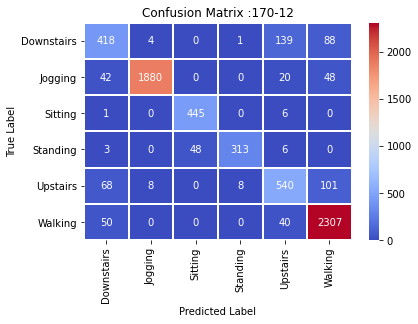


--- Classification report for test data 170:12---

              precision    recall  f1-score   support

           0       0.72      0.64      0.68       650
           1       0.99      0.94      0.97      1990
           2       0.90      0.98      0.94       452
           3       0.97      0.85      0.90       370
           4       0.72      0.74      0.73       725
           5       0.91      0.96      0.93      2397

    accuracy                           0.90      6584
   macro avg       0.87      0.85      0.86      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_127 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_253 (Conv1D)          (None, 66, 170)           7820      
___________________________________________________

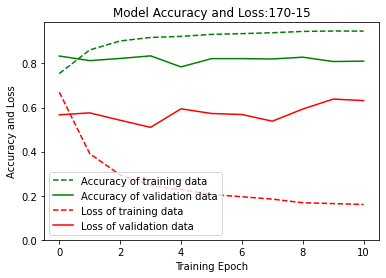


--- Check against test data ---

6584/6584 [==============================] - 1s 114us/step

Accuracy on test data: 0.87

Loss on test data: 0.47

--- Confusion matrix for test data ---



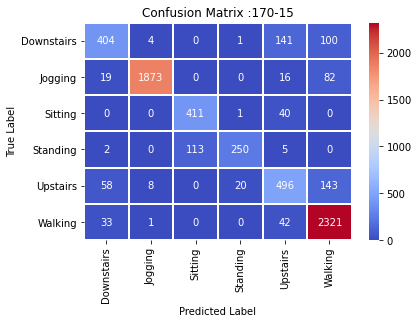


--- Classification report for test data 170:15---

              precision    recall  f1-score   support

           0       0.78      0.62      0.69       650
           1       0.99      0.94      0.97      1990
           2       0.78      0.91      0.84       452
           3       0.92      0.68      0.78       370
           4       0.67      0.68      0.68       725
           5       0.88      0.97      0.92      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.80      0.81      6584
weighted avg       0.88      0.87      0.87      6584

Model: "sequential_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_128 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_255 (Conv1D)          (None, 63, 170)           9350      
___________________________________________________

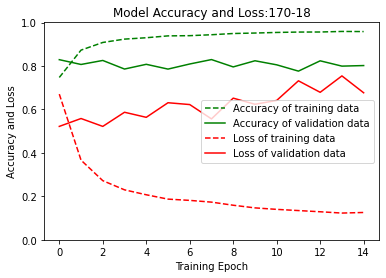


--- Check against test data ---

6584/6584 [==============================] - 0s 76us/step

Accuracy on test data: 0.88

Loss on test data: 0.49

--- Confusion matrix for test data ---



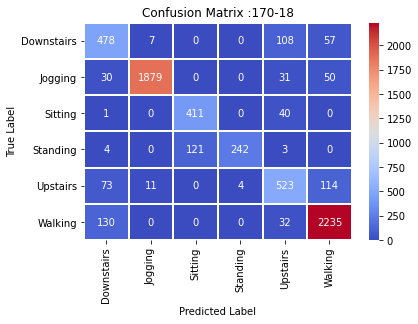


--- Classification report for test data 170:18---

              precision    recall  f1-score   support

           0       0.67      0.74      0.70       650
           1       0.99      0.94      0.97      1990
           2       0.77      0.91      0.84       452
           3       0.98      0.65      0.79       370
           4       0.71      0.72      0.72       725
           5       0.91      0.93      0.92      2397

    accuracy                           0.88      6584
   macro avg       0.84      0.82      0.82      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_129 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_257 (Conv1D)          (None, 61, 170)           10370     
___________________________________________________

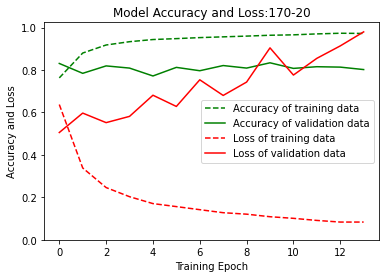


--- Check against test data ---

6584/6584 [==============================] - 0s 50us/step

Accuracy on test data: 0.87

Loss on test data: 0.58

--- Confusion matrix for test data ---



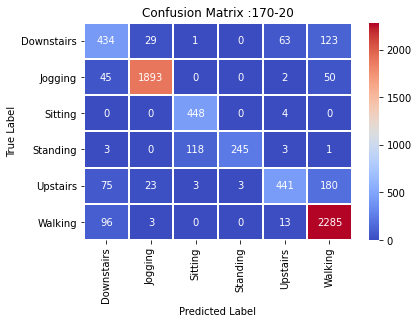


--- Classification report for test data 170:20---

              precision    recall  f1-score   support

           0       0.66      0.67      0.67       650
           1       0.97      0.95      0.96      1990
           2       0.79      0.99      0.88       452
           3       0.99      0.66      0.79       370
           4       0.84      0.61      0.71       725
           5       0.87      0.95      0.91      2397

    accuracy                           0.87      6584
   macro avg       0.85      0.81      0.82      6584
weighted avg       0.88      0.87      0.87      6584

Model: "sequential_130"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_130 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_259 (Conv1D)          (None, 79, 180)           1260      
___________________________________________________

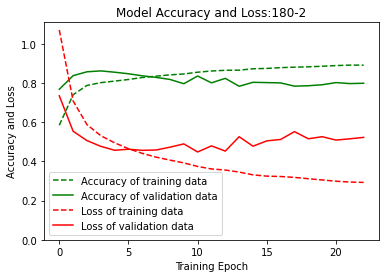


--- Check against test data ---

6584/6584 [==============================] - 0s 66us/step

Accuracy on test data: 0.82

Loss on test data: 0.54

--- Confusion matrix for test data ---



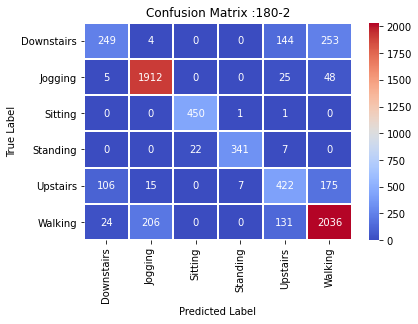


--- Classification report for test data 180:2---

              precision    recall  f1-score   support

           0       0.65      0.38      0.48       650
           1       0.89      0.96      0.93      1990
           2       0.95      1.00      0.97       452
           3       0.98      0.92      0.95       370
           4       0.58      0.58      0.58       725
           5       0.81      0.85      0.83      2397

    accuracy                           0.82      6584
   macro avg       0.81      0.78      0.79      6584
weighted avg       0.81      0.82      0.81      6584

Model: "sequential_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_131 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_261 (Conv1D)          (None, 76, 180)           2880      
____________________________________________________

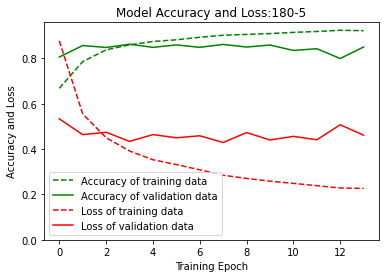


--- Check against test data ---

6584/6584 [==============================] - 1s 93us/step

Accuracy on test data: 0.89

Loss on test data: 0.36

--- Confusion matrix for test data ---



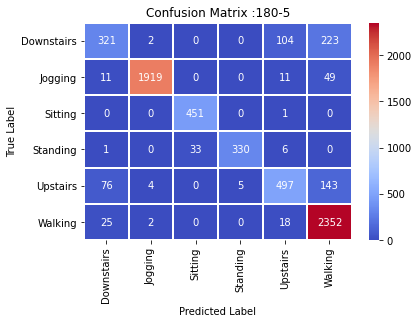


--- Classification report for test data 180:5---

              precision    recall  f1-score   support

           0       0.74      0.49      0.59       650
           1       1.00      0.96      0.98      1990
           2       0.93      1.00      0.96       452
           3       0.99      0.89      0.94       370
           4       0.78      0.69      0.73       725
           5       0.85      0.98      0.91      2397

    accuracy                           0.89      6584
   macro avg       0.88      0.84      0.85      6584
weighted avg       0.89      0.89      0.89      6584

Model: "sequential_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_132 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_263 (Conv1D)          (None, 73, 180)           4500      
____________________________________________________

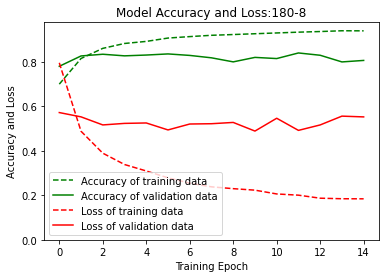


--- Check against test data ---

6584/6584 [==============================] - 1s 107us/step

Accuracy on test data: 0.91

Loss on test data: 0.35

--- Confusion matrix for test data ---



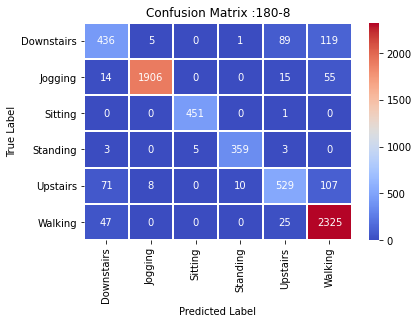


--- Classification report for test data 180:8---

              precision    recall  f1-score   support

           0       0.76      0.67      0.71       650
           1       0.99      0.96      0.98      1990
           2       0.99      1.00      0.99       452
           3       0.97      0.97      0.97       370
           4       0.80      0.73      0.76       725
           5       0.89      0.97      0.93      2397

    accuracy                           0.91      6584
   macro avg       0.90      0.88      0.89      6584
weighted avg       0.91      0.91      0.91      6584

Model: "sequential_133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_133 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_265 (Conv1D)          (None, 71, 180)           5580      
____________________________________________________

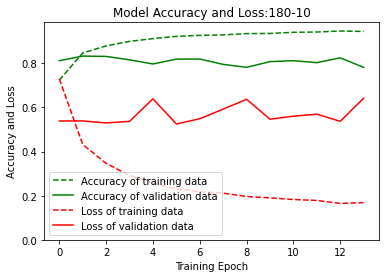


--- Check against test data ---

6584/6584 [==============================] - 1s 117us/step

Accuracy on test data: 0.92

Loss on test data: 0.33

--- Confusion matrix for test data ---



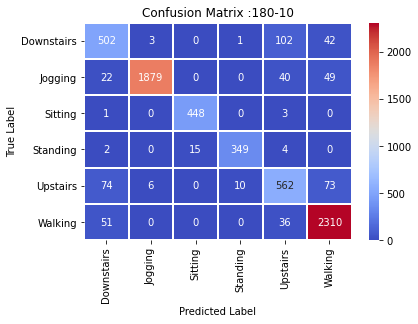


--- Classification report for test data 180:10---

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       650
           1       1.00      0.94      0.97      1990
           2       0.97      0.99      0.98       452
           3       0.97      0.94      0.96       370
           4       0.75      0.78      0.76       725
           5       0.93      0.96      0.95      2397

    accuracy                           0.92      6584
   macro avg       0.90      0.90      0.90      6584
weighted avg       0.92      0.92      0.92      6584

Model: "sequential_134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_134 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_267 (Conv1D)          (None, 69, 180)           6660      
___________________________________________________

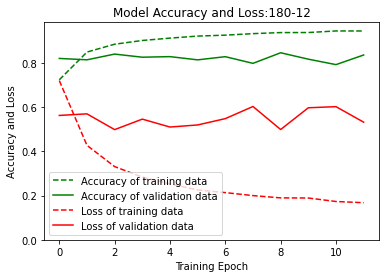


--- Check against test data ---

6584/6584 [==============================] - 1s 113us/step

Accuracy on test data: 0.90

Loss on test data: 0.36

--- Confusion matrix for test data ---



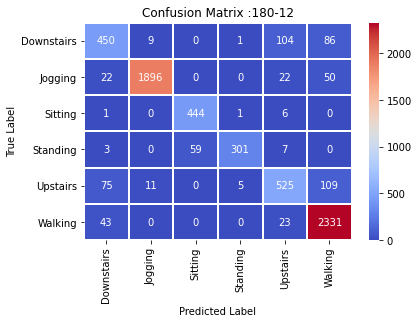


--- Classification report for test data 180:12---

              precision    recall  f1-score   support

           0       0.76      0.69      0.72       650
           1       0.99      0.95      0.97      1990
           2       0.88      0.98      0.93       452
           3       0.98      0.81      0.89       370
           4       0.76      0.72      0.74       725
           5       0.90      0.97      0.94      2397

    accuracy                           0.90      6584
   macro avg       0.88      0.86      0.87      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_135 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_269 (Conv1D)          (None, 66, 180)           8280      
___________________________________________________

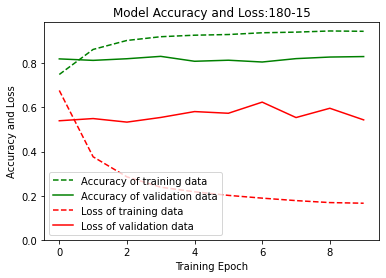


--- Check against test data ---

6584/6584 [==============================] - 1s 100us/step

Accuracy on test data: 0.88

Loss on test data: 0.45

--- Confusion matrix for test data ---



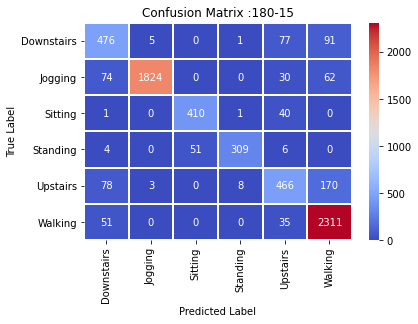


--- Classification report for test data 180:15---

              precision    recall  f1-score   support

           0       0.70      0.73      0.71       650
           1       1.00      0.92      0.95      1990
           2       0.89      0.91      0.90       452
           3       0.97      0.84      0.90       370
           4       0.71      0.64      0.68       725
           5       0.88      0.96      0.92      2397

    accuracy                           0.88      6584
   macro avg       0.86      0.83      0.84      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_136"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_136 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_271 (Conv1D)          (None, 63, 180)           9900      
___________________________________________________

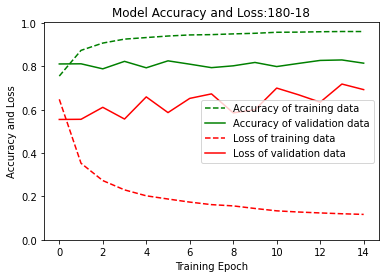


--- Check against test data ---

6584/6584 [==============================] - 1s 81us/step

Accuracy on test data: 0.88

Loss on test data: 0.47

--- Confusion matrix for test data ---



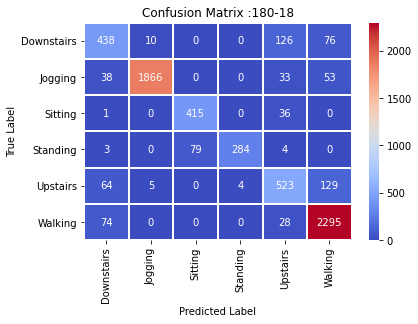


--- Classification report for test data 180:18---

              precision    recall  f1-score   support

           0       0.71      0.67      0.69       650
           1       0.99      0.94      0.96      1990
           2       0.84      0.92      0.88       452
           3       0.99      0.77      0.86       370
           4       0.70      0.72      0.71       725
           5       0.90      0.96      0.93      2397

    accuracy                           0.88      6584
   macro avg       0.85      0.83      0.84      6584
weighted avg       0.89      0.88      0.88      6584

Model: "sequential_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_137 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_273 (Conv1D)          (None, 61, 180)           10980     
___________________________________________________

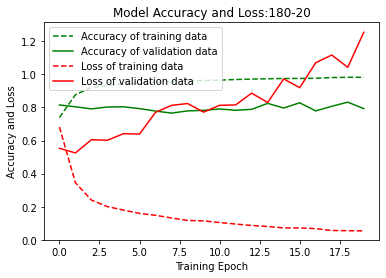


--- Check against test data ---

6584/6584 [==============================] - 0s 50us/step

Accuracy on test data: 0.87

Loss on test data: 0.67

--- Confusion matrix for test data ---



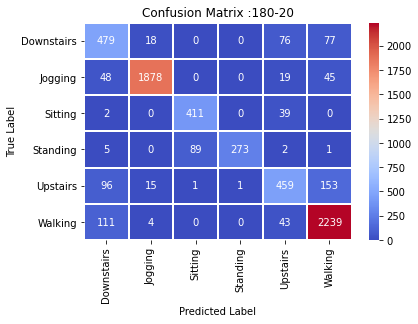


--- Classification report for test data 180:20---

              precision    recall  f1-score   support

           0       0.65      0.74      0.69       650
           1       0.98      0.94      0.96      1990
           2       0.82      0.91      0.86       452
           3       1.00      0.74      0.85       370
           4       0.72      0.63      0.67       725
           5       0.89      0.93      0.91      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.82      0.82      6584
weighted avg       0.88      0.87      0.87      6584

Model: "sequential_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_138 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_275 (Conv1D)          (None, 79, 200)           1400      
___________________________________________________

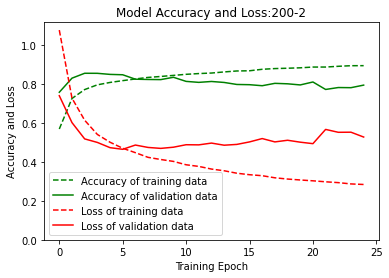


--- Check against test data ---

6584/6584 [==============================] - 0s 70us/step

Accuracy on test data: 0.81

Loss on test data: 0.51

--- Confusion matrix for test data ---



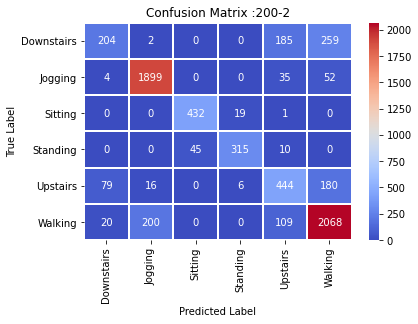


--- Classification report for test data 200:2---

              precision    recall  f1-score   support

           0       0.66      0.31      0.43       650
           1       0.90      0.95      0.92      1990
           2       0.91      0.96      0.93       452
           3       0.93      0.85      0.89       370
           4       0.57      0.61      0.59       725
           5       0.81      0.86      0.83      2397

    accuracy                           0.81      6584
   macro avg       0.79      0.76      0.77      6584
weighted avg       0.81      0.81      0.80      6584

Model: "sequential_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_139 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_277 (Conv1D)          (None, 76, 200)           3200      
____________________________________________________

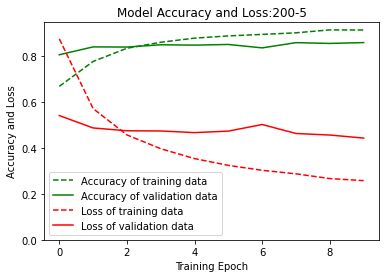


--- Check against test data ---

6584/6584 [==============================] - 1s 107us/step

Accuracy on test data: 0.87

Loss on test data: 0.41

--- Confusion matrix for test data ---



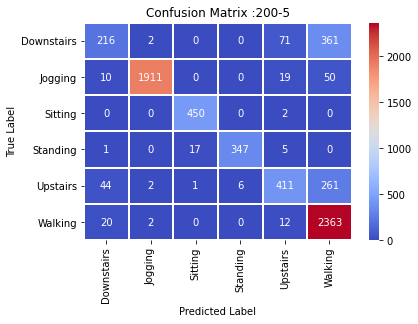


--- Classification report for test data 200:5---

              precision    recall  f1-score   support

           0       0.74      0.33      0.46       650
           1       1.00      0.96      0.98      1990
           2       0.96      1.00      0.98       452
           3       0.98      0.94      0.96       370
           4       0.79      0.57      0.66       725
           5       0.78      0.99      0.87      2397

    accuracy                           0.87      6584
   macro avg       0.88      0.80      0.82      6584
weighted avg       0.87      0.87      0.85      6584

Model: "sequential_140"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_140 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_279 (Conv1D)          (None, 73, 200)           5000      
____________________________________________________

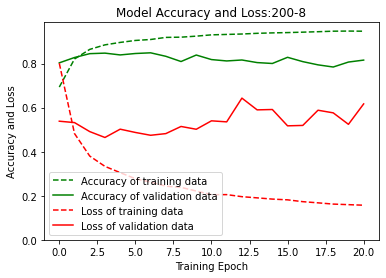


--- Check against test data ---

6584/6584 [==============================] - 1s 116us/step

Accuracy on test data: 0.91

Loss on test data: 0.38

--- Confusion matrix for test data ---



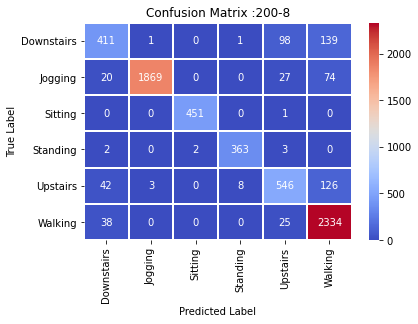


--- Classification report for test data 200:8---

              precision    recall  f1-score   support

           0       0.80      0.63      0.71       650
           1       1.00      0.94      0.97      1990
           2       1.00      1.00      1.00       452
           3       0.98      0.98      0.98       370
           4       0.78      0.75      0.77       725
           5       0.87      0.97      0.92      2397

    accuracy                           0.91      6584
   macro avg       0.90      0.88      0.89      6584
weighted avg       0.91      0.91      0.91      6584

Model: "sequential_141"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_141 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_281 (Conv1D)          (None, 71, 200)           6200      
____________________________________________________

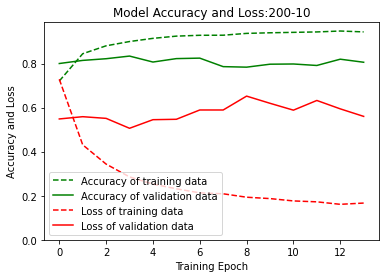


--- Check against test data ---

6584/6584 [==============================] - 1s 131us/step

Accuracy on test data: 0.91

Loss on test data: 0.35

--- Confusion matrix for test data ---



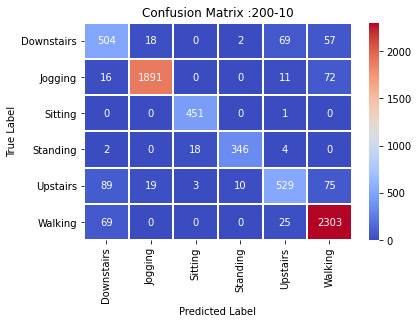


--- Classification report for test data 200:10---

              precision    recall  f1-score   support

           0       0.74      0.78      0.76       650
           1       0.98      0.95      0.97      1990
           2       0.96      1.00      0.98       452
           3       0.97      0.94      0.95       370
           4       0.83      0.73      0.78       725
           5       0.92      0.96      0.94      2397

    accuracy                           0.91      6584
   macro avg       0.90      0.89      0.89      6584
weighted avg       0.92      0.91      0.91      6584

Model: "sequential_142"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_142 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_283 (Conv1D)          (None, 69, 200)           7400      
___________________________________________________

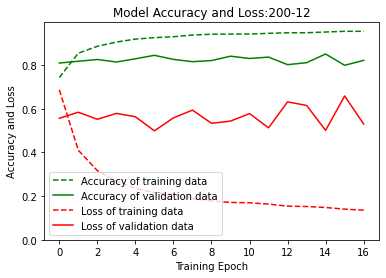


--- Check against test data ---

6584/6584 [==============================] - 1s 128us/step

Accuracy on test data: 0.91

Loss on test data: 0.33

--- Confusion matrix for test data ---



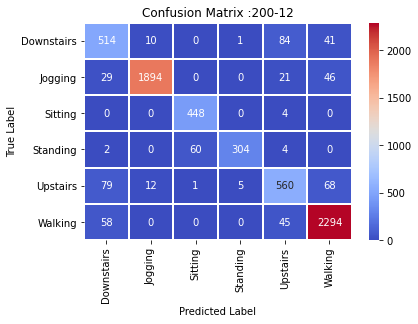


--- Classification report for test data 200:12---

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       650
           1       0.99      0.95      0.97      1990
           2       0.88      0.99      0.93       452
           3       0.98      0.82      0.89       370
           4       0.78      0.77      0.78       725
           5       0.94      0.96      0.95      2397

    accuracy                           0.91      6584
   macro avg       0.89      0.88      0.88      6584
weighted avg       0.92      0.91      0.91      6584

Model: "sequential_143"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_143 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_285 (Conv1D)          (None, 66, 200)           9200      
___________________________________________________

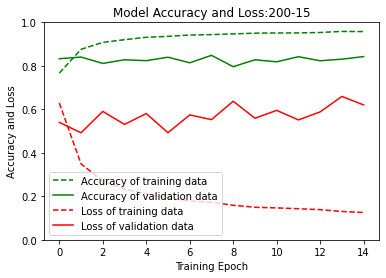


--- Check against test data ---

6584/6584 [==============================] - 1s 117us/step

Accuracy on test data: 0.88

Loss on test data: 0.48

--- Confusion matrix for test data ---



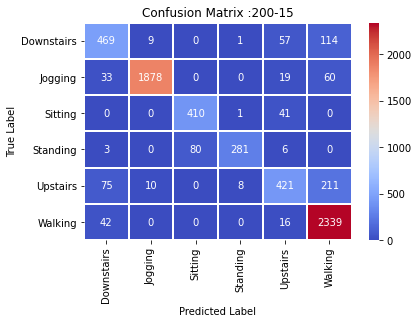


--- Classification report for test data 200:15---

              precision    recall  f1-score   support

           0       0.75      0.72      0.74       650
           1       0.99      0.94      0.97      1990
           2       0.84      0.91      0.87       452
           3       0.97      0.76      0.85       370
           4       0.75      0.58      0.66       725
           5       0.86      0.98      0.91      2397

    accuracy                           0.88      6584
   macro avg       0.86      0.81      0.83      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_144"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_144 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_287 (Conv1D)          (None, 63, 200)           11000     
___________________________________________________

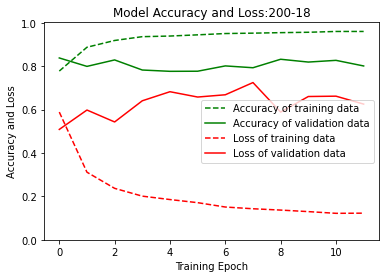


--- Check against test data ---

6584/6584 [==============================] - 1s 89us/step

Accuracy on test data: 0.88

Loss on test data: 0.42

--- Confusion matrix for test data ---



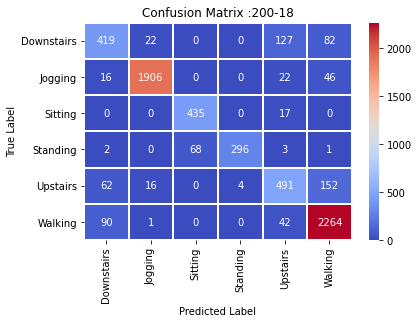


--- Classification report for test data 200:18---

              precision    recall  f1-score   support

           0       0.71      0.64      0.68       650
           1       0.98      0.96      0.97      1990
           2       0.86      0.96      0.91       452
           3       0.99      0.80      0.88       370
           4       0.70      0.68      0.69       725
           5       0.89      0.94      0.92      2397

    accuracy                           0.88      6584
   macro avg       0.86      0.83      0.84      6584
weighted avg       0.88      0.88      0.88      6584

Model: "sequential_145"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_145 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_289 (Conv1D)          (None, 61, 200)           12200     
___________________________________________________

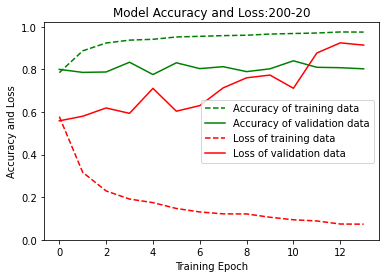


--- Check against test data ---

6584/6584 [==============================] - 0s 60us/step

Accuracy on test data: 0.88

Loss on test data: 0.57

--- Confusion matrix for test data ---



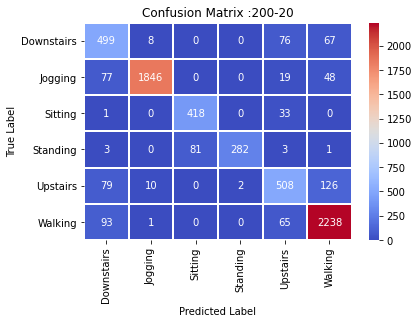


--- Classification report for test data 200:20---

              precision    recall  f1-score   support

           0       0.66      0.77      0.71       650
           1       0.99      0.93      0.96      1990
           2       0.84      0.92      0.88       452
           3       0.99      0.76      0.86       370
           4       0.72      0.70      0.71       725
           5       0.90      0.93      0.92      2397

    accuracy                           0.88      6584
   macro avg       0.85      0.84      0.84      6584
weighted avg       0.89      0.88      0.88      6584



{5: [0.5876367092132568,
  0.7095990180969238,
  0.709902822971344,
  0.734204113483429,
  0.7095990180969238,
  0.7241798043251038,
  0.7328372001647949,
  0.37560752034187317],
 10: [0.6714763045310974,
  0.7222053408622742,
  0.7375455498695374,
  0.8001214861869812,
  0.8046780228614807,
  0.8168286681175232,
  0.7126367092132568,
  0.7323815226554871],
 15: [0.7080801725387573,
  0.7954131364822388,
  0.825637936592102,
  0.8177399635314941,
  0.8133353590965271,
  0.8386998772621155,
  0.8333839774131775,
  0.828827440738678],
 20: [0.7588092088699341,
  0.8102976679801941,
  0.8671020865440369,
  0.8496354818344116,
  0.8513062000274658,
  0.8651275634765625,
  0.8324726819992065,
  0.8192588090896606],
 25: [0.7717193365097046,
  0.8370291590690613,
  0.8510024547576904,
  0.8784933090209961,
  0.8894289135932922,
  0.8590522408485413,
  0.8598116636276245,
  0.849939227104187],
 35: [0.7662515044212341,
  0.8707472681999207,
  0.8839611411094666,
  0.9011239409446716,
  0.8935

In [5]:
val = {}
for k in [5,10,15,20,25,35,50,65,75,85,95,110,130,150,160,170,180,200]: #kernal
    tmp = []
    for f in [2,5,8,10,12,15,18,20]: #filter 
        try:
            tmp.append(call_model(k,f))
        except:
            print("----------Failed_______",f)
    val[k] = tmp
val
        

In [6]:
val

{5: [0.5876367092132568,
  0.7095990180969238,
  0.709902822971344,
  0.734204113483429,
  0.7095990180969238,
  0.7241798043251038,
  0.7328372001647949,
  0.37560752034187317],
 10: [0.6714763045310974,
  0.7222053408622742,
  0.7375455498695374,
  0.8001214861869812,
  0.8046780228614807,
  0.8168286681175232,
  0.7126367092132568,
  0.7323815226554871],
 15: [0.7080801725387573,
  0.7954131364822388,
  0.825637936592102,
  0.8177399635314941,
  0.8133353590965271,
  0.8386998772621155,
  0.8333839774131775,
  0.828827440738678],
 20: [0.7588092088699341,
  0.8102976679801941,
  0.8671020865440369,
  0.8496354818344116,
  0.8513062000274658,
  0.8651275634765625,
  0.8324726819992065,
  0.8192588090896606],
 25: [0.7717193365097046,
  0.8370291590690613,
  0.8510024547576904,
  0.8784933090209961,
  0.8894289135932922,
  0.8590522408485413,
  0.8598116636276245,
  0.849939227104187],
 35: [0.7662515044212341,
  0.8707472681999207,
  0.8839611411094666,
  0.9011239409446716,
  0.8935

In [7]:
kernal_filter_mat = pd.DataFrame(val)
kernal_filter_mat["index"] = np.array([2,5,8,10,12,15,18,20])
kernal_filter_mat.set_index("index")

5         10        15        20        25        35        50   \
index                                                                         
2      0.587637  0.671476  0.708080  0.758809  0.771719  0.766252  0.789793   
5      0.709599  0.722205  0.795413  0.810298  0.837029  0.870747  0.875000   
8      0.709903  0.737546  0.825638  0.867102  0.851002  0.883961  0.898542   
10     0.734204  0.800121  0.817740  0.849635  0.878493  0.901124  0.889733   
12     0.709599  0.804678  0.813335  0.851306  0.889429  0.893530  0.897023   
15     0.724180  0.816829  0.838700  0.865128  0.859052  0.879708  0.885784   
18     0.732837  0.712637  0.833384  0.832473  0.859812  0.871507  0.869684   
20     0.375608  0.732382  0.828827  0.819259  0.849939  0.868013  0.881379   

            65        75        85        95        110       130       150  \
index                                                                         
2      0.782503  0.776580  0.771871  0.787515  0.797691  0.810146  0.808019   
5      0.889277  0.885480  0.885784  0.897934  0.885480  0.890948  0.894137   
8      0.897783  0.903858  0.904921  0.907503  0.915401  0.890036  0.911604   
10     0.898542  0.906744  0.911148  0.909174  0.909326  0.903706  0.901428   
12     0.899301  0.902187  0.904314  0.906136  0.908718  0.895960  0.892770   
15     0.878493  0.884113  0.877734  0.872266  0.877430  0.884569  0.878949   
18     0.871659  0.875911  0.873785  0.875000  0.879860  0.863457  0.879405   
20     0.868773  0.876519  0.861938  0.873329  0.867254  0.865735  0.869684   

            160       170       180       200  
index                                          
2      0.801033  0.804374  0.821689  0.814399  
5      0.884265  0.880316  0.891555  0.865431  
8      0.892467  0.896719  0.912211  0.907351  
10     0.913123  0.915705  0.918894  0.914945  
12     0.903098  0.896567  0.903250  0.913426  
15     0.877886  0.874089  0.880316  0.880620  
18     0.875000  0.876063  0.884113  0.882594  
20     0.865887  0.872722  0.871659  0.879556

In [8]:
import pickle
with open('kvsf_val_1.p','wb') as fp:
    pickle.dump(val,fp)
    
with open('kvsf_1.p','wb') as fp:
    pickle.dump(kernal_filter_mat,fp)

In [9]:
kernal_filter_mat["index"].values

array([ 2,  5,  8, 10, 12, 15, 18, 20])

In [10]:
final_val = []
for k,v in val.items():
    f_s = kernal_filter_mat["index"].values
    for i in range(len(f_s)):
        final_val.append([k,f_s[i],v[i]])
final_val

[[5, 2, 0.5876367092132568],
 [5, 5, 0.7095990180969238],
 [5, 8, 0.709902822971344],
 [5, 10, 0.734204113483429],
 [5, 12, 0.7095990180969238],
 [5, 15, 0.7241798043251038],
 [5, 18, 0.7328372001647949],
 [5, 20, 0.37560752034187317],
 [10, 2, 0.6714763045310974],
 [10, 5, 0.7222053408622742],
 [10, 8, 0.7375455498695374],
 [10, 10, 0.8001214861869812],
 [10, 12, 0.8046780228614807],
 [10, 15, 0.8168286681175232],
 [10, 18, 0.7126367092132568],
 [10, 20, 0.7323815226554871],
 [15, 2, 0.7080801725387573],
 [15, 5, 0.7954131364822388],
 [15, 8, 0.825637936592102],
 [15, 10, 0.8177399635314941],
 [15, 12, 0.8133353590965271],
 [15, 15, 0.8386998772621155],
 [15, 18, 0.8333839774131775],
 [15, 20, 0.828827440738678],
 [20, 2, 0.7588092088699341],
 [20, 5, 0.8102976679801941],
 [20, 8, 0.8671020865440369],
 [20, 10, 0.8496354818344116],
 [20, 12, 0.8513062000274658],
 [20, 15, 0.8651275634765625],
 [20, 18, 0.8324726819992065],
 [20, 20, 0.8192588090896606],
 [25, 2, 0.7717193365097046],
 

In [12]:
final_ker_filter = pd.DataFrame(final_val)
final_ker_filter.columns=['X',"Y","Z"] #filter,kernal

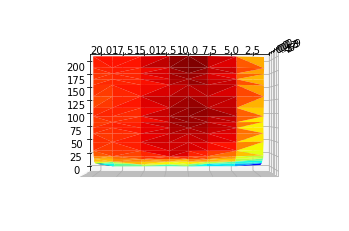

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
 
# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(final_ker_filter["X"], final_ker_filter["Y"], final_ker_filter["Z"], cmap=plt.cm.jet, linewidth=0.2)
ax.view_init(90, 180)
plt.show()



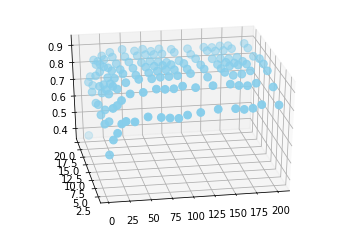

In [26]:
# plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(final_ker_filter["X"], final_ker_filter["Y"], final_ker_filter["Z"], c='skyblue', s=60)
ax.view_init(30, 260)#ax.view_init(30, 185)
plt.show()
